# Importation des librairies

In [111]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os.path

from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv
from lifelines.utils import concordance_index



# Preprocessing

In [112]:
clinical_test=pd.read_csv('data/clinical_test.csv')
clinical_train=pd.read_csv('data/clinical_train.csv')

molecular_test=pd.read_csv('data/molecular_test.csv')
molecular_train=pd.read_csv('data/molecular_train.csv')


In [113]:
target_df=pd.read_csv('data/target_train.csv')

# Drop rows where 'OS_YEARS' is NaN if conversion caused any issues
target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)


# Contarget_dfvert 'OS_YEARS' to numeric if it isn’t already
target_df['OS_YEARS'] = pd.to_numeric(target_df['OS_YEARS'], errors='coerce')

# Ensure 'OS_STATUS' is boolean
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool)

In [114]:
from sklearn.impute import KNNImputer

def precise_missing_values(df):
    # Imputation KNN pour les variables numériques
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    imputer = KNNImputer(n_neighbors=5)
    df[num_cols] = imputer.fit_transform(df[num_cols])

    # Pour les variables catégorielles, on remplace par 'Missing'
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col] = df[col].fillna('Missing')
    return df

clinical_train = precise_missing_values(clinical_train)
clinical_test = precise_missing_values(clinical_test)
molecular_train = precise_missing_values(molecular_train)
molecular_test = precise_missing_values(molecular_test)

In [115]:
import pandas as pd
import numpy as np

def aggregate_leukemia_data_improved(df, clinical_df=None):
    """
    Agrégation avancée des données de mutations par patient avec intégration
    des facteurs pronostiques ELN 2022 et des recommandations cliniques.
    (Version sans intégration des données cliniques)
    """
    # === DÉFINITIONS DES GÈNES SELON ELN 2022 ===
    adverse_genes = {
        'TP53', 'ASXL1', 'RUNX1', 'EZH2', 'SF3B1', 'SRSF2', 'U2AF1', 
        'ZRSR2', 'STAG2', 'BCOR', 'SETBP1'
    }
    dna_methylation_genes = {'DNMT3A', 'TET2', 'IDH1', 'IDH2'}
    favorable_genes = {'NPM1', 'CEBPA'}
    all_genes = [
        'GNB1', 'CSF3R', 'MPL', 'NRAS', 'HAX1', 'RIT1', 'SMC3', 'WT1', 'ATM', 'CBL',
        'ETV6', 'ETNK1', 'KRAS', 'ARID2', 'NFE2', 'SH2B3', 'PTPN11', 'FLT3', 'BRCA2',
        'PDS5B', 'IDH2', 'BLM', 'CREBBP', 'CTCF', 'PRPF8', 'TP53', 'NF1', 'SUZ12',
        'STAT5B', 'STAT3', 'PPM1D', 'SRSF2', 'SETBP1', 'BCL2', 'EPOR', 'CALR', 'CEBPA',
        'U2AF2', 'DNMT3A', 'ASXL2', 'SF3B1', 'IDH1', 'ASXL1', 'GNAS', 'RUNX1', 'U2AF1',
        'CHEK2', 'MYD88', 'GATA2', 'KIT', 'TET2', 'TERT', 'IRF1', 'CSNK1A1', 'NPM1',
        'NSD1', 'DDX41', 'JARID2', 'CCND3', 'VEGFA', 'IKZF1', 'EGFR', 'SBDS', 'CUX1',
        'BRAF', 'EZH2', 'RAD21', 'JAK2', 'CDKN2A', 'FANCG', 'NOTCH1', 'PIGA', 'ZRSR2',
        'BCOR', 'USP9X', 'KDM6A', 'SMC1A', 'MED12', 'STAG2', 'BCORL1', 'PHF6', 'BRCC3',
        'MLL'
    ]
    gene_weights = {
        'TP53': 5.0,
        'ASXL1': 2.0, 'RUNX1': 2.0, 'EZH2': 2.0,
        'SF3B1': 1.8, 'SRSF2': 1.8, 'U2AF1': 1.8, 'ZRSR2': 1.8,
        'STAG2': 1.5, 'BCOR': 1.5, 'SETBP1': 1.5,
        'DNMT3A': 1.5, 'TET2': 1.5, 'IDH1': 1.8, 'IDH2': 1.8,
        'FLT3': 2.0,
        'NPM1': -2.5,
        'CEBPA': -3.0,
        'KIT': 1.2, 'NRAS': 0.8, 'KRAS': 0.8, 'PTPN11': 0.8
    }
    bad_effects = ['nonsense', 'frameshift', 'splice_site', 'stop_gained']
    # === AGRÉGATION BASIQUE ===
    result = df.groupby('ID').agg({
        'GENE': ['count', 'nunique'],
        'CHR': 'nunique',
        'VAF': ['mean', 'max', 'median', 'min', 'var'],
        'DEPTH': ['mean', 'median', 'min', 'max', 'var']
    }).reset_index()
    result.columns = [
        'ID', 'nb_mutations', 'nb_genes', 'nb_chromosomes',
        'vaf_mean', 'vaf_max', 'vaf_median', 'vaf_min', 'vaf_var',
        'depth_mean', 'depth_median', 'depth_min', 'depth_max', 'depth_var'
    ]
    # === MATRICE BINAIRE GÈNE x PATIENT ===
    has_gene = (
        df.pivot_table(index='ID', columns='GENE', values='CHR', aggfunc='size', fill_value=0)
        .reindex(columns=all_genes, fill_value=0)
        .astype(int)
    )
    has_gene.columns = [f'has_{g}' for g in has_gene.columns]
    has_gene.reset_index(inplace=True)
    result = result.merge(has_gene, on='ID', how='left')
    # === NOUVEAUX INDICATEURS GÉNÉTIQUES ===
    adverse_cols = [f'has_{g}' for g in adverse_genes if f'has_{g}' in result.columns]
    result['has_adverse_gene'] = result[adverse_cols].sum(axis=1).clip(upper=1)
    result['nb_adverse_genes'] = result[adverse_cols].sum(axis=1)
    methylation_cols = [f'has_{g}' for g in dna_methylation_genes if f'has_{g}' in result.columns]
    result['has_methylation_gene'] = result[methylation_cols].sum(axis=1).clip(upper=1)
    result['nb_methylation_genes'] = result[methylation_cols].sum(axis=1)
    result['has_NPM1_favorable'] = result.get('has_NPM1', 0)
    result['has_CEBPA_favorable'] = result.get('has_CEBPA', 0)
    result['high_mutation_burden'] = (result['nb_mutations'] > 3).astype(int)
    result['mutation_burden_score'] = np.where(
        result['nb_mutations'] > 3, 
        (result['nb_mutations'] - 3) * 0.5, 
        0
    )
    result['nb_bad_effects'] = df.groupby('ID')['EFFECT'].apply(lambda x: x.isin(bad_effects).sum()).values
    result['nb_high_vaf'] = df.groupby('ID')['VAF'].apply(lambda x: (x > 0.4).sum()).values
    result['nb_very_high_vaf'] = df.groupby('ID')['VAF'].apply(lambda x: (x > 0.6).sum()).values
    # === CALCUL DU SCORE DE RISQUE AMÉLIORÉ (SANS CLINIQUE) ===
    has_cols = [f'has_{g}' for g in gene_weights if f'has_{g}' in result.columns]
    weights_series = pd.Series([gene_weights[g] for g in gene_weights if f'has_{g}' in result.columns], 
                              index=has_cols)
    gene_score = result[has_cols].dot(weights_series)
    methylation_penalty = np.where(result['nb_methylation_genes'] >= 2, 
                                  result['nb_methylation_genes'] * 0.8, 0)
    npm1_modulation = 0
    if 'has_NPM1' in result.columns and 'has_FLT3' in result.columns:
        npm1_modulation = np.where(
            (result['has_NPM1'] == 1) & (result['has_FLT3'] == 1),
            1.5,
            0
        )
    result['risk_score_genetic'] = (
        gene_score +
        methylation_penalty +
        npm1_modulation +
        result['mutation_burden_score'] +
        0.3 * result['nb_high_vaf'] +
        0.5 * result['nb_very_high_vaf']
    )
    result['risk_score_raw'] = result['risk_score_genetic']
    def enhanced_logistic(score, intercept=3.0, scale=2.5, floor=0.05, ceiling=0.95):
        z = (score - intercept) / scale
        prob = 1.0 / (1.0 + np.exp(-z))
        return np.clip(prob, floor, ceiling)
    result['risk_score_prob'] = result['risk_score_raw'].apply(enhanced_logistic)
    def classify_eln_risk(row):
        if ((row.get('has_NPM1', 0) == 1 and row.get('has_FLT3', 0) == 0) or
            row.get('has_CEBPA', 0) == 1):
            if row['has_adverse_gene'] == 0:
                return 'Favorable'
        if (row['has_adverse_gene'] == 1 or 
            row.get('has_TP53', 0) == 1 or
            row['nb_adverse_genes'] >= 2):
            return 'Adverse'
        return 'Intermediate'
    result['eln_risk_category'] = result.apply(classify_eln_risk, axis=1)
    result['genetic_complexity'] = (
        result['nb_genes'] + 
        result['nb_adverse_genes'] * 2 + 
        result['nb_methylation_genes']
    )
    result['vaf_heterogeneity'] = result['vaf_var'].fillna(0)
    return result

# === FONCTION D'USAGE ===
def aggregation(molecular_train, molecular_test, clinical_train=None, clinical_test=None):
    print("Agrégation des données d'entraînement...")
    molecular_train_agg = aggregate_leukemia_data_improved(molecular_train, clinical_train)
    print("Agrégation des données de test...")
    molecular_test_agg = aggregate_leukemia_data_improved(molecular_test, clinical_test)
    print(f"Train: {len(molecular_train_agg)} patients, {molecular_train_agg.shape[1]} features")
    print(f"Test: {len(molecular_test_agg)} patients, {molecular_test_agg.shape[1]} features")
    print("\n=== DISTRIBUTION DES SCORES DE RISQUE (TRAIN) ===")
    print(f"Score brut moyen: {molecular_train_agg['risk_score_raw'].mean():.2f}")
    print(f"Probabilité de risque moyenne: {molecular_train_agg['risk_score_prob'].mean():.2f}")
    if 'eln_risk_category' in molecular_train_agg.columns:
        print("\n=== RÉPARTITION ELN (TRAIN) ===")
        print(molecular_train_agg['eln_risk_category'].value_counts())
    print("\n=== DISTRIBUTION DES SCORES DE RISQUE (TEST) ===")
    print(f"Score brut moyen: {molecular_test_agg['risk_score_raw'].mean():.2f}")
    print(f"Probabilité de risque moyenne: {molecular_test_agg['risk_score_prob'].mean():.2f}")
    if 'eln_risk_category' in molecular_test_agg.columns:
        print("\n=== RÉPARTITION ELN (TEST) ===")
        print(molecular_test_agg['eln_risk_category'].value_counts())
    return molecular_train_agg, molecular_test_agg

# Exemple d'utilisation :
molecular_train_agg, molecular_test_agg = aggregation(molecular_train, molecular_test, clinical_train, clinical_test)


Agrégation des données d'entraînement...
Agrégation des données de test...
Train: 3026 patients, 114 features
Test: 1054 patients, 114 features

=== DISTRIBUTION DES SCORES DE RISQUE (TRAIN) ===
Score brut moyen: 6.24
Probabilité de risque moyenne: 0.68

=== RÉPARTITION ELN (TRAIN) ===
eln_risk_category
Adverse         2447
Intermediate     550
Favorable         29
Name: count, dtype: int64

=== DISTRIBUTION DES SCORES DE RISQUE (TEST) ===
Score brut moyen: 5.29
Probabilité de risque moyenne: 0.64

=== RÉPARTITION ELN (TEST) ===
eln_risk_category
Adverse         811
Intermediate    210
Favorable        33
Name: count, dtype: int64


In [116]:
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def extract_cytogenetic_features(data):
    """Extrait les anomalies chromosomiques fréquentes"""
    abnormalities = {
        "monosomy_7": r"[-]7|\bdel\(7",
        "monosomy_5": r"[-]5|\bdel\(5",
        "del_20q": r"del\(20\)\(q",
        "inv_16": r"inv\(16\)",
        "t_8_21": r"t\(8;21\)",
        "t_15_17": r"t\(15;17\)",
        "t_3_3": r"t\(3;3",
        "del_3_q26": r"del\(3\)\(q26",
        "t_3_9": r"t\(3;9\)",
        "trisomy_8": r"\+8"
    }

    for name, regex in abnormalities.items():
        data[name] = data["CYTOGENETICS"].str.contains(regex, case=False, na=False).astype(int)

    # Complex karyotype = 3 anomalies ou plus
    def is_complex(k):
        if pd.isna(k):
            return 0
        # Compter les délétions, translocations, inversions, etc.
        anomalies = re.findall(r"del\(|t\(|inv\(|ins\(|\+\d+|-\d+", str(k))
        return int(len(anomalies) >= 3)
    
    data["complex_karyotype"] = data["CYTOGENETICS"].apply(is_complex)
    return data

def assign_eln_risk(row):
    """Classification ELN 2022 des risques pronostiques"""
    # Risque favorable
    if row["t_8_21"] == 1 or row["inv_16"] == 1 or row["t_15_17"] == 1:
        return "favorable"
    # Risque défavorable
    elif (row["monosomy_7"] == 1 or row["monosomy_5"] == 1 or 
          row["complex_karyotype"] == 1 or row["t_3_3"] == 1 or row["del_3_q26"] == 1):
        return "adverse"
    # Risque intermédiaire
    else:
        return "intermediate"

def extract_structural_numerical_anomalies(data):
    """Extrait les anomalies structurelles vs numériques"""
    def count_structural(k):
        if pd.isna(k):
            return 0
        # Anomalies structurelles : délétions, translocations, inversions, insertions
        structural = re.findall(r"del\(|t\(|inv\(|ins\(", str(k))
        return len(structural)
    
    def count_numerical(k):
        if pd.isna(k):
            return 0
        # Anomalies numériques : gains (+) et pertes (-) de chromosomes entiers
        numerical = re.findall(r"\+\d+|-\d+", str(k))
        return len(numerical)
    
    data["structural_anomalies_count"] = data["CYTOGENETICS"].apply(count_structural)
    data["numerical_anomalies_count"] = data["CYTOGENETICS"].apply(count_numerical)
    return data

def extract_chromosome_details(data):
    """Extrait les détails des chromosomes impliqués"""
    def get_involved_chromosomes(k):
        if pd.isna(k):
            return []
        # Extraire tous les numéros de chromosomes mentionnés
        chromosomes = re.findall(r"(?:del\(|t\(|inv\(|ins\()(\d+)", str(k))
        chromosomes += re.findall(r"[+-](\d+)", str(k))
        return list(set(chromosomes))  # Supprimer les doublons
    
    data["involved_chromosomes"] = data["CYTOGENETICS"].apply(get_involved_chromosomes)
    data["num_involved_chromosomes"] = data["involved_chromosomes"].apply(len)
    
    # Créer des colonnes binaires pour les chromosomes les plus fréquemment impliqués
    common_chromosomes = ['3', '5', '7', '8', '9', '11', '15', '16', '17', '20', '21', '22']
    for chr_num in common_chromosomes:
        data[f"chr_{chr_num}_involved"] = data["involved_chromosomes"].apply(
            lambda x: 1 if chr_num in x else 0
        )
    
    return data

def create_cytogenetic_embeddings(data, max_features=100):
    """Crée des embeddings TF-IDF sur les chaînes CYTOGENETICS"""
    # Préparation des données pour TF-IDF
    cyto_texts = data["CYTOGENETICS"].fillna("normal").astype(str)
    
    # Tokenization spéciale pour les données cytogénétiques
    def cyto_tokenizer(text):
        # Extraire les éléments cytogénétiques comme tokens
        tokens = []
        tokens.extend(re.findall(r"del\(\d+\)\([pq]\d*\)", text))  # délétions
        tokens.extend(re.findall(r"t\(\d+;\d+\)", text))  # translocations
        tokens.extend(re.findall(r"inv\(\d+\)", text))  # inversions
        tokens.extend(re.findall(r"[+-]\d+", text))  # gains/pertes
        tokens.extend(re.findall(r"\d+,XX|\d+,XY", text))  # formules de base
        return tokens
    
    # Créer le vectoriseur TF-IDF
    vectorizer = TfidfVectorizer(
        tokenizer=cyto_tokenizer,
        max_features=max_features,
        lowercase=False
    )
    
    # Ajuster et transformer
    tfidf_matrix = vectorizer.fit_transform(cyto_texts)
    
    # Convertir en DataFrame
    feature_names = [f"tfidf_{i}" for i in range(tfidf_matrix.shape[1])]
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(), 
        columns=feature_names, 
        index=data.index
    )
    
    # Joindre au DataFrame principal
    data = pd.concat([data, tfidf_df], axis=1)
    return data

def preprocess(data, include_embeddings=True):
    """
    Fonction de preprocessing complète pour les données cytogénétiques
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame contenant la colonne CYTOGENETICS
    include_embeddings : bool
        Si True, inclut les embeddings TF-IDF (peut être coûteux en mémoire)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame enrichi avec toutes les features cytogénétiques
    """
    
    # 1. Normalisation de la casse des chromosomes (tout en majuscule)
    data["CYTOGENETICS"] = data["CYTOGENETICS"].str.upper()
    
    # 2. Indicateur si le caryotype est anormal (inversé par rapport à l'original)
    data["is_abnormal"] = (~data["CYTOGENETICS"].str.contains("46,XX|46,XY", case=False, na=False)).astype(int)
    # Garder aussi l'indicateur normal pour compatibilité
    data["is_normal"] = 1 - data["is_abnormal"]
    
    # 3. Extraction du nombre total de chromosomes
    data["total_chromosomes"] = data["CYTOGENETICS"].str.extract(r"^(\d+)", expand=False).astype(float)
    # Remplir avec 46 si non détecté et caryotype normal
    data.loc[~data["total_chromosomes"].notna(), "total_chromosomes"] = 46
    
    # 4. Extraction du sexe brut (ex: XY, XX)
    data["sex_raw"] = data["CYTOGENETICS"].str.extract(r"\b(XX|XY|XYY|XXY|XXX|YY)\b", expand=False)
    
    # 5. Normalisation du sexe : catégorisation des cas atypiques
    data["sex"] = data["sex_raw"].apply(lambda s: s if s in ["XX", "XY"] else "Other")
    
    # 6. Extraction des anomalies chromosomiques fréquentes
    data = extract_cytogenetic_features(data)
    
    # 7. Classification ELN des risques
    data["eln_risk"] = data.apply(assign_eln_risk, axis=1)
    
    # 8. Encodage ordinal du risque ELN
    eln_risk_mapping = {"favorable": 0, "intermediate": 1, "adverse": 2}
    data["eln_risk_ordinal"] = data["eln_risk"].map(eln_risk_mapping)
    
    # 9. Nombre de clones
    data["number_of_clones"] = data["CYTOGENETICS"].str.findall(r"\[(\d+)\]").apply(
        lambda x: sum(map(int, x)) if x else 0
    )
    
    # 10. Anomalies structurelles vs numériques
    data = extract_structural_numerical_anomalies(data)
    
    # 11. Détails des chromosomes impliqués
    data = extract_chromosome_details(data)
    
    # 12. Ratio anomalies structurelles/numériques
    data["structural_numerical_ratio"] = data["structural_anomalies_count"] / (
        data["numerical_anomalies_count"] + 1
    )  # +1 pour éviter division par zéro
    
    # 13. Score de complexité globale
    data["complexity_score"] = (
        data["structural_anomalies_count"] + 
        data["numerical_anomalies_count"] + 
        data["num_involved_chromosomes"]
    )
    
    # 14. Embeddings TF-IDF (optionnel)
    if include_embeddings:
        data = create_cytogenetic_embeddings(data)
    
    # 15. Nettoyage des colonnes intermédiaires
    columns_to_drop = ["sex_raw", "involved_chromosomes"]
    data.drop(columns=[col for col in columns_to_drop if col in data.columns], inplace=True)
    
    return data

# Exemple d'utilisation avec gestion des erreurs
def preprocess_safe(data, include_embeddings=True):
    """Version sécurisée du preprocessing avec gestion des erreurs"""
    try:
        return preprocess(data.copy(), include_embeddings=include_embeddings)
    except Exception as e:
        print(f"Erreur lors du preprocessing: {e}")
        print("Retour de la version de base...")
        return preprocess_basic(data.copy())

def preprocess_basic(data):
    """Version de base du preprocessing en cas d'erreur"""
    data["CYTOGENETICS"] = data["CYTOGENETICS"].str.upper()
    data["is_abnormal"] = (~data["CYTOGENETICS"].str.contains("46,XX|46,XY", case=False, na=False)).astype(int)
    data["total_chromosomes"] = data["CYTOGENETICS"].str.extract(r"^(\d+)", expand=False).astype(float)
    data.loc[~data["total_chromosomes"].notna(), "total_chromosomes"] = 46
    return data

# Appliquer la fonction aux datasets
clinical_test = preprocess(clinical_test)
clinical_train = preprocess(clinical_train)


c:\Users\arthr\Desktop\ENSAE 1A\QRT-Challenge-2025\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\arthr\Desktop\ENSAE 1A\QRT-Challenge-2025\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [117]:
clinical_test = clinical_test.drop('CYTOGENETICS', axis=1)
clinical_train = clinical_train.drop('CYTOGENETICS', axis=1)

In [118]:
df_train = clinical_train.merge(molecular_train_agg, on='ID', how='left').fillna(0)
df_test = clinical_test.merge(molecular_test_agg, on='ID', how='left').fillna(0)

In [119]:
df_train['mutation_burden'] = df_train['nb_mutations'] * df_train['vaf_mean']
df_test['mutation_burden'] = df_test['nb_mutations'] * df_test['vaf_mean']


for col in ['HB', 'PLT', 'BM_BLAST']:
    lower = df_train[col].quantile(0.01)
    upper = df_train[col].quantile(0.99)
    df_train[col] = df_train[col].clip(lower, upper)
    df_test[col] = df_test[col].clip(lower, upper)


In [120]:
from sklearn.preprocessing import RobustScaler

# Colonnes numériques hors cibles, présentes dans le train
features = [col for col in df_train.select_dtypes(include='number').columns if col not in ['OS_YEARS', 'OS_STATUS']]

# Ajoute les colonnes manquantes dans df_test
for col in features:
    if col not in df_test.columns:
        df_test[col] = 0

# Aligne l'ordre des colonnes
df_test = df_test.reindex(columns=df_train.columns)

scaler = RobustScaler()
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

df_train_scaled[features] = scaler.fit_transform(df_train[features])
df_test_scaled[features] = scaler.transform(df_test[features][features])

In [121]:
df_train_scaled = df_train_scaled.merge(target_df, on='ID', how='inner')

In [122]:
# prompt: supprime les variables ID et CENTER de df_train et de df_test
ID_test = df_test_scaled['ID']

df_train_scaled = df_train_scaled.drop(['ID', 'CENTER'], axis=1)
df_test_scaled = df_test_scaled.drop(['ID', 'CENTER'], axis=1)

# Modèle MTLR

In [124]:
import torch
import torch.nn as nn
from torchmtlr import (MTLR, mtlr_neg_log_likelihood, mtlr_survival, mtlr_survival_at_times)
from torchmtlr.utils import encode_survival, make_time_bins
import numpy as np
import pandas as pd

X_features = df_train_scaled.drop(columns=['OS_YEARS', 'OS_STATUS'])
X_features = pd.get_dummies(X_features, drop_first=True)
X_features = X_features.astype(float)

X_features_test = pd.get_dummies(df_test_scaled, drop_first=True)
X_features_test = X_features_test.reindex(columns=X_features.columns, fill_value=0)
X_features_test = X_features_test.astype(float)

X_train = torch.tensor(X_features.values, dtype=torch.float32)
X_test = torch.tensor(X_features_test.values, dtype=torch.float32)
y_time = torch.tensor(df_train_scaled['OS_YEARS'].values, dtype=torch.float32)
y_event = torch.tensor(df_train_scaled['OS_STATUS'].values, dtype=torch.float32)

# Création des time bins
time_bins = make_time_bins(y_time, event=y_event)
target = encode_survival(y_time, y_event, time_bins)

## Hyperparameter tuning

In [126]:
import optuna
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import numpy as np
from sksurv.metrics import concordance_index_ipcw
from sksurv.util import Surv

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def objective(trial):
    n_hidden1 = trial.suggest_int('n_hidden1', 32, 256)
    n_hidden2 = trial.suggest_int('n_hidden2', 16, 128)
    dropout1 = trial.suggest_float('dropout1', 0.1, 0.5)
    dropout2 = trial.suggest_float('dropout2', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    n_epochs = trial.suggest_int('n_epochs', 100, 900)
    activation = trial.suggest_categorical('activation', ['relu', 'leakyrelu', 'elu', 'selu'])
    if trial.suggest_categorical('use_weight_decay', [True, False]):
        weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    else:
        weight_decay = 0.0

    torch.manual_seed(42)
    np.random.seed(42)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_features, df_train_scaled['OS_STATUS'])):
        X_tr, X_val = X_features.iloc[train_idx], X_features.iloc[val_idx]
        y_time_tr, y_time_val = y_time[train_idx], y_time[val_idx]
        y_event_tr, y_event_val = y_event[train_idx], y_event[val_idx]

        events = (y_event_val == 1).sum().item() if isinstance(y_event_val, torch.Tensor) else np.sum(y_event_val == 1)
        censored = (y_event_val == 0).sum().item() if isinstance(y_event_val, torch.Tensor) else np.sum(y_event_val == 0)
        total = len(y_event_val)

        # Re-encode time bins pour chaque fold
        time_bins = make_time_bins(y_time_tr, event=y_event_tr)
        target_tr = encode_survival(y_time_tr, y_event_tr, time_bins)

        X_tr_torch = torch.tensor(X_tr.values, dtype=torch.float32)
        X_val_torch = torch.tensor(X_val.values, dtype=torch.float32)

        # Modèle dynamique
        layers = [
            nn.Linear(X_tr_torch.shape[1], n_hidden1),
            nn.BatchNorm1d(n_hidden1),
        ]
        if activation == 'relu':
            layers.append(nn.ReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU())
        elif activation == 'elu':
            layers.append(nn.ELU())
        elif activation == 'selu':
            layers.append(nn.SELU())
        layers.append(nn.Dropout(dropout1))
        layers.append(nn.Linear(n_hidden1, n_hidden2))
        layers.append(nn.BatchNorm1d(n_hidden2))
        if activation == 'relu':
            layers.append(nn.ReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU())
        elif activation == 'elu':
            layers.append(nn.ELU())
        elif activation == 'selu':
            layers.append(nn.SELU())
        layers.append(nn.Dropout(dropout2))
        layers.append(MTLR(n_hidden2, len(time_bins)))
        model = nn.Sequential(*layers)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        for epoch in range(n_epochs):
            model.train()
            optimizer.zero_grad()
            logits = model(X_tr_torch)
            loss = mtlr_neg_log_likelihood(logits, target_tr, model[-1], C1=1., average=True)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            logits_val = model(X_val_torch)
            surv_val = mtlr_survival(logits_val)
        median_pred = []
        for surv in surv_val:
            below_half = np.where(surv.numpy() <= 0.5)[0]
            if below_half.size > 0 and below_half[0] < len(time_bins):
                median_pred.append(time_bins[below_half[0]].item())
            else:
                median_pred.append(time_bins[-1].item())

        if (y_event_val == 1).sum() == 0 or (y_event_val == 0).sum() == 0:
            print(f"Fold {fold}: Skip fold (all events or all censored)")
            continue

        y_train_struct = Surv.from_arrays(event=to_numpy(y_event_tr).astype(bool), time=to_numpy(y_time_tr))
        y_val_struct = Surv.from_arrays(event=to_numpy(y_event_val).astype(bool), time=to_numpy(y_time_val))
        try:
            result = concordance_index_ipcw(
                y_train_struct,
                y_val_struct,
                -np.array(median_pred)
            )
            # Compatible avec toutes les versions de scikit-survival
            if isinstance(result, (tuple, list, np.ndarray)):
                cindex_ipcw = result[0]
            else:
                cindex_ipcw = result.cindex
            scores.append(cindex_ipcw)
        except Exception as e:
            print(f"Fold {fold}: Exception in concordance_index_ipcw: {e}")
            continue

    if len(scores) == 0:
        print("Aucun score valide, return 0.5")
        return 0.5
    print(f"Scores valides pour ce trial: {scores}")
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=400)

print("Best trial:")
print(study.best_trial)
print("Best params:", study.best_params)

[I 2025-07-22 00:31:49,172] A new study created in memory with name: no-name-71d1b9e4-32d6-47e6-9448-b853432ea618
[I 2025-07-22 00:31:57,811] Trial 0 finished with value: 0.6768466629845712 and parameters: {'n_hidden1': 42, 'n_hidden2': 117, 'dropout1': 0.15244537367767297, 'dropout2': 0.1660310408898527, 'lr': 0.00015583188526476679, 'n_epochs': 103, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 0 with value: 0.6768466629845712.


Scores valides pour ce trial: [np.float64(0.6898273533972206), np.float64(0.6219963139249841), np.float64(0.6861908361502985), np.float64(0.6998171875762149), np.float64(0.6864016238741378)]


[I 2025-07-22 00:32:42,111] Trial 1 finished with value: 0.6560040078522308 and parameters: {'n_hidden1': 211, 'n_hidden2': 78, 'dropout1': 0.15171556234612385, 'dropout2': 0.3028017575060137, 'lr': 0.0010399875435741085, 'n_epochs': 405, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0005057444301873415}. Best is trial 0 with value: 0.6768466629845712.


Scores valides pour ce trial: [np.float64(0.6731346928490779), np.float64(0.6120364378100757), np.float64(0.6541387869682367), np.float64(0.682045476353743), np.float64(0.6586646452800202)]


[I 2025-07-22 00:33:22,098] Trial 2 finished with value: 0.6520166922983547 and parameters: {'n_hidden1': 225, 'n_hidden2': 45, 'dropout1': 0.16236899268735053, 'dropout2': 0.1344561546784286, 'lr': 0.0038802076548119595, 'n_epochs': 391, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 0 with value: 0.6768466629845712.


Scores valides pour ce trial: [np.float64(0.6592117566287885), np.float64(0.6202549177189232), np.float64(0.6528134310735866), np.float64(0.6715902463141343), np.float64(0.656213109756341)]


[I 2025-07-22 00:33:54,982] Trial 3 finished with value: 0.6605418089471863 and parameters: {'n_hidden1': 118, 'n_hidden2': 65, 'dropout1': 0.20767824869539875, 'dropout2': 0.11814187116747346, 'lr': 0.0009030874989001562, 'n_epochs': 426, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 0 with value: 0.6768466629845712.


Scores valides pour ce trial: [np.float64(0.6732208006888367), np.float64(0.619796737921026), np.float64(0.6671773663535451), np.float64(0.6785149337593886), np.float64(0.6639992060131352)]


[I 2025-07-22 00:34:15,857] Trial 4 finished with value: 0.620486035103448 and parameters: {'n_hidden1': 236, 'n_hidden2': 82, 'dropout1': 0.2348810005981874, 'dropout2': 0.3798106864901003, 'lr': 0.003989978728624021, 'n_epochs': 192, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 0 with value: 0.6768466629845712.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.602110640911574), np.float64(0.6617747298939851), np.float64(0.6847209432976822), np.float64(0.653823861413999)]


[I 2025-07-22 00:35:12,553] Trial 5 finished with value: 0.6777337614296961 and parameters: {'n_hidden1': 202, 'n_hidden2': 64, 'dropout1': 0.3390672042387052, 'dropout2': 0.28306605284018915, 'lr': 0.0006663195220738468, 'n_epochs': 538, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 5 with value: 0.6777337614296961.


Scores valides pour ce trial: [np.float64(0.6997682026156858), np.float64(0.6404875501825692), np.float64(0.6817898899732001), np.float64(0.6957913919132699), np.float64(0.670831772463756)]


[I 2025-07-22 00:35:55,523] Trial 6 finished with value: 0.6404062285304214 and parameters: {'n_hidden1': 208, 'n_hidden2': 123, 'dropout1': 0.2025038990718998, 'dropout2': 0.4302597999892793, 'lr': 0.00023411717281887772, 'n_epochs': 353, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 5.106241550009385e-06}. Best is trial 5 with value: 0.6777337614296961.


Scores valides pour ce trial: [np.float64(0.6915587705858592), np.float64(0.6441977224615001), np.float64(0.6821404340028177), np.float64(0.5), np.float64(0.68413421560193)]


[I 2025-07-22 00:36:15,880] Trial 7 finished with value: 0.6344835715522803 and parameters: {'n_hidden1': 76, 'n_hidden2': 92, 'dropout1': 0.3152269665456766, 'dropout2': 0.41593599482348853, 'lr': 0.002854793272711533, 'n_epochs': 272, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0009993571214302844}. Best is trial 5 with value: 0.6777337614296961.


Scores valides pour ce trial: [np.float64(0.6778538075504764), np.float64(0.6236925642602115), np.float64(0.6780486132111442), np.float64(0.6928228727395696), np.float64(0.5)]


[I 2025-07-22 00:37:01,393] Trial 8 finished with value: 0.6846874736478173 and parameters: {'n_hidden1': 156, 'n_hidden2': 70, 'dropout1': 0.3696883551106088, 'dropout2': 0.22980898306935021, 'lr': 0.00029420274062356993, 'n_epochs': 513, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 1.7623731299544938e-05}. Best is trial 8 with value: 0.6846874736478173.


Scores valides pour ce trial: [np.float64(0.7045474376705271), np.float64(0.6390513784321405), np.float64(0.6904129148104696), np.float64(0.7023107293598713), np.float64(0.6871149079660775)]


[I 2025-07-22 00:37:21,298] Trial 9 finished with value: 0.6822293690959379 and parameters: {'n_hidden1': 113, 'n_hidden2': 121, 'dropout1': 0.20887333774226238, 'dropout2': 0.14459232884427786, 'lr': 0.0009470112959471979, 'n_epochs': 214, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 8 with value: 0.6846874736478173.


Scores valides pour ce trial: [np.float64(0.7011421850482668), np.float64(0.6417502431487756), np.float64(0.6824897317464697), np.float64(0.7007744206202069), np.float64(0.6849902649159709)]


[I 2025-07-22 00:38:15,685] Trial 10 finished with value: 0.6502404196797292 and parameters: {'n_hidden1': 158, 'n_hidden2': 17, 'dropout1': 0.45155023302541264, 'dropout2': 0.2409530993894922, 'lr': 0.0003259226416704718, 'n_epochs': 783, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 1.7056879646169162e-05}. Best is trial 8 with value: 0.6846874736478173.


Scores valides pour ce trial: [np.float64(0.6979764023812849), np.float64(0.6579570232518517), np.float64(0.6909974715393679), np.float64(0.704271201226142), np.float64(0.5)]


[I 2025-07-22 00:39:12,873] Trial 11 finished with value: 0.6451461244663304 and parameters: {'n_hidden1': 141, 'n_hidden2': 106, 'dropout1': 0.40978198125020693, 'dropout2': 0.20682779140031515, 'lr': 0.0004772585032725139, 'n_epochs': 580, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 1.3247899455133776e-06}. Best is trial 8 with value: 0.6846874736478173.


Scores valides pour ce trial: [np.float64(0.6977091321836209), np.float64(0.6490671480697506), np.float64(0.6812310219189398), np.float64(0.6977233201593404), np.float64(0.5)]


[I 2025-07-22 00:40:10,460] Trial 12 finished with value: 0.651580021347853 and parameters: {'n_hidden1': 102, 'n_hidden2': 46, 'dropout1': 0.387011661677287, 'dropout2': 0.19949429482536984, 'lr': 0.00010615550734750612, 'n_epochs': 769, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 7.943520505890634e-05}. Best is trial 8 with value: 0.6846874736478173.


Scores valides pour ce trial: [np.float64(0.7077276634921271), np.float64(0.6472976608225928), np.float64(0.700007511725508), np.float64(0.5), np.float64(0.7028672706990371)]


[I 2025-07-22 00:41:18,714] Trial 13 finished with value: 0.6700972941316846 and parameters: {'n_hidden1': 175, 'n_hidden2': 100, 'dropout1': 0.27041350168572414, 'dropout2': 0.10124594188446909, 'lr': 0.001404126218767548, 'n_epochs': 650, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 8 with value: 0.6846874736478173.


Scores valides pour ce trial: [np.float64(0.6781479183705805), np.float64(0.6452322099500547), np.float64(0.6619027030396527), np.float64(0.6974151851845544), np.float64(0.6677884541135807)]


[I 2025-07-22 00:42:03,267] Trial 14 finished with value: 0.6159223149549578 and parameters: {'n_hidden1': 95, 'n_hidden2': 48, 'dropout1': 0.4861096433163355, 'dropout2': 0.4947278457569522, 'lr': 0.0016757514081326378, 'n_epochs': 638, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 8 with value: 0.6846874736478173.


Scores valides pour ce trial: [np.float64(0.7017487023317269), np.float64(0.5), np.float64(0.5), np.float64(0.6961350197052558), np.float64(0.6817278527378059)]


[I 2025-07-22 00:43:13,188] Trial 15 finished with value: 0.6405964782112183 and parameters: {'n_hidden1': 146, 'n_hidden2': 23, 'dropout1': 0.11016364906917257, 'dropout2': 0.28025972590941345, 'lr': 0.009574833729845243, 'n_epochs': 891, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 4.992712854824475e-05}. Best is trial 8 with value: 0.6846874736478173.


Scores valides pour ce trial: [np.float64(0.6406094597982172), np.float64(0.5839077198353861), np.float64(0.648584083140076), np.float64(0.6754597664224503), np.float64(0.6544213618599628)]


[I 2025-07-22 00:43:39,439] Trial 16 finished with value: 0.6953548097346102 and parameters: {'n_hidden1': 69, 'n_hidden2': 128, 'dropout1': 0.35479046856620333, 'dropout2': 0.17820433015006124, 'lr': 0.00040339521717466375, 'n_epochs': 293, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 16 with value: 0.6953548097346102.


Scores valides pour ce trial: [np.float64(0.7095740315213811), np.float64(0.6486231313992779), np.float64(0.7051485045413324), np.float64(0.7164629824864938), np.float64(0.6969653987245653)]


[I 2025-07-22 00:44:07,726] Trial 17 finished with value: 0.6531948047755979 and parameters: {'n_hidden1': 37, 'n_hidden2': 61, 'dropout1': 0.36663641825796794, 'dropout2': 0.3407784143712648, 'lr': 0.00035841347106500875, 'n_epochs': 487, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 1.0009900631404185e-05}. Best is trial 16 with value: 0.6953548097346102.


Scores valides pour ce trial: [np.float64(0.7019613148256308), np.float64(0.6532091410360638), np.float64(0.5), np.float64(0.7095064819073726), np.float64(0.7012970861089222)]


[I 2025-07-22 00:44:33,395] Trial 18 finished with value: 0.6647579700279019 and parameters: {'n_hidden1': 59, 'n_hidden2': 93, 'dropout1': 0.4291485739819242, 'dropout2': 0.21499174158860668, 'lr': 0.00022017367463349075, 'n_epochs': 314, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 16 with value: 0.6953548097346102.


Scores valides pour ce trial: [np.float64(0.7004312834976167), np.float64(0.5), np.float64(0.7042350481473922), np.float64(0.7165287850161137), np.float64(0.7025947334783871)]


[I 2025-07-22 00:44:43,050] Trial 19 finished with value: 0.6973596145606964 and parameters: {'n_hidden1': 177, 'n_hidden2': 36, 'dropout1': 0.2780306854690104, 'dropout2': 0.24803964160272202, 'lr': 0.0005148737240646067, 'n_epochs': 106, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00023350969635517758}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.712098929884798), np.float64(0.6507538843556053), np.float64(0.7069289813662474), np.float64(0.7162138596040406), np.float64(0.7008024175927909)]


[I 2025-07-22 00:44:55,637] Trial 20 finished with value: 0.6934051104704594 and parameters: {'n_hidden1': 252, 'n_hidden2': 31, 'dropout1': 0.268898714805159, 'dropout2': 0.1796445476475993, 'lr': 0.0005339670999897176, 'n_epochs': 112, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00019520689909316126}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.7056815081581395), np.float64(0.6478062689581282), np.float64(0.7033895517504357), np.float64(0.7118183895991551), np.float64(0.6983298338864385)]


[I 2025-07-22 00:45:07,551] Trial 21 finished with value: 0.6947795830008341 and parameters: {'n_hidden1': 251, 'n_hidden2': 36, 'dropout1': 0.2774375963014993, 'dropout2': 0.17641283853144604, 'lr': 0.0005021096732138724, 'n_epochs': 103, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00019364284149456714}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.6982921306931187), np.float64(0.6522297153364317), np.float64(0.7075891088301105), np.float64(0.7141813766958437), np.float64(0.7016055834486656)]


[I 2025-07-22 00:45:24,162] Trial 22 finished with value: 0.6924170510150544 and parameters: {'n_hidden1': 180, 'n_hidden2': 34, 'dropout1': 0.2938859852842806, 'dropout2': 0.2563618560329584, 'lr': 0.0005611291610183969, 'n_epochs': 186, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00017068087243293678}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.7065768678146317), np.float64(0.6550351703365789), np.float64(0.6963797036335483), np.float64(0.7091452226436585), np.float64(0.6949482906468543)]


[I 2025-07-22 00:45:54,845] Trial 23 finished with value: 0.6655811359912995 and parameters: {'n_hidden1': 255, 'n_hidden2': 54, 'dropout1': 0.3224111566443769, 'dropout2': 0.1648905651610679, 'lr': 0.00016562679015297058, 'n_epochs': 260, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00021033413423142983}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.7056473562623276), np.float64(0.5), np.float64(0.7067225460194037), np.float64(0.7153589177625299), np.float64(0.7001768599122365)]


[I 2025-07-22 00:46:09,495] Trial 24 finished with value: 0.6956004300299633 and parameters: {'n_hidden1': 185, 'n_hidden2': 34, 'dropout1': 0.2735110794540093, 'dropout2': 0.256983996427782, 'lr': 0.00039625928181660184, 'n_epochs': 160, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0004368854061016775}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.710969508277132), np.float64(0.6512419387749052), np.float64(0.7081503556796183), np.float64(0.7101077340785049), np.float64(0.6975326133396562)]


[I 2025-07-22 00:46:27,762] Trial 25 finished with value: 0.6515250714239041 and parameters: {'n_hidden1': 181, 'n_hidden2': 22, 'dropout1': 0.24532438617259317, 'dropout2': 0.3153538404723655, 'lr': 0.0003830889650343747, 'n_epochs': 205, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0005402117978876948}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.7069878368569495), np.float64(0.6453249144026281), np.float64(0.5), np.float64(0.7108466105796433), np.float64(0.6944659952802994)]


[I 2025-07-22 00:46:40,773] Trial 26 finished with value: 0.6893930534790672 and parameters: {'n_hidden1': 131, 'n_hidden2': 41, 'dropout1': 0.3284395526616621, 'dropout2': 0.2657867736823044, 'lr': 0.0007466514244586796, 'n_epochs': 166, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.6996971687119026), np.float64(0.6446624774689365), np.float64(0.6975583848529894), np.float64(0.7086020244447175), np.float64(0.6964452119167902)]


[I 2025-07-22 00:47:07,834] Trial 27 finished with value: 0.6833775478689843 and parameters: {'n_hidden1': 193, 'n_hidden2': 53, 'dropout1': 0.354982928812926, 'dropout2': 0.3287711754127026, 'lr': 0.0016786159829041134, 'n_epochs': 275, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 9.098045437315668e-05}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.7023440686089748), np.float64(0.6543205120726386), np.float64(0.695713705953731), np.float64(0.6933986266099846), np.float64(0.6711108260995926)]


[I 2025-07-22 00:47:35,185] Trial 28 finished with value: 0.6516665594140141 and parameters: {'n_hidden1': 166, 'n_hidden2': 29, 'dropout1': 0.2942375915946253, 'dropout2': 0.24135334137230097, 'lr': 0.0002256122971315216, 'n_epochs': 328, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.6969713456287688), np.float64(0.6474457159531166), np.float64(0.7060987891784929), np.float64(0.7078169463096919), np.float64(0.5)]


[I 2025-07-22 00:47:48,328] Trial 29 finished with value: 0.6213893895453065 and parameters: {'n_hidden1': 72, 'n_hidden2': 109, 'dropout1': 0.2488497182037271, 'dropout2': 0.35628548903315, 'lr': 0.00012642644026652052, 'n_epochs': 166, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.5), np.float64(0.6991139982889474), np.float64(0.7128321227185114), np.float64(0.6950008267190738)]


[I 2025-07-22 00:47:58,272] Trial 30 finished with value: 0.6616338619520246 and parameters: {'n_hidden1': 129, 'n_hidden2': 113, 'dropout1': 0.4105037418452489, 'dropout2': 0.1969919742254243, 'lr': 0.00016427848454089963, 'n_epochs': 103, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.0004428097924602448}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.6985244941140304), np.float64(0.5), np.float64(0.6972795848646215), np.float64(0.713152891855974), np.float64(0.6992123389254966)]


[I 2025-07-22 00:48:11,499] Trial 31 finished with value: 0.694611924811192 and parameters: {'n_hidden1': 223, 'n_hidden2': 36, 'dropout1': 0.27925432870967853, 'dropout2': 0.17730721251127018, 'lr': 0.0004539858554043785, 'n_epochs': 130, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00033916258402109565}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.7088103875067556), np.float64(0.649973976184373), np.float64(0.7084815519685667), np.float64(0.7111494418895564), np.float64(0.6946442665067084)]


[I 2025-07-22 00:48:20,860] Trial 32 finished with value: 0.6951456747911671 and parameters: {'n_hidden1': 187, 'n_hidden2': 39, 'dropout1': 0.2969406983806387, 'dropout2': 0.15529971806115667, 'lr': 0.0006312031883625537, 'n_epochs': 101, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00011008490972637497}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.7087287401125103), np.float64(0.6472044711882727), np.float64(0.7076276226750294), np.float64(0.7119487059415942), np.float64(0.7002188340384289)]


[I 2025-07-22 00:48:46,621] Trial 33 finished with value: 0.6426605065337346 and parameters: {'n_hidden1': 196, 'n_hidden2': 80, 'dropout1': 0.3077310818587877, 'dropout2': 0.1501509882925671, 'lr': 0.0007118743166728064, 'n_epochs': 244, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 7.802909616840597e-05}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.6955874858866902), np.float64(0.6531047650791763), np.float64(0.6838810065471314), np.float64(0.5), np.float64(0.6807292751556753)]


[I 2025-07-22 00:49:04,312] Trial 34 finished with value: 0.6846001976505436 and parameters: {'n_hidden1': 219, 'n_hidden2': 128, 'dropout1': 0.17734382150092348, 'dropout2': 0.12941794429716721, 'lr': 0.001107682609235088, 'n_epochs': 140, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0009841590994659286}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.7051792793312405), np.float64(0.6447222859707009), np.float64(0.6896076094163539), np.float64(0.698110323026601), np.float64(0.6853814905078217)]


[I 2025-07-22 00:49:44,224] Trial 35 finished with value: 0.6472292151384615 and parameters: {'n_hidden1': 190, 'n_hidden2': 56, 'dropout1': 0.3406227284964316, 'dropout2': 0.30095265919708714, 'lr': 0.0002444798832046286, 'n_epochs': 424, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0001115975688664067}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.6988031135007771), np.float64(0.6431547417661132), np.float64(0.5), np.float64(0.7063695083746269), np.float64(0.6878187120507903)]


[I 2025-07-22 00:50:03,132] Trial 36 finished with value: 0.6755091187315416 and parameters: {'n_hidden1': 162, 'n_hidden2': 41, 'dropout1': 0.23041306423531246, 'dropout2': 0.2271578625187577, 'lr': 0.00124562463928157, 'n_epochs': 217, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.690084127408331), np.float64(0.6369572182851337), np.float64(0.6813802566060349), np.float64(0.6978928201121153), np.float64(0.6712311712460934)]


[I 2025-07-22 00:50:40,817] Trial 37 finished with value: 0.6790763514149984 and parameters: {'n_hidden1': 233, 'n_hidden2': 27, 'dropout1': 0.2260351951126776, 'dropout2': 0.1096607440573905, 'lr': 0.000619765065844855, 'n_epochs': 363, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 4.019192445669802e-05}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.695177022135689), np.float64(0.6481194730044497), np.float64(0.6834803419239023), np.float64(0.6961844908416953), np.float64(0.6724204291692559)]


[I 2025-07-22 00:50:59,029] Trial 38 finished with value: 0.646135380561949 and parameters: {'n_hidden1': 210, 'n_hidden2': 86, 'dropout1': 0.2617266908588334, 'dropout2': 0.2791566015972725, 'lr': 0.0008496927796718676, 'n_epochs': 158, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.6957098341686813), np.float64(0.6475065969878109), np.float64(0.6868108456414765), np.float64(0.7006496260117759), np.float64(0.5)]


[I 2025-07-22 00:51:28,458] Trial 39 finished with value: 0.6052847174754377 and parameters: {'n_hidden1': 173, 'n_hidden2': 74, 'dropout1': 0.3000395328843595, 'dropout2': 0.15641177131092235, 'lr': 0.0004080102003653835, 'n_epochs': 298, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0003361127294298769}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.7012270110574192), np.float64(0.6433214742407002), np.float64(0.681875102079069), np.float64(0.5), np.float64(0.5)]


[I 2025-07-22 00:51:45,772] Trial 40 finished with value: 0.651467497740951 and parameters: {'n_hidden1': 147, 'n_hidden2': 18, 'dropout1': 0.34536977656468765, 'dropout2': 0.25882464845698705, 'lr': 0.00028662236647717906, 'n_epochs': 226, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6430643788669178), np.float64(0.705838306209097), np.float64(0.7113786065869865), np.float64(0.6970561970417539)]


[I 2025-07-22 00:51:52,461] Trial 41 finished with value: 0.695851034278603 and parameters: {'n_hidden1': 54, 'n_hidden2': 41, 'dropout1': 0.28341609659561723, 'dropout2': 0.1822891360768023, 'lr': 0.0004925845547069604, 'n_epochs': 105, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0001922900153543073}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.7086844088687013), np.float64(0.6471049394995069), np.float64(0.7029775731849824), np.float64(0.7145931839458401), np.float64(0.705895065893984)]


[I 2025-07-22 00:52:00,731] Trial 42 finished with value: 0.6959898255190308 and parameters: {'n_hidden1': 52, 'n_hidden2': 43, 'dropout1': 0.31596240744364074, 'dropout2': 0.13334911719232437, 'lr': 0.000657148387376766, 'n_epochs': 147, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00013506798478666145}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.7093236418407971), np.float64(0.6501960966108464), np.float64(0.706948507663354), np.float64(0.7132406538342342), np.float64(0.7002402276459222)]


[I 2025-07-22 00:52:09,301] Trial 43 finished with value: 0.6950337854087992 and parameters: {'n_hidden1': 50, 'n_hidden2': 50, 'dropout1': 0.38828557425069754, 'dropout2': 0.12699064771809573, 'lr': 0.0008934911156376374, 'n_epochs': 152, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.000362016805148236}. Best is trial 19 with value: 0.6973596145606964.


Scores valides pour ce trial: [np.float64(0.7093733774362462), np.float64(0.6485473926732378), np.float64(0.7039697469913105), np.float64(0.7114795367197226), np.float64(0.7017988732234791)]


[I 2025-07-22 00:52:21,682] Trial 44 finished with value: 0.6977623310445744 and parameters: {'n_hidden1': 76, 'n_hidden2': 60, 'dropout1': 0.32318722905805386, 'dropout2': 0.1924172998994113, 'lr': 0.0003002471267393623, 'n_epochs': 185, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0006998819538052021}. Best is trial 44 with value: 0.6977623310445744.


Scores valides pour ce trial: [np.float64(0.7079790448105654), np.float64(0.6487400483652461), np.float64(0.710599720185495), np.float64(0.7161664472911049), np.float64(0.7053263945704605)]


[I 2025-07-22 00:52:36,063] Trial 45 finished with value: 0.6546502040280497 and parameters: {'n_hidden1': 91, 'n_hidden2': 63, 'dropout1': 0.1944472458118106, 'dropout2': 0.19783981689520663, 'lr': 0.00027425474887512666, 'n_epochs': 187, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0006904665055145491}. Best is trial 44 with value: 0.6977623310445744.


Scores valides pour ce trial: [np.float64(0.7129548619547592), np.float64(0.6405007546320917), np.float64(0.7079223655128303), np.float64(0.7118730380405679), np.float64(0.5)]


[I 2025-07-22 00:52:47,588] Trial 46 finished with value: 0.6918590485710309 and parameters: {'n_hidden1': 32, 'n_hidden2': 44, 'dropout1': 0.3258149085094628, 'dropout2': 0.2265223117777106, 'lr': 0.00018614202344597922, 'n_epochs': 243, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00024810307491419}. Best is trial 44 with value: 0.6977623310445744.


Scores valides pour ce trial: [np.float64(0.7054799659166624), np.float64(0.6372275647839847), np.float64(0.697986799951625), np.float64(0.7169735503706967), np.float64(0.7016273618321854)]


[I 2025-07-22 00:52:56,295] Trial 47 finished with value: 0.6958915489875955 and parameters: {'n_hidden1': 49, 'n_hidden2': 67, 'dropout1': 0.25599975031429234, 'dropout2': 0.14045528272452534, 'lr': 0.0003242240015856976, 'n_epochs': 141, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0006804444713058727}. Best is trial 44 with value: 0.6977623310445744.


Scores valides pour ce trial: [np.float64(0.7036266307609127), np.float64(0.6484499505784039), np.float64(0.7061654721038526), np.float64(0.7159487031295393), np.float64(0.705266988365269)]


[I 2025-07-22 00:53:05,116] Trial 48 finished with value: 0.6972981008662532 and parameters: {'n_hidden1': 52, 'n_hidden2': 68, 'dropout1': 0.31150257150066174, 'dropout2': 0.134001253167706, 'lr': 0.0003367918490848592, 'n_epochs': 140, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0006720129457514131}. Best is trial 44 with value: 0.6977623310445744.


Scores valides pour ce trial: [np.float64(0.7106698887725964), np.float64(0.6525014574523256), np.float64(0.7094914666909867), np.float64(0.7146576793977797), np.float64(0.6991700120175776)]


[I 2025-07-22 00:53:16,875] Trial 49 finished with value: 0.6131025799077797 and parameters: {'n_hidden1': 49, 'n_hidden2': 68, 'dropout1': 0.2514701594446886, 'dropout2': 0.13357521769966202, 'lr': 0.0003370739017787561, 'n_epochs': 196, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0006648143650522397}. Best is trial 44 with value: 0.6977623310445744.


Scores valides pour ce trial: [np.float64(0.7037770202484311), np.float64(0.6542275874304069), np.float64(0.7075082918600601), np.float64(0.5), np.float64(0.5)]


[I 2025-07-22 00:53:43,426] Trial 50 finished with value: 0.6971918198746433 and parameters: {'n_hidden1': 82, 'n_hidden2': 75, 'dropout1': 0.31401905128964996, 'dropout2': 0.1155825158553051, 'lr': 0.0001301271910146052, 'n_epochs': 381, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.000959039116930698}. Best is trial 44 with value: 0.6977623310445744.


Scores valides pour ce trial: [np.float64(0.7048163817820693), np.float64(0.6561611972953625), np.float64(0.7079995945315689), np.float64(0.7173400945176819), np.float64(0.6996418312465338)]


[I 2025-07-22 00:54:16,709] Trial 51 finished with value: 0.6863633592536043 and parameters: {'n_hidden1': 84, 'n_hidden2': 75, 'dropout1': 0.3169962147450678, 'dropout2': 0.11359726524053887, 'lr': 0.00019367114831653302, 'n_epochs': 473, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0009546759599045352}. Best is trial 44 with value: 0.6977623310445744.


Scores valides pour ce trial: [np.float64(0.6972128242891041), np.float64(0.643692879486197), np.float64(0.6949598585890113), np.float64(0.7012905662254626), np.float64(0.6946606676782459)]


[I 2025-07-22 00:54:38,362] Trial 52 finished with value: 0.6998295479268145 and parameters: {'n_hidden1': 60, 'n_hidden2': 69, 'dropout1': 0.3336825511467005, 'dropout2': 0.1377741407929238, 'lr': 0.00011637082387146912, 'n_epochs': 350, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0006529509494592505}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.7053220416078761), np.float64(0.663003219633176), np.float64(0.7078012643244533), np.float64(0.7214441220564991), np.float64(0.701577092012068)]


[I 2025-07-22 00:55:03,240] Trial 53 finished with value: 0.6951362537946482 and parameters: {'n_hidden1': 64, 'n_hidden2': 86, 'dropout1': 0.37686203354630776, 'dropout2': 0.10140072310480813, 'lr': 0.00010247562116054486, 'n_epochs': 377, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0006216104403702333}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.6987861591664417), np.float64(0.6466060402933088), np.float64(0.6999415397880299), np.float64(0.7196584572587753), np.float64(0.7106890724666853)]


[I 2025-07-22 00:55:32,321] Trial 54 finished with value: 0.6959036026071521 and parameters: {'n_hidden1': 85, 'n_hidden2': 58, 'dropout1': 0.3311076121390821, 'dropout2': 0.12140602338700142, 'lr': 0.00014050809143282045, 'n_epochs': 440, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00031076310257163395}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.7072993944144279), np.float64(0.6558748632072109), np.float64(0.7028104011646114), np.float64(0.7137856162835952), np.float64(0.6997477379659152)]


[I 2025-07-22 00:56:00,128] Trial 55 finished with value: 0.6986677393968744 and parameters: {'n_hidden1': 106, 'n_hidden2': 71, 'dropout1': 0.35633861406906997, 'dropout2': 0.143279368841188, 'lr': 0.0001163865236952847, 'n_epochs': 337, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00090607897549812}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.7047855937090003), np.float64(0.6545083164413326), np.float64(0.7090974653835705), np.float64(0.7185173580172906), np.float64(0.7064299634331777)]


[I 2025-07-22 00:56:31,307] Trial 56 finished with value: 0.6570359477082317 and parameters: {'n_hidden1': 112, 'n_hidden2': 71, 'dropout1': 0.3568895880991677, 'dropout2': 0.1632978667127515, 'lr': 0.00012545637567077202, 'n_epochs': 409, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0009135934811382143}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.7090692510658094), np.float64(0.6584803039756107), np.float64(0.7059516847518051), np.float64(0.7116784987479329), np.float64(0.5)]


[I 2025-07-22 00:57:19,348] Trial 57 finished with value: 0.662024324758522 and parameters: {'n_hidden1': 107, 'n_hidden2': 77, 'dropout1': 0.3912302999611401, 'dropout2': 0.14406684226347702, 'lr': 0.00013770190156563996, 'n_epochs': 558, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0005056293766400505}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.6972373690549436), np.float64(0.5), np.float64(0.7019871466554077), np.float64(0.7127878776452942), np.float64(0.6981092304369648)]


[I 2025-07-22 00:57:47,382] Trial 58 finished with value: 0.6962818362699168 and parameters: {'n_hidden1': 75, 'n_hidden2': 83, 'dropout1': 0.341211073304425, 'dropout2': 0.1919400343346116, 'lr': 0.00011356752835326953, 'n_epochs': 346, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0006979803834311935}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.6985607914086487), np.float64(0.6601945206282623), np.float64(0.7070147235677802), np.float64(0.7153627157423723), np.float64(0.7002764300025205)]


[I 2025-07-22 00:58:08,531] Trial 59 finished with value: 0.6964858906548913 and parameters: {'n_hidden1': 65, 'n_hidden2': 61, 'dropout1': 0.36810119993207213, 'dropout2': 0.21372580465243032, 'lr': 0.00016324322471683792, 'n_epochs': 339, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0009627885753636675}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.7069305684705719), np.float64(0.6464244356035316), np.float64(0.7015867176622739), np.float64(0.7212010216470324), np.float64(0.7062867098910468)]


[I 2025-07-22 00:58:43,770] Trial 60 finished with value: 0.6911267661537643 and parameters: {'n_hidden1': 95, 'n_hidden2': 92, 'dropout1': 0.4037089428222503, 'dropout2': 0.11638227296981413, 'lr': 0.00020265315519085435, 'n_epochs': 450, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 6.24309444444e-06}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.702695726902823), np.float64(0.6522460185310993), np.float64(0.6906120601802661), np.float64(0.7156845043602763), np.float64(0.6943955207943567)]


[I 2025-07-22 00:59:08,103] Trial 61 finished with value: 0.626138166878568 and parameters: {'n_hidden1': 66, 'n_hidden2': 60, 'dropout1': 0.3700209678007283, 'dropout2': 0.2128958785191823, 'lr': 0.00015495170401898524, 'n_epochs': 387, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0009636200667384469}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.5), np.float64(0.7129145373154064), np.float64(0.7199928632374786), np.float64(0.6977834338399549)]


[I 2025-07-22 00:59:29,525] Trial 62 finished with value: 0.6137242238621085 and parameters: {'n_hidden1': 42, 'n_hidden2': 65, 'dropout1': 0.4335780601307898, 'dropout2': 0.23932372037090166, 'lr': 0.00026077616191492293, 'n_epochs': 332, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0004908865500895328}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6575555707166099), np.float64(0.7101358382623281), np.float64(0.5), np.float64(0.7009297103316043)]


[I 2025-07-22 00:59:49,636] Trial 63 finished with value: 0.6249101359447523 and parameters: {'n_hidden1': 82, 'n_hidden2': 69, 'dropout1': 0.30995511689755256, 'dropout2': 0.17325300601526794, 'lr': 0.00017973911405249498, 'n_epochs': 289, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0008023994825269234}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.5), np.float64(0.7043230375916961), np.float64(0.7150651678006494), np.float64(0.705162474331416)]


[I 2025-07-22 01:00:26,187] Trial 64 finished with value: 0.6568950278411799 and parameters: {'n_hidden1': 59, 'n_hidden2': 72, 'dropout1': 0.3571489765047882, 'dropout2': 0.4297485858101714, 'lr': 0.00010057102613370773, 'n_epochs': 511, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0005557124237030117}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.7026847525962364), np.float64(0.6617979170104482), np.float64(0.5), np.float64(0.7171538495657821), np.float64(0.7028386200334336)]


[I 2025-07-22 01:00:51,464] Trial 65 finished with value: 0.6151316399213407 and parameters: {'n_hidden1': 79, 'n_hidden2': 98, 'dropout1': 0.3329599233548254, 'dropout2': 0.21008448368297603, 'lr': 0.00014959247838653512, 'n_epochs': 315, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.215572921259249e-06}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6544066462148828), np.float64(0.7051167311829849), np.float64(0.7161348222088358), np.float64(0.5)]


[I 2025-07-22 01:01:06,844] Trial 66 finished with value: 0.61222644206062 and parameters: {'n_hidden1': 61, 'n_hidden2': 50, 'dropout1': 0.37204637199485047, 'dropout2': 0.18924247925197588, 'lr': 0.0001197307313069857, 'n_epochs': 266, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.965850444229029e-05}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6478899028096073), np.float64(0.5), np.float64(0.7117522697124783), np.float64(0.7014900377810145)]


[I 2025-07-22 01:01:33,429] Trial 67 finished with value: 0.6825128384804628 and parameters: {'n_hidden1': 98, 'n_hidden2': 62, 'dropout1': 0.12017163809215264, 'dropout2': 0.1584077507314724, 'lr': 0.00021914059194671874, 'n_epochs': 362, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00026469117931780806}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.6874521293377844), np.float64(0.6336680408767477), np.float64(0.6926275517403858), np.float64(0.7061059907584449), np.float64(0.692710479688951)]


[I 2025-07-22 01:02:24,284] Trial 68 finished with value: 0.6881382907154984 and parameters: {'n_hidden1': 119, 'n_hidden2': 80, 'dropout1': 0.3499172620974026, 'dropout2': 0.10022442367817333, 'lr': 0.00016485610462028586, 'n_epochs': 638, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00038750501820648017}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.6988550478436292), np.float64(0.6544508913053825), np.float64(0.6912124992177513), np.float64(0.7068494397893843), np.float64(0.6893235754213446)]


[I 2025-07-22 01:02:51,898] Trial 69 finished with value: 0.6679089095325429 and parameters: {'n_hidden1': 71, 'n_hidden2': 57, 'dropout1': 0.3050723988214673, 'dropout2': 0.4842933159866717, 'lr': 0.0001384668597659078, 'n_epochs': 400, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.00046697974076297165}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.708415189829349), np.float64(0.5), np.float64(0.7084219933432019), np.float64(0.7214351603720704), np.float64(0.7012722041180929)]


[I 2025-07-22 01:03:07,125] Trial 70 finished with value: 0.6819970444045461 and parameters: {'n_hidden1': 41, 'n_hidden2': 66, 'dropout1': 0.4805119529733787, 'dropout2': 0.1454543848624266, 'lr': 0.00485655828946471, 'n_epochs': 243, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0007518032937410183}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.6834868508987845), np.float64(0.6470110572984094), np.float64(0.6903228695448476), np.float64(0.7057117927786624), np.float64(0.6834526515020272)]


[I 2025-07-22 01:03:32,236] Trial 71 finished with value: 0.6946802520786983 and parameters: {'n_hidden1': 72, 'n_hidden2': 83, 'dropout1': 0.28489676058424807, 'dropout2': 0.19186720199064852, 'lr': 0.00011142601348671337, 'n_epochs': 347, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0007133123090710307}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.7044708412530052), np.float64(0.6486807308323705), np.float64(0.7062773213199982), np.float64(0.7173006369384208), np.float64(0.6966717300496966)]


[I 2025-07-22 01:03:55,941] Trial 72 finished with value: 0.6586277659291594 and parameters: {'n_hidden1': 77, 'n_hidden2': 74, 'dropout1': 0.3407564852432708, 'dropout2': 0.20295929369811933, 'lr': 0.0001177842060660637, 'n_epochs': 342, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0005706673605237542}. Best is trial 52 with value: 0.6998295479268145.


Scores valides pour ce trial: [np.float64(0.7032659135247515), np.float64(0.6606895252912701), np.float64(0.7093157457516478), np.float64(0.7198676450781277), np.float64(0.5)]


[I 2025-07-22 01:04:21,406] Trial 73 finished with value: 0.7001998936636074 and parameters: {'n_hidden1': 102, 'n_hidden2': 87, 'dropout1': 0.3618986686402241, 'dropout2': 0.1672985423249919, 'lr': 0.00013089636673686595, 'n_epochs': 306, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0009932928710837785}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7092247892673827), np.float64(0.6545663517386174), np.float64(0.7108333325111572), np.float64(0.7199856762157274), np.float64(0.7063893185851522)]


[I 2025-07-22 01:04:44,372] Trial 74 finished with value: 0.6560203238610024 and parameters: {'n_hidden1': 88, 'n_hidden2': 87, 'dropout1': 0.3834872436622546, 'dropout2': 0.16785766185194673, 'lr': 0.00017931302462037712, 'n_epochs': 306, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0009887783282188382}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7085009677411108), np.float64(0.6528504829815647), np.float64(0.7013775803932795), np.float64(0.7173725881890569), np.float64(0.5)]


[I 2025-07-22 01:04:55,682] Trial 75 finished with value: 0.6597945779310908 and parameters: {'n_hidden1': 103, 'n_hidden2': 96, 'dropout1': 0.39711122792998305, 'dropout2': 0.15289984719920732, 'lr': 0.0002393611712875158, 'n_epochs': 126, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0004285275857086572}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7025753927819323), np.float64(0.6691226614262218), np.float64(0.7108222764736274), np.float64(0.7164525589736724), np.float64(0.5)]


[I 2025-07-22 01:05:11,030] Trial 76 finished with value: 0.654531619352534 and parameters: {'n_hidden1': 122, 'n_hidden2': 89, 'dropout1': 0.36091783231544616, 'dropout2': 0.13836420017084441, 'lr': 0.00013000129237882268, 'n_epochs': 179, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.7980182092232135e-06}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7035481976807606), np.float64(0.6515206530267847), np.float64(0.5), np.float64(0.7189695856294933), np.float64(0.6986196604256313)]


[I 2025-07-22 01:05:34,500] Trial 77 finished with value: 0.6522252130753299 and parameters: {'n_hidden1': 128, 'n_hidden2': 78, 'dropout1': 0.4157408949650327, 'dropout2': 0.22026015989925407, 'lr': 0.0003045209560528413, 'n_epochs': 282, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0005576009115440765}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6518890901677182), np.float64(0.7062412483290708), np.float64(0.7121307175877176), np.float64(0.6908650092921427)]


[I 2025-07-22 01:05:53,949] Trial 78 finished with value: 0.6524850085945391 and parameters: {'n_hidden1': 139, 'n_hidden2': 70, 'dropout1': 0.29293189595158686, 'dropout2': 0.24522948201891023, 'lr': 0.00043544508813174183, 'n_epochs': 225, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.0008080744898293576}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6954595085389274), np.float64(0.6603467991585863), np.float64(0.6903190025016757), np.float64(0.7162997327735062), np.float64(0.5)]


[I 2025-07-22 01:06:20,705] Trial 79 finished with value: 0.649434069383575 and parameters: {'n_hidden1': 110, 'n_hidden2': 54, 'dropout1': 0.32183492521738866, 'dropout2': 0.12246607203216871, 'lr': 0.0002119783733904236, 'n_epochs': 373, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0002484625918704757}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7003480886069398), np.float64(0.6529290804987637), np.float64(0.7056440891133561), np.float64(0.5), np.float64(0.6882490886988151)]


[I 2025-07-22 01:06:49,774] Trial 80 finished with value: 0.6144536765874913 and parameters: {'n_hidden1': 66, 'n_hidden2': 60, 'dropout1': 0.33237664150867796, 'dropout2': 0.1833819025880227, 'lr': 0.00014582075073118158, 'n_epochs': 461, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.000811662774368657}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.665125199132008), np.float64(0.7082782097075162), np.float64(0.5), np.float64(0.6988649740979319)]


[I 2025-07-22 01:07:13,627] Trial 81 finished with value: 0.6139648826505232 and parameters: {'n_hidden1': 91, 'n_hidden2': 82, 'dropout1': 0.3427182356202275, 'dropout2': 0.1880456038876106, 'lr': 0.00010951957317545245, 'n_epochs': 316, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.000626610075732799}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7050886800834215), np.float64(0.645870000815401), np.float64(0.5), np.float64(0.7188657323537935), np.float64(0.5)]


[I 2025-07-22 01:07:37,684] Trial 82 finished with value: 0.6506086411580801 and parameters: {'n_hidden1': 76, 'n_hidden2': 77, 'dropout1': 0.37875801864913794, 'dropout2': 0.2908283919475877, 'lr': 0.00011694569935886319, 'n_epochs': 350, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0007843933682138026}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6394562969671077), np.float64(0.6970702906947517), np.float64(0.7153178927176931), np.float64(0.7011987254108482)]


[I 2025-07-22 01:08:06,998] Trial 83 finished with value: 0.6980931621402633 and parameters: {'n_hidden1': 55, 'n_hidden2': 84, 'dropout1': 0.364034656243912, 'dropout2': 0.1690889703444927, 'lr': 0.00015378254868874013, 'n_epochs': 407, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00041013845455273263}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6945073544677761), np.float64(0.6593649809961116), np.float64(0.7097499945554975), np.float64(0.7225842384320266), np.float64(0.7042592422499049)]


[I 2025-07-22 01:08:36,703] Trial 84 finished with value: 0.697782478929202 and parameters: {'n_hidden1': 54, 'n_hidden2': 90, 'dropout1': 0.31270911113850186, 'dropout2': 0.17153823568038198, 'lr': 0.00016447240862731114, 'n_epochs': 420, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0003089599742565631}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7092358223688833), np.float64(0.65680344698884), np.float64(0.7046713214019706), np.float64(0.7147143187545029), np.float64(0.7034874851318138)]


[I 2025-07-22 01:09:09,030] Trial 85 finished with value: 0.6941182379303347 and parameters: {'n_hidden1': 55, 'n_hidden2': 106, 'dropout1': 0.3076241042101362, 'dropout2': 0.1685547726782641, 'lr': 0.0002544670109176731, 'n_epochs': 407, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.00029245889925023124}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7034797982240907), np.float64(0.6522152781202318), np.float64(0.7007999697979975), np.float64(0.7142368042175102), np.float64(0.6998593392918431)]


[I 2025-07-22 01:09:36,353] Trial 86 finished with value: 0.6964073248712734 and parameters: {'n_hidden1': 34, 'n_hidden2': 90, 'dropout1': 0.31632322950676484, 'dropout2': 0.15442503291304419, 'lr': 0.00017941730115725635, 'n_epochs': 435, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7059298935772103), np.float64(0.6496690480211332), np.float64(0.709765814524175), np.float64(0.7160112938558798), np.float64(0.7006605743779694)]


[I 2025-07-22 01:10:05,098] Trial 87 finished with value: 0.6481587029000482 and parameters: {'n_hidden1': 45, 'n_hidden2': 74, 'dropout1': 0.28645462805053823, 'dropout2': 0.13852589041035726, 'lr': 0.00036132349701475843, 'n_epochs': 487, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.00038597127131812957}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7080048636960802), np.float64(0.6467461502415447), np.float64(0.699867198989878), np.float64(0.5), np.float64(0.6861753015727381)]


[I 2025-07-22 01:10:34,620] Trial 88 finished with value: 0.6949410157275477 and parameters: {'n_hidden1': 60, 'n_hidden2': 100, 'dropout1': 0.26692596556788295, 'dropout2': 0.10971965408613214, 'lr': 0.0001335711360072431, 'n_epochs': 428, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0004494003278397296}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7049581195981734), np.float64(0.6472138551989066), np.float64(0.7046623968645332), np.float64(0.7142126913480502), np.float64(0.7036580156280753)]


[I 2025-07-22 01:10:58,617] Trial 89 finished with value: 0.654528120953015 and parameters: {'n_hidden1': 37, 'n_hidden2': 80, 'dropout1': 0.24002743329985865, 'dropout2': 0.1290494545562484, 'lr': 0.00020389750720142154, 'n_epochs': 388, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00021877645618604028}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6524529649799121), np.float64(0.7021928487690733), np.float64(0.7156234337272307), np.float64(0.7023713572888591)]


[I 2025-07-22 01:11:59,871] Trial 90 finished with value: 0.6840184702731112 and parameters: {'n_hidden1': 55, 'n_hidden2': 94, 'dropout1': 0.3509490084556687, 'dropout2': 0.16679312847743336, 'lr': 0.0005409925233584674, 'n_epochs': 819, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0003696945609930019}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7023729667301719), np.float64(0.6500202060001716), np.float64(0.6847790622921343), np.float64(0.700907248796897), np.float64(0.6820128675461813)]


[I 2025-07-22 01:12:23,187] Trial 91 finished with value: 0.654049717254631 and parameters: {'n_hidden1': 57, 'n_hidden2': 65, 'dropout1': 0.3620162440503347, 'dropout2': 0.15898394968420737, 'lr': 0.00016125248147373577, 'n_epochs': 326, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00014061946635093116}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7034512842503055), np.float64(0.6549884681423107), np.float64(0.7064426956389883), np.float64(0.5), np.float64(0.7053661382415504)]


[I 2025-07-22 01:12:53,271] Trial 92 finished with value: 0.6532937239307666 and parameters: {'n_hidden1': 67, 'n_hidden2': 88, 'dropout1': 0.3243196674262996, 'dropout2': 0.17417866803405094, 'lr': 0.00015247113092627213, 'n_epochs': 415, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.000988245836364298}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6479683876143651), np.float64(0.7041033058991882), np.float64(0.7157671723617679), np.float64(0.6986297537785117)]


[I 2025-07-22 01:13:19,070] Trial 93 finished with value: 0.6971240410370694 and parameters: {'n_hidden1': 47, 'n_hidden2': 103, 'dropout1': 0.33375871454043077, 'dropout2': 0.14627347777658678, 'lr': 0.00017298433664207795, 'n_epochs': 374, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0005954830684035998}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7071886571233713), np.float64(0.6475390664918763), np.float64(0.7019645876655219), np.float64(0.7242327239605338), np.float64(0.7046951699440432)]


[I 2025-07-22 01:13:28,347] Trial 94 finished with value: 0.6868819483169076 and parameters: {'n_hidden1': 45, 'n_hidden2': 121, 'dropout1': 0.3342716015951208, 'dropout2': 0.14495424543978772, 'lr': 0.00010176420546150635, 'n_epochs': 124, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0006107389153557647}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6883856817850712), np.float64(0.6614355889781846), np.float64(0.6927006017656573), np.float64(0.7061366961540049), np.float64(0.6857511729016202)]


[I 2025-07-22 01:13:52,626] Trial 95 finished with value: 0.6896624227115653 and parameters: {'n_hidden1': 46, 'n_hidden2': 104, 'dropout1': 0.3004816764764926, 'dropout2': 0.12097349157761779, 'lr': 0.0002976546817219845, 'n_epochs': 368, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 5.1576273937297856e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7020844434655744), np.float64(0.6477176694051964), np.float64(0.6972553683778043), np.float64(0.7059318730047235), np.float64(0.6953227593045272)]


[I 2025-07-22 01:14:18,067] Trial 96 finished with value: 0.6549562027568678 and parameters: {'n_hidden1': 38, 'n_hidden2': 84, 'dropout1': 0.3485727059984287, 'dropout2': 0.14952860411158705, 'lr': 0.00012827647206460318, 'n_epochs': 390, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0003151221617666632}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7099834473564027), np.float64(0.6544294702489294), np.float64(0.7061439526335822), np.float64(0.5), np.float64(0.7042241435454245)]


[I 2025-07-22 01:14:59,049] Trial 97 finished with value: 0.6896526796532949 and parameters: {'n_hidden1': 51, 'n_hidden2': 117, 'dropout1': 0.31501157573676764, 'dropout2': 0.136106008144879, 'lr': 0.0002359074714824926, 'n_epochs': 546, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.0004821452939945402}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6967628835620502), np.float64(0.6527470921297912), np.float64(0.6972274798511636), np.float64(0.713031823496847), np.float64(0.6884941192266224)]


[I 2025-07-22 01:15:12,135] Trial 98 finished with value: 0.6570111047035597 and parameters: {'n_hidden1': 80, 'n_hidden2': 102, 'dropout1': 0.2941436497871119, 'dropout2': 0.10805204751871003, 'lr': 0.00019859577071591462, 'n_epochs': 173, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7063639313310563), np.float64(0.6549812829819354), np.float64(0.7042802759389105), np.float64(0.719430033265896), np.float64(0.5)]


[I 2025-07-22 01:15:28,733] Trial 99 finished with value: 0.6874702072468959 and parameters: {'n_hidden1': 102, 'n_hidden2': 76, 'dropout1': 0.3287906091468816, 'dropout2': 0.12613383639187367, 'lr': 0.0023622292527728677, 'n_epochs': 207, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0005734443328556388}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7034123240047954), np.float64(0.6535006218342075), np.float64(0.6918400370946313), np.float64(0.705247635960508), np.float64(0.6833504173403367)]


[I 2025-07-22 01:15:45,326] Trial 100 finished with value: 0.6975204921902793 and parameters: {'n_hidden1': 62, 'n_hidden2': 71, 'dropout1': 0.2741600691691531, 'dropout2': 0.1755892353800581, 'lr': 0.00017520008530792552, 'n_epochs': 257, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0008106092310829195}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.709924574611866), np.float64(0.6516683266970398), np.float64(0.7061927410360241), np.float64(0.7181981543517346), np.float64(0.7016186642547318)]


[I 2025-07-22 01:16:01,210] Trial 101 finished with value: 0.6963552712756048 and parameters: {'n_hidden1': 60, 'n_hidden2': 72, 'dropout1': 0.26887662467057677, 'dropout2': 0.17755248083694664, 'lr': 0.00016848687029040287, 'n_epochs': 254, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0007900258187750064}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7141811115010392), np.float64(0.6496178484241878), np.float64(0.7011527271646779), np.float64(0.7109232218422722), np.float64(0.7059014474458467)]


[I 2025-07-22 01:16:23,746] Trial 102 finished with value: 0.6969268877853475 and parameters: {'n_hidden1': 70, 'n_hidden2': 112, 'dropout1': 0.27568382627065097, 'dropout2': 0.16339497148792015, 'lr': 0.00012468059475292863, 'n_epochs': 278, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0006755712982198715}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7039011360688305), np.float64(0.6558242616696882), np.float64(0.7087975028677129), np.float64(0.7129302304725188), np.float64(0.703181307847987)]


[I 2025-07-22 01:16:45,623] Trial 103 finished with value: 0.6578861255898655 and parameters: {'n_hidden1': 97, 'n_hidden2': 68, 'dropout1': 0.30418371240872943, 'dropout2': 0.20176461656344669, 'lr': 0.00014691731647221604, 'n_epochs': 300, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0008101222458174538}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7107852605156244), np.float64(0.6506519562245654), np.float64(0.710668697249121), np.float64(0.717324713960017), np.float64(0.5)]


[I 2025-07-22 01:17:09,001] Trial 104 finished with value: 0.5702908504763797 and parameters: {'n_hidden1': 62, 'n_hidden2': 72, 'dropout1': 0.2867542400848459, 'dropout2': 0.3704172894629885, 'lr': 0.0001861156848485096, 'n_epochs': 364, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0004979270697153741}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6476945042765044), np.float64(0.7037597481053944), np.float64(0.5), np.float64(0.5)]


[I 2025-07-22 01:17:43,860] Trial 105 finished with value: 0.6897492918575271 and parameters: {'n_hidden1': 201, 'n_hidden2': 80, 'dropout1': 0.26028737707638794, 'dropout2': 0.1326532371892368, 'lr': 0.000222406061338364, 'n_epochs': 326, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00040662694600752464}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6975855315911758), np.float64(0.646976943753559), np.float64(0.6949353278882057), np.float64(0.7142133684722121), np.float64(0.6950352875824832)]


[I 2025-07-22 01:18:02,480] Trial 106 finished with value: 0.6129704744221173 and parameters: {'n_hidden1': 74, 'n_hidden2': 85, 'dropout1': 0.3204395267670938, 'dropout2': 0.1480530875613542, 'lr': 0.00011052948741497951, 'n_epochs': 234, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0006188760692585537}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6425847541652123), np.float64(0.7061255883272394), np.float64(0.7161420296181347), np.float64(0.5)]


[I 2025-07-22 01:18:17,999] Trial 107 finished with value: 0.6951844296180854 and parameters: {'n_hidden1': 87, 'n_hidden2': 91, 'dropout1': 0.33821735804043757, 'dropout2': 0.27309904063881596, 'lr': 0.0001415533884775516, 'n_epochs': 200, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0008640566356208227}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7048863144683435), np.float64(0.6483719895206255), np.float64(0.7028454535527991), np.float64(0.7210480462512444), np.float64(0.6987703442974141)]


[I 2025-07-22 01:18:58,073] Trial 108 finished with value: 0.6886034357688116 and parameters: {'n_hidden1': 47, 'n_hidden2': 63, 'dropout1': 0.2189763274080784, 'dropout2': 0.18513473996744584, 'lr': 0.00017179633885978967, 'n_epochs': 693, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0006620117619767197}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7031291103629095), np.float64(0.6474752264111622), np.float64(0.6978498839185174), np.float64(0.7027024785741253), np.float64(0.6918604795773435)]


[I 2025-07-22 01:19:08,997] Trial 109 finished with value: 0.6165683141404998 and parameters: {'n_hidden1': 156, 'n_hidden2': 79, 'dropout1': 0.37669322266418687, 'dropout2': 0.15952414172926174, 'lr': 0.0002813056429961011, 'n_epochs': 116, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0005244420167001282}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6581934852661865), np.float64(0.7033714771622875), np.float64(0.7212766082740248), np.float64(0.5)]


[I 2025-07-22 01:19:26,678] Trial 110 finished with value: 0.697048526575207 and parameters: {'n_hidden1': 55, 'n_hidden2': 69, 'dropout1': 0.3104343318833078, 'dropout2': 0.17381000838655608, 'lr': 0.00015269899065958252, 'n_epochs': 258, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0003402946079462158}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7063615396590482), np.float64(0.6514597249582188), np.float64(0.7045666483420921), np.float64(0.7160196871890712), np.float64(0.7068350327276046)]


[I 2025-07-22 01:19:44,290] Trial 111 finished with value: 0.6848950114005853 and parameters: {'n_hidden1': 55, 'n_hidden2': 70, 'dropout1': 0.3123860764077245, 'dropout2': 0.17059076746014634, 'lr': 0.0007803128756500673, 'n_epochs': 256, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00033339581559288425}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6964395456814576), np.float64(0.6428437498216972), np.float64(0.688561049291213), np.float64(0.7088636232476038), np.float64(0.687767088960955)]


[I 2025-07-22 01:20:03,040] Trial 112 finished with value: 0.6542509403445983 and parameters: {'n_hidden1': 41, 'n_hidden2': 67, 'dropout1': 0.2918943404035445, 'dropout2': 0.11707535995569382, 'lr': 0.00015343072639652916, 'n_epochs': 294, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0004258927433846792}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7078218569321841), np.float64(0.6476355213260199), np.float64(0.5), np.float64(0.713611365183929), np.float64(0.7021859582808588)]


[I 2025-07-22 01:20:17,753] Trial 113 finished with value: 0.6546288578154884 and parameters: {'n_hidden1': 169, 'n_hidden2': 94, 'dropout1': 0.2776877218030586, 'dropout2': 0.3098156800157571, 'lr': 0.0001277341110363973, 'n_epochs': 144, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00018433625326318213}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7075558361234959), np.float64(0.6531171839204273), np.float64(0.7079802029572706), np.float64(0.5), np.float64(0.7044910660762479)]


[I 2025-07-22 01:20:53,001] Trial 114 finished with value: 0.6942991291226178 and parameters: {'n_hidden1': 150, 'n_hidden2': 74, 'dropout1': 0.32550406705974794, 'dropout2': 0.19470764924207523, 'lr': 0.0001924829821051153, 'n_epochs': 383, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0007396994470012785}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7055510666995737), np.float64(0.6503053035750538), np.float64(0.7046585023546812), np.float64(0.7118981834088832), np.float64(0.6990825895748973)]


[I 2025-07-22 01:21:01,436] Trial 115 finished with value: 0.6738818755592564 and parameters: {'n_hidden1': 50, 'n_hidden2': 25, 'dropout1': 0.36178641268636313, 'dropout2': 0.15101444996787958, 'lr': 0.008759866440920859, 'n_epochs': 160, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.000283187617986589}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6852591987759202), np.float64(0.6347458853921727), np.float64(0.67894559541415), np.float64(0.6936611526273493), np.float64(0.6767975455866898)]


[I 2025-07-22 01:21:30,632] Trial 116 finished with value: 0.653380012356094 and parameters: {'n_hidden1': 68, 'n_hidden2': 64, 'dropout1': 0.34749602212710623, 'dropout2': 0.17660959279584423, 'lr': 0.00011777870210794022, 'n_epochs': 458, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00022594600064015672}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7136236710421348), np.float64(0.648508517074277), np.float64(0.7036210670610591), np.float64(0.5), np.float64(0.7011468066029998)]


[I 2025-07-22 01:21:54,695] Trial 117 finished with value: 0.6886283071342888 and parameters: {'n_hidden1': 62, 'n_hidden2': 59, 'dropout1': 0.3037999486620365, 'dropout2': 0.13881908684582545, 'lr': 0.00033315469248154585, 'n_epochs': 401, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6979160274437344), np.float64(0.6556870897003261), np.float64(0.6944521324762699), np.float64(0.7088936374131106), np.float64(0.6861926486380028)]


[I 2025-07-22 01:22:13,439] Trial 118 finished with value: 0.695480105829791 and parameters: {'n_hidden1': 81, 'n_hidden2': 76, 'dropout1': 0.3351922981102801, 'dropout2': 0.18352970874920382, 'lr': 0.0001379614396348093, 'n_epochs': 266, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.00016422463752251279}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7037487424112662), np.float64(0.6510137489310982), np.float64(0.7051182456733563), np.float64(0.7184397733818193), np.float64(0.699080018751415)]


[I 2025-07-22 01:22:27,780] Trial 119 finished with value: 0.6558947109296805 and parameters: {'n_hidden1': 54, 'n_hidden2': 69, 'dropout1': 0.3111578764110109, 'dropout2': 0.1633316653611759, 'lr': 0.0002638583748893149, 'n_epochs': 215, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0005383979674853503}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7084253751396518), np.float64(0.6539834375952309), np.float64(0.7045993993734965), np.float64(0.7124653425400232), np.float64(0.5)]


[I 2025-07-22 01:22:45,104] Trial 120 finished with value: 0.696781223266072 and parameters: {'n_hidden1': 92, 'n_hidden2': 16, 'dropout1': 0.35615841644408197, 'dropout2': 0.22082869327308052, 'lr': 0.00010096793197336316, 'n_epochs': 312, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 2.1815064927014012e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7079858982267627), np.float64(0.6544566001631187), np.float64(0.7053194815555353), np.float64(0.7124777894807697), np.float64(0.7036663469041733)]


[I 2025-07-22 01:23:07,149] Trial 121 finished with value: 0.5709274120528148 and parameters: {'n_hidden1': 70, 'n_hidden2': 97, 'dropout1': 0.2763991678350541, 'dropout2': 0.16315436556917975, 'lr': 0.00012612819068216394, 'n_epochs': 282, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0006875455979328047}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6484677333304911), np.float64(0.7061693269335831), np.float64(0.5), np.float64(0.5)]


[I 2025-07-22 01:23:37,520] Trial 122 finished with value: 0.6547879672936465 and parameters: {'n_hidden1': 71, 'n_hidden2': 113, 'dropout1': 0.30010776151284774, 'dropout2': 0.17153570103022256, 'lr': 0.00015801393994692848, 'n_epochs': 352, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.000687887557036684}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7076236689914741), np.float64(0.6492484508717077), np.float64(0.7038513332076133), np.float64(0.7132163833974375), np.float64(0.5)]


[I 2025-07-22 01:23:57,057] Trial 123 finished with value: 0.6965832249960953 and parameters: {'n_hidden1': 64, 'n_hidden2': 109, 'dropout1': 0.24731494639599177, 'dropout2': 0.155772536642817, 'lr': 0.00012143753395202663, 'n_epochs': 270, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0008792234789811589}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7090279992104082), np.float64(0.6526707514655004), np.float64(0.7052074682542243), np.float64(0.7135173282902332), np.float64(0.7024925777601103)]


[I 2025-07-22 01:24:23,962] Trial 124 finished with value: 0.6563564396735379 and parameters: {'n_hidden1': 57, 'n_hidden2': 115, 'dropout1': 0.2816163657340511, 'dropout2': 0.141526266194581, 'lr': 0.00014626519893276576, 'n_epochs': 330, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0009910570647687475}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7110892355646705), np.float64(0.6531993953605368), np.float64(0.5), np.float64(0.7164336084507577), np.float64(0.701059958991724)]


[I 2025-07-22 01:24:38,464] Trial 125 finished with value: 0.6924980698281312 and parameters: {'n_hidden1': 76, 'n_hidden2': 110, 'dropout1': 0.3669347624125396, 'dropout2': 0.2052818459521001, 'lr': 0.0005985351165791785, 'n_epochs': 184, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00035975221239034356}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7024716291112995), np.float64(0.6493494322438355), np.float64(0.7060428385884228), np.float64(0.7116021617395688), np.float64(0.6930242874575298)]


[I 2025-07-22 01:24:58,012] Trial 126 finished with value: 0.6128724325620365 and parameters: {'n_hidden1': 83, 'n_hidden2': 67, 'dropout1': 0.26384557806570336, 'dropout2': 0.12728557154757358, 'lr': 0.00011058679306173388, 'n_epochs': 282, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0005993632451151709}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.645237263084976), np.float64(0.5), np.float64(0.7159223808522679), np.float64(0.703202518872939)]


[I 2025-07-22 01:25:13,305] Trial 127 finished with value: 0.6949393360421194 and parameters: {'n_hidden1': 51, 'n_hidden2': 73, 'dropout1': 0.32295769995727186, 'dropout2': 0.14630373737212482, 'lr': 0.000168621527432901, 'n_epochs': 235, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 9.715605985123207e-06}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6988030314779186), np.float64(0.6529331486941294), np.float64(0.7100214137734698), np.float64(0.7189917055654774), np.float64(0.6939473806996017)]


[I 2025-07-22 01:25:56,772] Trial 128 finished with value: 0.653412069372021 and parameters: {'n_hidden1': 137, 'n_hidden2': 125, 'dropout1': 0.29054245267742607, 'dropout2': 0.17984195318572216, 'lr': 0.0004608774249870542, 'n_epochs': 419, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00045562685401257327}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6948997317809136), np.float64(0.5), np.float64(0.6847978827135164), np.float64(0.7002783031215847), np.float64(0.6870844292440904)]


[I 2025-07-22 01:26:15,355] Trial 129 finished with value: 0.69473676502278 and parameters: {'n_hidden1': 36, 'n_hidden2': 82, 'dropout1': 0.2552501132339453, 'dropout2': 0.16027334244288957, 'lr': 0.00013623471397275572, 'n_epochs': 307, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0008670108424942991}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6988628560279025), np.float64(0.6663722203375843), np.float64(0.6975576578055934), np.float64(0.7131811279686773), np.float64(0.6977099629741429)]


[I 2025-07-22 01:26:53,743] Trial 130 finished with value: 0.6500400696025881 and parameters: {'n_hidden1': 244, 'n_hidden2': 48, 'dropout1': 0.34277299735674166, 'dropout2': 0.1080205399974953, 'lr': 0.00020750167934534592, 'n_epochs': 360, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0007290826940010038}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7082714861242281), np.float64(0.6372179868511681), np.float64(0.5), np.float64(0.7106849266326659), np.float64(0.6940259484048781)]


[I 2025-07-22 01:27:12,235] Trial 131 finished with value: 0.6933467405078041 and parameters: {'n_hidden1': 92, 'n_hidden2': 22, 'dropout1': 0.35120742347148637, 'dropout2': 0.23542756188731528, 'lr': 0.00010137334308523933, 'n_epochs': 310, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0005416539488357119}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7077420266829952), np.float64(0.641637890348469), np.float64(0.7057346472723636), np.float64(0.7113388329896939), np.float64(0.7002803052454984)]


[I 2025-07-22 01:27:31,071] Trial 132 finished with value: 0.7000395937068239 and parameters: {'n_hidden1': 87, 'n_hidden2': 16, 'dropout1': 0.359361578970098, 'dropout2': 0.2520105744705494, 'lr': 0.00012044118194932398, 'n_epochs': 338, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 1.6851790385972707e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7116614842565862), np.float64(0.6580101613540084), np.float64(0.7095585549090294), np.float64(0.7166547713304119), np.float64(0.7043129966840835)]


[I 2025-07-22 01:27:57,350] Trial 133 finished with value: 0.5718943849350153 and parameters: {'n_hidden1': 106, 'n_hidden2': 32, 'dropout1': 0.38311581272343903, 'dropout2': 0.3383905704245028, 'lr': 0.00012212162299756702, 'n_epochs': 371, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 1.0992531353893579e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.709007417277367), np.float64(0.6504645073977097), np.float64(0.5), np.float64(0.5), np.float64(0.5)]


[I 2025-07-22 01:28:19,390] Trial 134 finished with value: 0.6585123907405463 and parameters: {'n_hidden1': 116, 'n_hidden2': 36, 'dropout1': 0.3306167986080842, 'dropout2': 0.2568745057469865, 'lr': 0.00018025429043653935, 'n_epochs': 323, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 2.1251494465275035e-06}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7112825149790143), np.float64(0.658698433494197), np.float64(0.7080887513163581), np.float64(0.7144922539131625), np.float64(0.5)]


[I 2025-07-22 01:28:44,836] Trial 135 finished with value: 0.6975177330859111 and parameters: {'n_hidden1': 87, 'n_hidden2': 87, 'dropout1': 0.3966140713435922, 'dropout2': 0.1679242981364322, 'lr': 0.00013470067150045102, 'n_epochs': 336, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 1.568699787450626e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7092577333836946), np.float64(0.6519064204508449), np.float64(0.7120297014428282), np.float64(0.7129507192576178), np.float64(0.7014440908945703)]


[I 2025-07-22 01:29:12,147] Trial 136 finished with value: 0.6957321157348467 and parameters: {'n_hidden1': 100, 'n_hidden2': 85, 'dropout1': 0.403477555150475, 'dropout2': 0.13417576459930192, 'lr': 0.00015845811534076032, 'n_epochs': 346, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 1.5756250088427258e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7072013489956531), np.float64(0.651773357157442), np.float64(0.7093927571213687), np.float64(0.7099317219395392), np.float64(0.7003613934602309)]


[I 2025-07-22 01:29:19,861] Trial 137 finished with value: 0.6995308878222588 and parameters: {'n_hidden1': 85, 'n_hidden2': 88, 'dropout1': 0.4365385825288057, 'dropout2': 0.1909119015298664, 'lr': 0.00037345731964843814, 'n_epochs': 101, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7120038746760128), np.float64(0.653947576588631), np.float64(0.7063766789710365), np.float64(0.7183587004440101), np.float64(0.7069676084316033)]


[I 2025-07-22 01:29:28,611] Trial 138 finished with value: 0.6539679064260427 and parameters: {'n_hidden1': 88, 'n_hidden2': 81, 'dropout1': 0.4697452846851574, 'dropout2': 0.4019591982113814, 'lr': 0.0003826319647963553, 'n_epochs': 114, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7098305534541304), np.float64(0.6406770156230743), np.float64(0.5), np.float64(0.7180001900288129), np.float64(0.7013317730241961)]


[I 2025-07-22 01:29:59,520] Trial 139 finished with value: 0.6897914741573163 and parameters: {'n_hidden1': 95, 'n_hidden2': 88, 'dropout1': 0.4229548131274005, 'dropout2': 0.1938343375455607, 'lr': 0.00036216996414125714, 'n_epochs': 399, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7017828154792761), np.float64(0.6485345495734239), np.float64(0.6942270427198026), np.float64(0.706524113089428), np.float64(0.697888849924651)]


[I 2025-07-22 01:30:19,990] Trial 140 finished with value: 0.6970826961171238 and parameters: {'n_hidden1': 80, 'n_hidden2': 20, 'dropout1': 0.4378363310691705, 'dropout2': 0.20024712175650142, 'lr': 0.00011193753525566716, 'n_epochs': 385, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.70810347305479), np.float64(0.6490276813739438), np.float64(0.7096047128287883), np.float64(0.7151272172291158), np.float64(0.7035503960989812)]


[I 2025-07-22 01:30:27,718] Trial 141 finished with value: 0.6577664557209026 and parameters: {'n_hidden1': 85, 'n_hidden2': 19, 'dropout1': 0.4589478016643004, 'dropout2': 0.20642083889751583, 'lr': 0.00042023546916226197, 'n_epochs': 131, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6556237039300348), np.float64(0.7135391263623555), np.float64(0.718962686643185), np.float64(0.7007067616689382)]


[I 2025-07-22 01:30:33,689] Trial 142 finished with value: 0.6392852742202196 and parameters: {'n_hidden1': 79, 'n_hidden2': 18, 'dropout1': 0.39291536964318796, 'dropout2': 0.19774626735510625, 'lr': 0.00011142743469939608, 'n_epochs': 101, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6858361785773865), np.float64(0.6313125904072591), np.float64(0.5), np.float64(0.6860389086024977), np.float64(0.6932386935139547)]


[I 2025-07-22 01:30:54,663] Trial 143 finished with value: 0.6924694442880335 and parameters: {'n_hidden1': 76, 'n_hidden2': 27, 'dropout1': 0.4388699938696121, 'dropout2': 0.28947787459063246, 'lr': 0.000493031448062423, 'n_epochs': 381, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7026903693976687), np.float64(0.6605607122571647), np.float64(0.7036376446638631), np.float64(0.7045589919085298), np.float64(0.6908995032129411)]


[I 2025-07-22 01:31:13,049] Trial 144 finished with value: 0.6959638814742258 and parameters: {'n_hidden1': 84, 'n_hidden2': 20, 'dropout1': 0.43609856522327933, 'dropout2': 0.21738276089889202, 'lr': 0.00031125893455708284, 'n_epochs': 335, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7095737721803479), np.float64(0.6531996641287368), np.float64(0.7035945881303128), np.float64(0.7116274460337165), np.float64(0.7018239368980153)]


[I 2025-07-22 01:31:46,575] Trial 145 finished with value: 0.6599361481765296 and parameters: {'n_hidden1': 108, 'n_hidden2': 89, 'dropout1': 0.4528381724646115, 'dropout2': 0.18316795399385427, 'lr': 0.0001411413569345207, 'n_epochs': 420, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.705494260747238), np.float64(0.6595976834078695), np.float64(0.7122977098240568), np.float64(0.7222910869034834), np.float64(0.5)]


[I 2025-07-22 01:31:57,403] Trial 146 finished with value: 0.6524326603643413 and parameters: {'n_hidden1': 93, 'n_hidden2': 92, 'dropout1': 0.44334429286269994, 'dropout2': 0.24552175606491214, 'lr': 0.00013656440001545787, 'n_epochs': 136, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6992667614824165), np.float64(0.654336896979374), np.float64(0.5), np.float64(0.7110213988793966), np.float64(0.6975382444805195)]


[I 2025-07-22 01:32:46,823] Trial 147 finished with value: 0.652836741177923 and parameters: {'n_hidden1': 214, 'n_hidden2': 95, 'dropout1': 0.42214298025451075, 'dropout2': 0.2287271738542086, 'lr': 0.00011031390732336339, 'n_epochs': 437, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7014970841658229), np.float64(0.6504051116632943), np.float64(0.7057290480215654), np.float64(0.5), np.float64(0.7065524620389328)]


[I 2025-07-22 01:32:56,150] Trial 148 finished with value: 0.6948609175691707 and parameters: {'n_hidden1': 88, 'n_hidden2': 25, 'dropout1': 0.4046481398968012, 'dropout2': 0.1522780921596112, 'lr': 0.00012695237955953604, 'n_epochs': 157, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6949324255950221), np.float64(0.6611435945206819), np.float64(0.7020581530502675), np.float64(0.7100812217564374), np.float64(0.7060891929234442)]


[I 2025-07-22 01:33:20,822] Trial 149 finished with value: 0.6564376938087328 and parameters: {'n_hidden1': 80, 'n_hidden2': 78, 'dropout1': 0.4928157730050374, 'dropout2': 0.26941210420278155, 'lr': 0.00011704726836550588, 'n_epochs': 357, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.3258033478035647e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6515789677578437), np.float64(0.7069851274633229), np.float64(0.7184846263595074), np.float64(0.7051397474629902)]


[I 2025-07-22 01:33:49,250] Trial 150 finished with value: 0.6559649755517099 and parameters: {'n_hidden1': 66, 'n_hidden2': 87, 'dropout1': 0.3739484419837339, 'dropout2': 0.19101636854304932, 'lr': 0.00023924744472333487, 'n_epochs': 399, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 2.448942364616307e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7093766990066532), np.float64(0.6474354103796638), np.float64(0.7072073632936491), np.float64(0.7158054050785827), np.float64(0.5)]


[I 2025-07-22 01:34:05,233] Trial 151 finished with value: 0.656439255685891 and parameters: {'n_hidden1': 44, 'n_hidden2': 16, 'dropout1': 0.315885741910432, 'dropout2': 0.1679842362657878, 'lr': 0.0001539008531957762, 'n_epochs': 383, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 3.353076540941653e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6561173190098465), np.float64(0.7053720846950293), np.float64(0.7193333132573374), np.float64(0.7013735614672415)]


[I 2025-07-22 01:34:26,840] Trial 152 finished with value: 0.6856278419261287 and parameters: {'n_hidden1': 61, 'n_hidden2': 70, 'dropout1': 0.33765103145664194, 'dropout2': 0.1784411650083826, 'lr': 0.001087349452840609, 'n_epochs': 345, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 2.8756773517029763e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6976685698358918), np.float64(0.648634726180324), np.float64(0.6909405963048901), np.float64(0.7060927295580343), np.float64(0.6848025877515028)]


[I 2025-07-22 01:34:37,030] Trial 153 finished with value: 0.6565041635632818 and parameters: {'n_hidden1': 73, 'n_hidden2': 99, 'dropout1': 0.3586873416385301, 'dropout2': 0.17538163080671765, 'lr': 0.00017624398209186326, 'n_epochs': 121, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 9.064229128241484e-06}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.717290766591754), np.float64(0.6547965093008851), np.float64(0.7004291676764994), np.float64(0.7100043742472701), np.float64(0.5)]


[I 2025-07-22 01:35:07,195] Trial 154 finished with value: 0.6969868338545793 and parameters: {'n_hidden1': 178, 'n_hidden2': 91, 'dropout1': 0.3083833195427141, 'dropout2': 0.1868703746083445, 'lr': 0.00014754758770319794, 'n_epochs': 296, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 1.5968286626314104e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7087034424572182), np.float64(0.6487733257840774), np.float64(0.7116495148247118), np.float64(0.7141326477105884), np.float64(0.7016752384963001)]


[I 2025-07-22 01:35:30,683] Trial 155 finished with value: 0.6545771142551657 and parameters: {'n_hidden1': 56, 'n_hidden2': 65, 'dropout1': 0.4271654726592061, 'dropout2': 0.14496515203020316, 'lr': 0.00013397674044353651, 'n_epochs': 366, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 1.227113088110503e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7063954968608226), np.float64(0.6543503313152635), np.float64(0.7091078821887152), np.float64(0.5), np.float64(0.7030318609110271)]


[I 2025-07-22 01:35:37,470] Trial 156 finished with value: 0.6761280681716904 and parameters: {'n_hidden1': 50, 'n_hidden2': 75, 'dropout1': 0.32060252347680607, 'dropout2': 0.17045512268923368, 'lr': 0.00019377999480478295, 'n_epochs': 100, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 1.8078363203581535e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6762951146173303), np.float64(0.632734986048614), np.float64(0.681561861054581), np.float64(0.6986090887687869), np.float64(0.6914392903691393)]


[I 2025-07-22 01:35:59,012] Trial 157 finished with value: 0.6575499355288768 and parameters: {'n_hidden1': 41, 'n_hidden2': 71, 'dropout1': 0.3432752223773891, 'dropout2': 0.12027950749947716, 'lr': 0.00016461177886060383, 'n_epochs': 335, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0004033155464136004}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6619366627465713), np.float64(0.71111063917388), np.float64(0.7210673997224611), np.float64(0.6936349760014714)]


[I 2025-07-22 01:36:29,549] Trial 158 finished with value: 0.5854174816517779 and parameters: {'n_hidden1': 99, 'n_hidden2': 85, 'dropout1': 0.3661145407166859, 'dropout2': 0.1555163282727072, 'lr': 0.00010632374503619397, 'n_epochs': 376, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0008483405803018823}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7111277704752175), np.float64(0.5), np.float64(0.5), np.float64(0.7159596377836719), np.float64(0.5)]


[I 2025-07-22 01:36:58,454] Trial 159 finished with value: 0.6557791388773948 and parameters: {'n_hidden1': 66, 'n_hidden2': 56, 'dropout1': 0.414773297302052, 'dropout2': 0.2093276436125037, 'lr': 0.00012752701536189107, 'n_epochs': 480, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7007756909922412), np.float64(0.6525017700213184), np.float64(0.7084896489163909), np.float64(0.7171285844570234), np.float64(0.5)]


[I 2025-07-22 01:37:09,452] Trial 160 finished with value: 0.6910433553838417 and parameters: {'n_hidden1': 59, 'n_hidden2': 78, 'dropout1': 0.29802682940810116, 'dropout2': 0.20059933835805688, 'lr': 0.00011580201253633158, 'n_epochs': 142, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 4.9630902173888e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7046678987212018), np.float64(0.6387292195575084), np.float64(0.7047026294946234), np.float64(0.7082902331781826), np.float64(0.6988267959676923)]


[I 2025-07-22 01:37:39,058] Trial 161 finished with value: 0.6951711666498339 and parameters: {'n_hidden1': 180, 'n_hidden2': 90, 'dropout1': 0.3099205466658748, 'dropout2': 0.18777599328102046, 'lr': 0.00014728344679358713, 'n_epochs': 291, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 1.6219668871376277e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7086526187651635), np.float64(0.6476763452745337), np.float64(0.7043742657411831), np.float64(0.7141557363955595), np.float64(0.7009968670727299)]


[I 2025-07-22 01:38:09,131] Trial 162 finished with value: 0.6966443676693774 and parameters: {'n_hidden1': 173, 'n_hidden2': 92, 'dropout1': 0.32774841122955645, 'dropout2': 0.1831604206840606, 'lr': 0.0001422050478096257, 'n_epochs': 301, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 2.228296335118563e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7119898639994988), np.float64(0.6520528016530842), np.float64(0.7060285009610723), np.float64(0.7120887845942876), np.float64(0.7010618871389442)]


[I 2025-07-22 01:38:40,034] Trial 163 finished with value: 0.6554060889017441 and parameters: {'n_hidden1': 162, 'n_hidden2': 83, 'dropout1': 0.3054955839156551, 'dropout2': 0.16531687124877215, 'lr': 0.00021838014596420026, 'n_epochs': 322, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 7.025678121478126e-06}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7088693569203794), np.float64(0.6516737399415237), np.float64(0.7043692203175848), np.float64(0.7121181273292327), np.float64(0.5)]


[I 2025-07-22 01:39:08,729] Trial 164 finished with value: 0.6947305184398714 and parameters: {'n_hidden1': 181, 'n_hidden2': 21, 'dropout1': 0.3200025784542866, 'dropout2': 0.19149476782540154, 'lr': 0.00015461669507632668, 'n_epochs': 350, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 1.389869014033946e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7076769369642056), np.float64(0.6438137914306354), np.float64(0.7052834358493997), np.float64(0.7141239446076432), np.float64(0.7027544833474734)]


[I 2025-07-22 01:39:36,588] Trial 165 finished with value: 0.6993356773064805 and parameters: {'n_hidden1': 189, 'n_hidden2': 87, 'dropout1': 0.445991407526327, 'dropout2': 0.17390339221982382, 'lr': 0.00017154858045403718, 'n_epochs': 263, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.000770549283223943}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7119420040123147), np.float64(0.6567686249205207), np.float64(0.710861392800169), np.float64(0.716114108010058), np.float64(0.7009922567893404)]


[I 2025-07-22 01:40:02,991] Trial 166 finished with value: 0.5836562804117629 and parameters: {'n_hidden1': 188, 'n_hidden2': 87, 'dropout1': 0.35465452622736354, 'dropout2': 0.17460843173471405, 'lr': 0.0001762565069527041, 'n_epochs': 255, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.000615334115480753}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.7157962308642728), np.float64(0.7024851711945418)]


[I 2025-07-22 01:40:46,838] Trial 167 finished with value: 0.6859075250357631 and parameters: {'n_hidden1': 191, 'n_hidden2': 68, 'dropout1': 0.3866933787223658, 'dropout2': 0.15685372732395736, 'lr': 0.001505102093283137, 'n_epochs': 445, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0007773358971867713}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6978632970344055), np.float64(0.6613719199303265), np.float64(0.6790486415826722), np.float64(0.7068078149677385), np.float64(0.6844459516636728)]


[I 2025-07-22 01:41:24,235] Trial 168 finished with value: 0.6517764215905956 and parameters: {'n_hidden1': 54, 'n_hidden2': 62, 'dropout1': 0.46181237031500993, 'dropout2': 0.12958561989575468, 'lr': 0.00019121935663140205, 'n_epochs': 595, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00048048184998057426}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6987000441400761), np.float64(0.6601319793381182), np.float64(0.701977300507219), np.float64(0.5), np.float64(0.6980727839675647)]


[I 2025-07-22 01:41:37,923] Trial 169 finished with value: 0.6560297933159381 and parameters: {'n_hidden1': 124, 'n_hidden2': 72, 'dropout1': 0.4444718657842763, 'dropout2': 0.14065097558502218, 'lr': 0.00027451989536281506, 'n_epochs': 166, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0008994943023987047}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.716791757204256), np.float64(0.6464273701010811), np.float64(0.7138163353173116), np.float64(0.5), np.float64(0.7031135039570422)]


[I 2025-07-22 01:41:59,394] Trial 170 finished with value: 0.6999924240259459 and parameters: {'n_hidden1': 198, 'n_hidden2': 85, 'dropout1': 0.449780961791079, 'dropout2': 0.16699925895986215, 'lr': 0.00013303737028173132, 'n_epochs': 194, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00031676780276777345}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7080845959323975), np.float64(0.6581256936596057), np.float64(0.7075652366743124), np.float64(0.7201912081233927), np.float64(0.7059953857400214)]


[I 2025-07-22 01:42:20,104] Trial 171 finished with value: 0.6568997280807313 and parameters: {'n_hidden1': 200, 'n_hidden2': 83, 'dropout1': 0.4414352197892925, 'dropout2': 0.16740421533022357, 'lr': 0.00013043420040771065, 'n_epochs': 189, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00022618767112426473}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6609923002505901), np.float64(0.7050534992223696), np.float64(0.7213912191374597), np.float64(0.6970616217932373)]


[I 2025-07-22 01:42:43,864] Trial 172 finished with value: 0.6974378313875814 and parameters: {'n_hidden1': 196, 'n_hidden2': 86, 'dropout1': 0.4729626427131509, 'dropout2': 0.1478797986605821, 'lr': 0.00011819680846247076, 'n_epochs': 221, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0007344462995031624}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7042529344612084), np.float64(0.663367613598928), np.float64(0.7069482144337965), np.float64(0.7150876113912277), np.float64(0.6975327830527461)]


[I 2025-07-22 01:43:04,386] Trial 173 finished with value: 0.6544267613776837 and parameters: {'n_hidden1': 195, 'n_hidden2': 39, 'dropout1': 0.4523309858395566, 'dropout2': 0.14692617357270968, 'lr': 0.00010079493947771006, 'n_epochs': 221, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0009920878299148502}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7030654225798821), np.float64(0.6484790014928181), np.float64(0.7032498239881659), np.float64(0.717339558827552), np.float64(0.5)]


[I 2025-07-22 01:43:25,864] Trial 174 finished with value: 0.6148246331339609 and parameters: {'n_hidden1': 193, 'n_hidden2': 86, 'dropout1': 0.4671589853756198, 'dropout2': 0.16235966349093045, 'lr': 0.00011790655362326943, 'n_epochs': 201, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0006203538970465213}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7068177928110522), np.float64(0.6492565379408743), np.float64(0.5), np.float64(0.7180488349178777), np.float64(0.5)]


[I 2025-07-22 01:43:53,129] Trial 175 finished with value: 0.6992120702347135 and parameters: {'n_hidden1': 203, 'n_hidden2': 89, 'dropout1': 0.47506050088792673, 'dropout2': 0.1528708551897785, 'lr': 0.00012973684359168057, 'n_epochs': 234, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.000749299092427732}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.704201425982113), np.float64(0.6629084906058476), np.float64(0.7116848818153904), np.float64(0.7159568413001729), np.float64(0.701308711470044)]


[I 2025-07-22 01:44:17,236] Trial 176 finished with value: 0.6989587750511175 and parameters: {'n_hidden1': 209, 'n_hidden2': 84, 'dropout1': 0.4790875780487632, 'dropout2': 0.15214402675544406, 'lr': 0.00033827113421430445, 'n_epochs': 220, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0007325280049708201}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.702334004390887), np.float64(0.6621740998823515), np.float64(0.7070715401915332), np.float64(0.7216048596138523), np.float64(0.701609371176964)]


[I 2025-07-22 01:44:43,024] Trial 177 finished with value: 0.6119315215511106 and parameters: {'n_hidden1': 206, 'n_hidden2': 84, 'dropout1': 0.4813266897543899, 'dropout2': 0.1518436351240237, 'lr': 0.0003632906527921837, 'n_epochs': 235, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0007879300305834058}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6520859810734672), np.float64(0.5), np.float64(0.7162205053873882), np.float64(0.6913511212946978)]


[I 2025-07-22 01:45:07,812] Trial 178 finished with value: 0.64948716980258 and parameters: {'n_hidden1': 215, 'n_hidden2': 89, 'dropout1': 0.489275342330314, 'dropout2': 0.1360863752042869, 'lr': 0.00033220183128748894, 'n_epochs': 220, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0007002451956172643}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.697487806887948), np.float64(0.6509143185112489), np.float64(0.7078477683943745), np.float64(0.5), np.float64(0.6911859552193287)]


[I 2025-07-22 01:45:28,811] Trial 179 finished with value: 0.6944091787181552 and parameters: {'n_hidden1': 203, 'n_hidden2': 93, 'dropout1': 0.4806122677046143, 'dropout2': 0.15860336790713173, 'lr': 0.00042125672820245613, 'n_epochs': 176, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0008777190912027586}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7035374627884801), np.float64(0.6517329368842526), np.float64(0.7068617202435288), np.float64(0.7177023342886116), np.float64(0.6922114393859032)]


[I 2025-07-22 01:45:56,246] Trial 180 finished with value: 0.6139526853934626 and parameters: {'n_hidden1': 224, 'n_hidden2': 81, 'dropout1': 0.47048244795711613, 'dropout2': 0.47188896742771724, 'lr': 0.0002971750372099506, 'n_epochs': 244, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0007325394604932378}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6541164575448131), np.float64(0.71407534975523), np.float64(0.5), np.float64(0.70157161966727)]


[I 2025-07-22 01:46:19,192] Trial 181 finished with value: 0.625212714666981 and parameters: {'n_hidden1': 208, 'n_hidden2': 87, 'dropout1': 0.4776913742974982, 'dropout2': 0.12607446966596514, 'lr': 0.00013751842920593438, 'n_epochs': 206, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.000553013109210545}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7057249069560547), np.float64(0.5), np.float64(0.70082107813198), np.float64(0.7195175882468706), np.float64(0.5)]


[I 2025-07-22 01:46:40,781] Trial 182 finished with value: 0.6556698362004745 and parameters: {'n_hidden1': 202, 'n_hidden2': 85, 'dropout1': 0.46201488184027406, 'dropout2': 0.14830299240039113, 'lr': 0.00012518843160702283, 'n_epochs': 189, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0006094561908225935}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7012286470491443), np.float64(0.6568894739657266), np.float64(0.5), np.float64(0.7241835795893489), np.float64(0.6960474803981527)]


[I 2025-07-22 01:47:06,953] Trial 183 finished with value: 0.659446325011732 and parameters: {'n_hidden1': 198, 'n_hidden2': 89, 'dropout1': 0.4871817944125733, 'dropout2': 0.13958056886255935, 'lr': 0.00016741358483387603, 'n_epochs': 237, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0007841374961771398}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7097541490212387), np.float64(0.6609679631482125), np.float64(0.5), np.float64(0.719982816689013), np.float64(0.7065266962001956)]


[I 2025-07-22 01:47:29,939] Trial 184 finished with value: 0.6997855582232276 and parameters: {'n_hidden1': 205, 'n_hidden2': 82, 'dropout1': 0.47175393038727725, 'dropout2': 0.11439013429648541, 'lr': 0.00013544592649938664, 'n_epochs': 212, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0009879161993252708}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7066023014111472), np.float64(0.6615195612438584), np.float64(0.7050103878017089), np.float64(0.7231995069077314), np.float64(0.7025960337516926)]


[I 2025-07-22 01:47:53,191] Trial 185 finished with value: 0.6965261731787311 and parameters: {'n_hidden1': 211, 'n_hidden2': 81, 'dropout1': 0.4746357412112078, 'dropout2': 0.10012049268656573, 'lr': 0.0003914979889542849, 'n_epochs': 211, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0008481296319361224}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7067538888353038), np.float64(0.6612336689128763), np.float64(0.7039344318599565), np.float64(0.7126789158233267), np.float64(0.6980299604621919)]


[I 2025-07-22 01:48:15,699] Trial 186 finished with value: 0.6956738355358691 and parameters: {'n_hidden1': 184, 'n_hidden2': 83, 'dropout1': 0.4542283455485359, 'dropout2': 0.10748255441425605, 'lr': 0.00013194342771475663, 'n_epochs': 226, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0009707648211367687}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7021057158446098), np.float64(0.651804846006268), np.float64(0.7032835631755647), np.float64(0.7193110609031919), np.float64(0.7018639917497113)]


[I 2025-07-22 01:48:33,180] Trial 187 finished with value: 0.6170463052698146 and parameters: {'n_hidden1': 220, 'n_hidden2': 87, 'dropout1': 0.4687944173831599, 'dropout2': 0.1333108350816736, 'lr': 0.00012168154880452016, 'n_epochs': 152, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0002781786821150054}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6973810082146773), np.float64(0.5), np.float64(0.699645266315404), np.float64(0.5), np.float64(0.6882052518189912)]


[I 2025-07-22 01:49:01,744] Trial 188 finished with value: 0.6934524957056982 and parameters: {'n_hidden1': 207, 'n_hidden2': 79, 'dropout1': 0.49398999197739846, 'dropout2': 0.11759432055936225, 'lr': 0.0003383082602145688, 'n_epochs': 266, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0009957100045012307}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7016436952784136), np.float64(0.6474357046074534), np.float64(0.7063399609105467), np.float64(0.7178915003296328), np.float64(0.6939516174024444)]


[I 2025-07-22 01:49:29,728] Trial 189 finished with value: 0.6962090884930611 and parameters: {'n_hidden1': 216, 'n_hidden2': 90, 'dropout1': 0.4987904998246258, 'dropout2': 0.12419417054659496, 'lr': 0.00014308933177940926, 'n_epochs': 249, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0006805775769686036}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.704494258299842), np.float64(0.6482813158102959), np.float64(0.704699187446598), np.float64(0.72210653152202), np.float64(0.7014641493865492)]


[I 2025-07-22 01:49:49,309] Trial 190 finished with value: 0.5822186677636788 and parameters: {'n_hidden1': 190, 'n_hidden2': 95, 'dropout1': 0.44768634831613885, 'dropout2': 0.3214633957969202, 'lr': 0.00010826224576680421, 'n_epochs': 180, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0007550936321531147}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7047280674100689), np.float64(0.5), np.float64(0.7063652714083248), np.float64(0.5), np.float64(0.5)]


[I 2025-07-22 01:50:11,491] Trial 191 finished with value: 0.5855772973798455 and parameters: {'n_hidden1': 197, 'n_hidden2': 85, 'dropout1': 0.4611518664534898, 'dropout2': 0.11429248677073664, 'lr': 0.00013566402794349682, 'n_epochs': 197, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0004932217988686052}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.7214268970977293), np.float64(0.7064595898014978)]


[I 2025-07-22 01:50:35,443] Trial 192 finished with value: 0.6583038918019761 and parameters: {'n_hidden1': 205, 'n_hidden2': 82, 'dropout1': 0.45595395531465743, 'dropout2': 0.154602435360896, 'lr': 0.000160857247495482, 'n_epochs': 218, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0008538926732105845}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7092051377329468), np.float64(0.65355145588393), np.float64(0.5), np.float64(0.7231129672497556), np.float64(0.7056498981432483)]


[I 2025-07-22 01:50:48,230] Trial 193 finished with value: 0.6496570470949149 and parameters: {'n_hidden1': 195, 'n_hidden2': 76, 'dropout1': 0.477361048012221, 'dropout2': 0.1661613500020859, 'lr': 0.00012061543782482228, 'n_epochs': 120, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0006568523534169843}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6939311670584225), np.float64(0.6486510142574049), np.float64(0.5), np.float64(0.7090242315332433), np.float64(0.6966788226255035)]


[I 2025-07-22 01:51:16,017] Trial 194 finished with value: 0.6976706628738822 and parameters: {'n_hidden1': 185, 'n_hidden2': 85, 'dropout1': 0.3342855567271168, 'dropout2': 0.1442152316560091, 'lr': 0.00015414666624752877, 'n_epochs': 273, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 7.447129640343517e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7094532990267017), np.float64(0.6563208410609701), np.float64(0.700080914273308), np.float64(0.7180740097902621), np.float64(0.7044242502181696)]


[I 2025-07-22 01:51:46,864] Trial 195 finished with value: 0.6448444133486683 and parameters: {'n_hidden1': 199, 'n_hidden2': 88, 'dropout1': 0.46565822295638126, 'dropout2': 0.14185130307722582, 'lr': 0.0005489360330954134, 'n_epochs': 276, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 5.6319029255942863e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6957536184748975), np.float64(0.6449901197977148), np.float64(0.5), np.float64(0.7005398092997543), np.float64(0.6829385191709747)]


[I 2025-07-22 01:52:14,541] Trial 196 finished with value: 0.5414804210021563 and parameters: {'n_hidden1': 185, 'n_hidden2': 92, 'dropout1': 0.48453688090414687, 'dropout2': 0.1722537764112313, 'lr': 0.00015388496981161181, 'n_epochs': 264, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0008821626656943673}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7074021050107814), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5)]


[I 2025-07-22 01:52:40,623] Trial 197 finished with value: 0.6261148222240993 and parameters: {'n_hidden1': 189, 'n_hidden2': 90, 'dropout1': 0.34747010104259873, 'dropout2': 0.1592538986072513, 'lr': 0.00012636703009149495, 'n_epochs': 246, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.00030588981634216807}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.5), np.float64(0.7054260325248086), np.float64(0.7163030921333714), np.float64(0.7088449864623164)]


[I 2025-07-22 01:53:01,926] Trial 198 finished with value: 0.6146076130815172 and parameters: {'n_hidden1': 89, 'n_hidden2': 85, 'dropout1': 0.43067644691143536, 'dropout2': 0.13119552456996392, 'lr': 0.00011551624459818498, 'n_epochs': 282, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0007218491251672443}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6991832442726833), np.float64(0.6537330576329676), np.float64(0.5), np.float64(0.7201217635019354), np.float64(0.5)]


[I 2025-07-22 01:53:37,880] Trial 199 finished with value: 0.6892857855718928 and parameters: {'n_hidden1': 228, 'n_hidden2': 80, 'dropout1': 0.13537772177630633, 'dropout2': 0.1520891424894273, 'lr': 0.00014410336810486248, 'n_epochs': 317, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0001069546037625777}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7017710210364746), np.float64(0.6447684879123173), np.float64(0.7063228473915457), np.float64(0.7065057637747943), np.float64(0.6870608077443314)]


[I 2025-07-22 01:54:03,980] Trial 200 finished with value: 0.6917988894523068 and parameters: {'n_hidden1': 203, 'n_hidden2': 87, 'dropout1': 0.36727531478216957, 'dropout2': 0.17867953328824038, 'lr': 0.0004629850105697103, 'n_epochs': 224, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0005408636849093245}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7094953709366665), np.float64(0.6483314207434969), np.float64(0.6963021354524921), np.float64(0.7108023502116892), np.float64(0.6940631699171893)]


[I 2025-07-22 01:54:39,161] Trial 201 finished with value: 0.6550677290045128 and parameters: {'n_hidden1': 193, 'n_hidden2': 83, 'dropout1': 0.33526439289166304, 'dropout2': 0.14516136351944572, 'lr': 0.0001726292787380096, 'n_epochs': 337, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0006036109398277017}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7019807563484265), np.float64(0.6611111896855593), np.float64(0.5), np.float64(0.7111670072273725), np.float64(0.701079691761206)]


[I 2025-07-22 01:55:17,065] Trial 202 finished with value: 0.6525489864380082 and parameters: {'n_hidden1': 209, 'n_hidden2': 74, 'dropout1': 0.33381539404963334, 'dropout2': 0.1650266817164837, 'lr': 0.0001992969341076029, 'n_epochs': 362, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 8.729963863062225e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7053011938568615), np.float64(0.6489058641238981), np.float64(0.6922821637368826), np.float64(0.7162557104723989), np.float64(0.5)]


[I 2025-07-22 01:55:25,964] Trial 203 finished with value: 0.6768853454130718 and parameters: {'n_hidden1': 46, 'n_hidden2': 86, 'dropout1': 0.3238778534599023, 'dropout2': 0.14853535728119516, 'lr': 0.00015704739842794878, 'n_epochs': 131, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00042073477199754247}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6844105374249171), np.float64(0.6510602556583405), np.float64(0.665781258793734), np.float64(0.7039329388774548), np.float64(0.6792417363109124)]


[I 2025-07-22 01:55:43,112] Trial 204 finished with value: 0.6558211917401306 and parameters: {'n_hidden1': 85, 'n_hidden2': 78, 'dropout1': 0.37657929750563335, 'dropout2': 0.2493292960940388, 'lr': 0.00013261671699597082, 'n_epochs': 235, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0008190056901138986}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6572305005325431), np.float64(0.7066765287583715), np.float64(0.7193134193512963), np.float64(0.6958855100584418)]


[I 2025-07-22 01:56:02,219] Trial 205 finished with value: 0.6985182784351066 and parameters: {'n_hidden1': 212, 'n_hidden2': 30, 'dropout1': 0.34371890819265166, 'dropout2': 0.13590491249978234, 'lr': 0.00014481770499575385, 'n_epochs': 203, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.000990334904865368}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7067412076821112), np.float64(0.6565004517691831), np.float64(0.7084118915192826), np.float64(0.71723933695265), np.float64(0.7036985042523061)]


[I 2025-07-22 01:56:21,391] Trial 206 finished with value: 0.6548074201115399 and parameters: {'n_hidden1': 220, 'n_hidden2': 30, 'dropout1': 0.34757929607812227, 'dropout2': 0.13634132561738907, 'lr': 0.00014568774721179477, 'n_epochs': 198, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0009694979465454616}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6990428559708041), np.float64(0.656307075660693), np.float64(0.7055082394310958), np.float64(0.7131789294951063), np.float64(0.5)]


[I 2025-07-22 01:56:39,528] Trial 207 finished with value: 0.6920198635091526 and parameters: {'n_hidden1': 185, 'n_hidden2': 90, 'dropout1': 0.47251812041458474, 'dropout2': 0.12459378395428619, 'lr': 0.00010821573147640662, 'n_epochs': 171, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.000749470097982641}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6970670148755187), np.float64(0.6518111554387059), np.float64(0.7032768651530946), np.float64(0.7111828771982555), np.float64(0.6967614048801881)]


[I 2025-07-22 01:57:00,116] Trial 208 finished with value: 0.6929896855370193 and parameters: {'n_hidden1': 198, 'n_hidden2': 52, 'dropout1': 0.3611823874581394, 'dropout2': 0.11300527923996896, 'lr': 0.00013326659721761403, 'n_epochs': 209, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0009125036708759769}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7003563489418672), np.float64(0.6490639650870288), np.float64(0.6961767465106423), np.float64(0.7154155660607247), np.float64(0.7039358010848338)]


[I 2025-07-22 01:57:21,105] Trial 209 finished with value: 0.6540458605926326 and parameters: {'n_hidden1': 114, 'n_hidden2': 88, 'dropout1': 0.35309521038759834, 'dropout2': 0.17349792114029303, 'lr': 0.00012198321723176882, 'n_epochs': 255, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0006701483256873924}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7051920726574933), np.float64(0.64474518740541), np.float64(0.7045480784181027), np.float64(0.7157439644821572), np.float64(0.5)]


[I 2025-07-22 01:57:42,362] Trial 210 finished with value: 0.6980838115909287 and parameters: {'n_hidden1': 215, 'n_hidden2': 84, 'dropout1': 0.3417983680654674, 'dropout2': 0.15712308970544944, 'lr': 0.00016039057947798925, 'n_epochs': 189, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00025663523377300975}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7075213703273125), np.float64(0.6529044957931547), np.float64(0.7079443206398766), np.float64(0.7171672778111768), np.float64(0.7048815933831228)]


[I 2025-07-22 01:58:03,277] Trial 211 finished with value: 0.6998867682676354 and parameters: {'n_hidden1': 214, 'n_hidden2': 84, 'dropout1': 0.3434098551855651, 'dropout2': 0.1588356961021455, 'lr': 0.00016228250569135376, 'n_epochs': 187, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0003148212716124447}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7102934288568404), np.float64(0.6543554617892554), np.float64(0.7091159680352546), np.float64(0.7237324312391437), np.float64(0.701936551417683)]


[I 2025-07-22 01:58:21,747] Trial 212 finished with value: 0.6983710390574946 and parameters: {'n_hidden1': 214, 'n_hidden2': 44, 'dropout1': 0.3402553598945855, 'dropout2': 0.15826317901909726, 'lr': 0.0001859014997831932, 'n_epochs': 188, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0002388440126714529}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7058148975939709), np.float64(0.6519219507908245), np.float64(0.7139720250577906), np.float64(0.717843321467881), np.float64(0.7023030003770063)]


[I 2025-07-22 01:58:42,877] Trial 213 finished with value: 0.697249326079427 and parameters: {'n_hidden1': 213, 'n_hidden2': 84, 'dropout1': 0.34216642650029955, 'dropout2': 0.16044274469011582, 'lr': 0.0001910362719409586, 'n_epochs': 190, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00023437175253286419}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.709652727968806), np.float64(0.6519513690821894), np.float64(0.7055462389483375), np.float64(0.717096238600015), np.float64(0.7020000557977872)]


[I 2025-07-22 01:59:00,258] Trial 214 finished with value: 0.6955237343832801 and parameters: {'n_hidden1': 218, 'n_hidden2': 43, 'dropout1': 0.34254071863616004, 'dropout2': 0.1571776992738023, 'lr': 0.00017896858612419486, 'n_epochs': 171, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00018022315299914477}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.705463957469549), np.float64(0.6503487160964858), np.float64(0.7051729061629735), np.float64(0.7162668800469119), np.float64(0.7003662121404802)]


[I 2025-07-22 01:59:20,395] Trial 215 finished with value: 0.6974507717379268 and parameters: {'n_hidden1': 211, 'n_hidden2': 46, 'dropout1': 0.35531925454385377, 'dropout2': 0.16677110702797548, 'lr': 0.00016652011808747456, 'n_epochs': 203, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0003365956463876449}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.6966090625030412), np.float64(0.6558613517622192), np.float64(0.7062570394362458), np.float64(0.7213816030222575), np.float64(0.70714480196587)]


[I 2025-07-22 01:59:40,086] Trial 216 finished with value: 0.6576203474051334 and parameters: {'n_hidden1': 213, 'n_hidden2': 46, 'dropout1': 0.3551370270144814, 'dropout2': 0.16796329968735793, 'lr': 0.0001621545259503378, 'n_epochs': 197, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00026549196997068176}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7072513285545291), np.float64(0.6580381233408853), np.float64(0.7057812500543481), np.float64(0.7170310350759046), np.float64(0.5)]


[I 2025-07-22 02:00:01,748] Trial 217 finished with value: 0.6265965806730953 and parameters: {'n_hidden1': 229, 'n_hidden2': 33, 'dropout1': 0.362638670830272, 'dropout2': 0.17834934483556455, 'lr': 0.0001654318289774615, 'n_epochs': 215, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00030825598889893535}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7052889533039287), np.float64(0.5), np.float64(0.7055516695968331), np.float64(0.7221422804647147), np.float64(0.5)]


[I 2025-07-22 02:00:22,070] Trial 218 finished with value: 0.6520971962759442 and parameters: {'n_hidden1': 210, 'n_hidden2': 85, 'dropout1': 0.34938622601817276, 'dropout2': 0.15324681386543348, 'lr': 0.0001843101750484603, 'n_epochs': 180, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0003541268061282223}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7033801317006779), np.float64(0.6514977812550735), np.float64(0.7052406478203348), np.float64(0.5), np.float64(0.7003674206036351)]


[I 2025-07-22 02:00:44,579] Trial 219 finished with value: 0.6934552386783651 and parameters: {'n_hidden1': 221, 'n_hidden2': 39, 'dropout1': 0.3297476775690435, 'dropout2': 0.16491611699781278, 'lr': 0.00020759363960746189, 'n_epochs': 226, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00036291274094297273}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7047356416272846), np.float64(0.6545817828104965), np.float64(0.6963268516270462), np.float64(0.7156602374530855), np.float64(0.695971679873913)]


[I 2025-07-22 02:01:08,163] Trial 220 finished with value: 0.6554852559568527 and parameters: {'n_hidden1': 209, 'n_hidden2': 82, 'dropout1': 0.33857216080828967, 'dropout2': 0.17033742421512316, 'lr': 0.00014891987759369144, 'n_epochs': 211, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 6.604683385164092e-05}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6521867085850513), np.float64(0.7089612530393221), np.float64(0.7141208705333518), np.float64(0.702157447626538)]


[I 2025-07-22 02:01:23,670] Trial 221 finished with value: 0.6957528334584201 and parameters: {'n_hidden1': 205, 'n_hidden2': 36, 'dropout1': 0.37015264616316085, 'dropout2': 0.15974699005037832, 'lr': 0.00015535207707105788, 'n_epochs': 162, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00026224244172122653}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7006686622352195), np.float64(0.6545255068923165), np.float64(0.7026446071810454), np.float64(0.7153153010671208), np.float64(0.7056100899163985)]


[I 2025-07-22 02:02:13,293] Trial 222 finished with value: 0.647802355894292 and parameters: {'n_hidden1': 214, 'n_hidden2': 49, 'dropout1': 0.3568007841075439, 'dropout2': 0.18080894657102556, 'lr': 0.0001743396227426399, 'n_epochs': 501, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00023739238327848974}. Best is trial 73 with value: 0.7001998936636074.


Scores valides pour ce trial: [np.float64(0.7030345013100718), np.float64(0.6588541252824328), np.float64(0.6898679467429532), np.float64(0.5), np.float64(0.6872552061360024)]


[I 2025-07-22 02:02:35,904] Trial 223 finished with value: 0.7038073083806775 and parameters: {'n_hidden1': 203, 'n_hidden2': 87, 'dropout1': 0.3459292967384969, 'dropout2': 0.15064252102801626, 'lr': 0.00013762054008799638, 'n_epochs': 191, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00019968930686957754}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7165426624284897), np.float64(0.6602648411200254), np.float64(0.7092482704398259), np.float64(0.7235186230323513), np.float64(0.7094621448826954)]


[I 2025-07-22 02:02:57,974] Trial 224 finished with value: 0.6576981356011515 and parameters: {'n_hidden1': 203, 'n_hidden2': 87, 'dropout1': 0.3489221015395953, 'dropout2': 0.14985725923657325, 'lr': 0.0001416224440148763, 'n_epochs': 188, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00020464481096803166}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7165290283881086), np.float64(0.6570986452246514), np.float64(0.7101075867332858), np.float64(0.5), np.float64(0.7047554176597115)]


[I 2025-07-22 02:03:20,037] Trial 225 finished with value: 0.699368893305687 and parameters: {'n_hidden1': 209, 'n_hidden2': 89, 'dropout1': 0.34423011436327217, 'dropout2': 0.14484722689043295, 'lr': 0.0001435685937629243, 'n_epochs': 198, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00029787909713300327}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7061386103200643), np.float64(0.6580824343999703), np.float64(0.7117773864199388), np.float64(0.7198287209934531), np.float64(0.7010173143950083)]


[I 2025-07-22 02:03:43,062] Trial 226 finished with value: 0.6972723533802438 and parameters: {'n_hidden1': 212, 'n_hidden2': 93, 'dropout1': 0.3397178124435789, 'dropout2': 0.14147328050155467, 'lr': 0.00015870217526241885, 'n_epochs': 202, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00029891221207643744}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.6999924441379293), np.float64(0.6525931123908308), np.float64(0.711382657702137), np.float64(0.7207135349400889), np.float64(0.7016800177302336)]


[I 2025-07-22 02:04:04,406] Trial 227 finished with value: 0.6598831664771323 and parameters: {'n_hidden1': 217, 'n_hidden2': 89, 'dropout1': 0.3472780116764826, 'dropout2': 0.1593046889932628, 'lr': 0.00014173099244647514, 'n_epochs': 188, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0002668239418436603}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7079998861017542), np.float64(0.662498071409594), np.float64(0.7069961557567896), np.float64(0.7219217191175238), np.float64(0.5)]


[I 2025-07-22 02:04:30,697] Trial 228 finished with value: 0.6236765305533793 and parameters: {'n_hidden1': 207, 'n_hidden2': 92, 'dropout1': 0.33058518546632587, 'dropout2': 0.1667239827769552, 'lr': 0.00017648142766316986, 'n_epochs': 236, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00036509510512342414}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7100003634788759), np.float64(0.5), np.float64(0.7072364503587755), np.float64(0.5), np.float64(0.7011458389292453)]


[I 2025-07-22 02:04:50,627] Trial 229 finished with value: 0.665408844711129 and parameters: {'n_hidden1': 210, 'n_hidden2': 88, 'dropout1': 0.3569818126119665, 'dropout2': 0.15303930542111097, 'lr': 0.00015040153891743207, 'n_epochs': 176, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00032711799939948817}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7018737592718699), np.float64(0.5), np.float64(0.7056753949355845), np.float64(0.7200389205977725), np.float64(0.6994561487504185)]


[I 2025-07-22 02:05:10,251] Trial 230 finished with value: 0.6958357300919313 and parameters: {'n_hidden1': 217, 'n_hidden2': 27, 'dropout1': 0.33901732675984253, 'dropout2': 0.17151489892538765, 'lr': 0.00013166218349979986, 'n_epochs': 206, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0001576659326525601}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7085348375889985), np.float64(0.6504052851281936), np.float64(0.7093249007636585), np.float64(0.7149084277665951), np.float64(0.6960051992122116)]


[I 2025-07-22 02:05:34,861] Trial 231 finished with value: 0.6576065257291946 and parameters: {'n_hidden1': 224, 'n_hidden2': 85, 'dropout1': 0.3634252144658552, 'dropout2': 0.1455935429136554, 'lr': 0.00011972260853926492, 'n_epochs': 218, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00021390248907515508}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7100253469830444), np.float64(0.6535748148118085), np.float64(0.7052975273940563), np.float64(0.7191349394570641), np.float64(0.5)]


[I 2025-07-22 02:05:56,970] Trial 232 finished with value: 0.6965180742811204 and parameters: {'n_hidden1': 202, 'n_hidden2': 83, 'dropout1': 0.3515803784924598, 'dropout2': 0.13970964111280454, 'lr': 0.0001362455853897375, 'n_epochs': 196, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00028689085504728497}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7052846504611541), np.float64(0.6578239708547147), np.float64(0.6985501949042486), np.float64(0.7195184841044018), np.float64(0.7014130710810833)]


[I 2025-07-22 02:06:22,537] Trial 233 finished with value: 0.6985899753132585 and parameters: {'n_hidden1': 205, 'n_hidden2': 86, 'dropout1': 0.3440582874409275, 'dropout2': 0.15414597237246047, 'lr': 0.00015479692419700022, 'n_epochs': 233, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00024629445046247975}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7100047775845186), np.float64(0.6498686623055359), np.float64(0.7094900275038141), np.float64(0.7208614457107161), np.float64(0.7027249634617083)]


[I 2025-07-22 02:06:50,137] Trial 234 finished with value: 0.6973829428990317 and parameters: {'n_hidden1': 206, 'n_hidden2': 90, 'dropout1': 0.3445226272312079, 'dropout2': 0.15924412818339753, 'lr': 0.00016704257490518417, 'n_epochs': 247, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00025814846244083084}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7015329476886807), np.float64(0.6595037780802842), np.float64(0.7058166031462825), np.float64(0.7192280932887624), np.float64(0.7008332922911494)]


[I 2025-07-22 02:07:07,512] Trial 235 finished with value: 0.6569484989153482 and parameters: {'n_hidden1': 211, 'n_hidden2': 88, 'dropout1': 0.3279715746896323, 'dropout2': 0.15530386043861863, 'lr': 0.00015141479661863317, 'n_epochs': 156, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00014418905202026098}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6589794817646313), np.float64(0.7070924703899204), np.float64(0.71879842147532), np.float64(0.6998721209468697)]


[I 2025-07-22 02:07:38,487] Trial 236 finished with value: 0.6985042746102099 and parameters: {'n_hidden1': 203, 'n_hidden2': 85, 'dropout1': 0.33221464032604264, 'dropout2': 0.1753479143873431, 'lr': 0.0001664347425194458, 'n_epochs': 266, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0003250198101367633}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7111065510296021), np.float64(0.6539453421247119), np.float64(0.7094118009023828), np.float64(0.7226510508673337), np.float64(0.695406628127019)]


[I 2025-07-22 02:08:09,603] Trial 237 finished with value: 0.6680409711195535 and parameters: {'n_hidden1': 203, 'n_hidden2': 85, 'dropout1': 0.3367555344892192, 'dropout2': 0.18209437788113503, 'lr': 0.0001908564407194759, 'n_epochs': 270, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00021312586425447988}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7095095853853214), np.float64(0.5), np.float64(0.7119783003810167), np.float64(0.7177475243782626), np.float64(0.7009694454531671)]


[I 2025-07-22 02:08:42,559] Trial 238 finished with value: 0.6156109037469676 and parameters: {'n_hidden1': 199, 'n_hidden2': 82, 'dropout1': 0.33332563642778523, 'dropout2': 0.17582792207122952, 'lr': 0.00014790696398845094, 'n_epochs': 299, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00024925715479390216}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7047546699326971), np.float64(0.6609478157563269), np.float64(0.5), np.float64(0.7123520330458141), np.float64(0.5)]


[I 2025-07-22 02:09:10,298] Trial 239 finished with value: 0.6967211048516148 and parameters: {'n_hidden1': 207, 'n_hidden2': 80, 'dropout1': 0.3225090317848134, 'dropout2': 0.14898502113598083, 'lr': 0.0001342737162128603, 'n_epochs': 257, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.00030258176505688596}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7131338798598437), np.float64(0.6489702157841711), np.float64(0.7067073294892384), np.float64(0.7116141839789031), np.float64(0.7031799151459173)]


[I 2025-07-22 02:09:36,830] Trial 240 finished with value: 0.6276253419876199 and parameters: {'n_hidden1': 199, 'n_hidden2': 86, 'dropout1': 0.34273470467990497, 'dropout2': 0.18832008200104733, 'lr': 0.00016130393183633678, 'n_epochs': 237, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00018203590980020223}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.5), np.float64(0.7086234825055937), np.float64(0.7208555254712349), np.float64(0.7086477019612702)]


[I 2025-07-22 02:09:59,460] Trial 241 finished with value: 0.6984060925699322 and parameters: {'n_hidden1': 215, 'n_hidden2': 84, 'dropout1': 0.35372615172880084, 'dropout2': 0.1650802834682188, 'lr': 0.0001718018580332918, 'n_epochs': 205, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0004088757703005064}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7073702423131519), np.float64(0.6560300793158691), np.float64(0.7053098410849838), np.float64(0.7204836462418721), np.float64(0.7028366538937842)]


[I 2025-07-22 02:10:29,513] Trial 242 finished with value: 0.693444119635815 and parameters: {'n_hidden1': 216, 'n_hidden2': 84, 'dropout1': 0.3477349400942417, 'dropout2': 0.16412227872013335, 'lr': 0.00021615246640606131, 'n_epochs': 276, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0004131773664154757}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7009538505473708), np.float64(0.6483966472734916), np.float64(0.7050587172935728), np.float64(0.7165797067928683), np.float64(0.6962316762717715)]


[I 2025-07-22 02:10:55,560] Trial 243 finished with value: 0.6978563610998344 and parameters: {'n_hidden1': 221, 'n_hidden2': 87, 'dropout1': 0.327001662556863, 'dropout2': 0.1744278938701649, 'lr': 0.0001697875219372751, 'n_epochs': 226, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0003842636701741262}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7033286567843071), np.float64(0.6532511055589658), np.float64(0.7082099499130182), np.float64(0.7181305443808441), np.float64(0.7063615488620364)]


[I 2025-07-22 02:11:21,826] Trial 244 finished with value: 0.693208616667868 and parameters: {'n_hidden1': 219, 'n_hidden2': 91, 'dropout1': 0.32710829621901283, 'dropout2': 0.17686067277824366, 'lr': 0.00018652630887580222, 'n_epochs': 230, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0003799976418149297}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7043094564630115), np.float64(0.6459723907351337), np.float64(0.7022799172492408), np.float64(0.7162136453749228), np.float64(0.697267673517031)]


[I 2025-07-22 02:11:49,984] Trial 245 finished with value: 0.6971258959512261 and parameters: {'n_hidden1': 225, 'n_hidden2': 84, 'dropout1': 0.33589824095435394, 'dropout2': 0.15842228387032267, 'lr': 0.00017410700232415617, 'n_epochs': 245, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0004348626330931082}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.705344725166044), np.float64(0.6555016164157633), np.float64(0.7084265840990362), np.float64(0.7177691408134701), np.float64(0.6985874132618172)]


[I 2025-07-22 02:12:14,085] Trial 246 finished with value: 0.6984739807793996 and parameters: {'n_hidden1': 214, 'n_hidden2': 87, 'dropout1': 0.34224832601284816, 'dropout2': 0.1382499668460895, 'lr': 0.00020163103082999106, 'n_epochs': 215, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00032234976373188447}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7095959460207844), np.float64(0.6517113072607967), np.float64(0.7112680239150727), np.float64(0.7155487718075), np.float64(0.7042458548928447)]


[I 2025-07-22 02:12:39,066] Trial 247 finished with value: 0.6669366062746646 and parameters: {'n_hidden1': 228, 'n_hidden2': 88, 'dropout1': 0.31820062366910207, 'dropout2': 0.13622121327822478, 'lr': 0.002253986897931465, 'n_epochs': 216, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00032571272087837606}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.676009977187711), np.float64(0.6224482168206562), np.float64(0.6762583639695643), np.float64(0.6934546806967845), np.float64(0.6665117926986068)]


[I 2025-07-22 02:13:00,142] Trial 248 finished with value: 0.6559871004864842 and parameters: {'n_hidden1': 234, 'n_hidden2': 81, 'dropout1': 0.3422294560649916, 'dropout2': 0.1440035927863209, 'lr': 0.00023238993095527785, 'n_epochs': 178, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00028527750981136414}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7067455691158206), np.float64(0.6593636693533526), np.float64(0.5), np.float64(0.7142841169860188), np.float64(0.6995421469772293)]


[I 2025-07-22 02:13:22,393] Trial 249 finished with value: 0.6984240895468423 and parameters: {'n_hidden1': 219, 'n_hidden2': 86, 'dropout1': 0.33111102172194423, 'dropout2': 0.1309420687974285, 'lr': 0.00019726588884834333, 'n_epochs': 196, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0003489356345323217}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.702008286392145), np.float64(0.6581599726012861), np.float64(0.7032464203966801), np.float64(0.7155066499221867), np.float64(0.713199118421914)]


[I 2025-07-22 02:13:44,570] Trial 250 finished with value: 0.6978117197395475 and parameters: {'n_hidden1': 222, 'n_hidden2': 90, 'dropout1': 0.3283736034548692, 'dropout2': 0.13199664840513348, 'lr': 0.00019326953363394252, 'n_epochs': 191, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00037956523887482563}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7088957203459776), np.float64(0.6519126282463702), np.float64(0.709013661438588), np.float64(0.7134919322869383), np.float64(0.7057446563798633)]


[I 2025-07-22 02:14:08,132] Trial 251 finished with value: 0.6974820530657587 and parameters: {'n_hidden1': 215, 'n_hidden2': 90, 'dropout1': 0.3510903926045974, 'dropout2': 0.13011235333551688, 'lr': 0.0002102014756314311, 'n_epochs': 204, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0003898246517843946}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7032009682523772), np.float64(0.6567879541558196), np.float64(0.7061942091216818), np.float64(0.7187184595154289), np.float64(0.7025086742834862)]


[I 2025-07-22 02:14:30,104] Trial 252 finished with value: 0.616217362258394 and parameters: {'n_hidden1': 220, 'n_hidden2': 94, 'dropout1': 0.3417905916545143, 'dropout2': 0.13166554175137085, 'lr': 0.0002030675771449552, 'n_epochs': 191, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0004517880284662571}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6551212599204516), np.float64(0.5), np.float64(0.7209901645796537), np.float64(0.7049753867918647)]


[I 2025-07-22 02:14:56,087] Trial 253 finished with value: 0.697819657095428 and parameters: {'n_hidden1': 224, 'n_hidden2': 87, 'dropout1': 0.3286227935859972, 'dropout2': 0.13540330746605536, 'lr': 0.00019155959758046783, 'n_epochs': 225, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0003289099799264212}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7065476582236617), np.float64(0.6498531457007679), np.float64(0.7141169408852615), np.float64(0.7170607704644747), np.float64(0.7015197702029745)]


[I 2025-07-22 02:15:23,505] Trial 254 finished with value: 0.6969165917349599 and parameters: {'n_hidden1': 239, 'n_hidden2': 87, 'dropout1': 0.3616497490068612, 'dropout2': 0.12212258859013249, 'lr': 0.00019362165849077945, 'n_epochs': 227, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0003848318191664556}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7057893498422011), np.float64(0.6577291216723516), np.float64(0.7110066173921531), np.float64(0.7141176027141698), np.float64(0.6959402670539241)]


[I 2025-07-22 02:15:48,195] Trial 255 finished with value: 0.6962802625737206 and parameters: {'n_hidden1': 226, 'n_hidden2': 83, 'dropout1': 0.32997230278529177, 'dropout2': 0.1361630781632751, 'lr': 0.00023420480578154003, 'n_epochs': 216, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00034018903650644887}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7040981596251832), np.float64(0.6557223028615798), np.float64(0.7038108626217427), np.float64(0.7163859234702988), np.float64(0.7013840642897983)]


[I 2025-07-22 02:16:07,997] Trial 256 finished with value: 0.6965795432709553 and parameters: {'n_hidden1': 231, 'n_hidden2': 89, 'dropout1': 0.3477405518407616, 'dropout2': 0.13053318232640898, 'lr': 0.0001849190306209714, 'n_epochs': 169, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00032794015310142757}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7078620431196362), np.float64(0.6503445164412045), np.float64(0.7071732065058063), np.float64(0.7223679676825272), np.float64(0.695149982605602)]


[I 2025-07-22 02:16:29,743] Trial 257 finished with value: 0.6977572694287388 and parameters: {'n_hidden1': 221, 'n_hidden2': 86, 'dropout1': 0.3692897439601963, 'dropout2': 0.14160483838092094, 'lr': 0.00021294253427796172, 'n_epochs': 192, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0002577420255406746}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.701991950479708), np.float64(0.6560675867282949), np.float64(0.7081721148036884), np.float64(0.7201139390055888), np.float64(0.7024407561264148)]


[I 2025-07-22 02:16:53,993] Trial 258 finished with value: 0.6582041274434781 and parameters: {'n_hidden1': 224, 'n_hidden2': 87, 'dropout1': 0.355571035439327, 'dropout2': 0.12020747119030464, 'lr': 0.0001909320542605861, 'n_epochs': 211, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0004732804278918259}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7071301174454746), np.float64(0.6594907434821251), np.float64(0.7063038664747977), np.float64(0.7180959098149929), np.float64(0.5)]


[I 2025-07-22 02:17:19,480] Trial 259 finished with value: 0.7001316437603886 and parameters: {'n_hidden1': 214, 'n_hidden2': 83, 'dropout1': 0.3378576484841439, 'dropout2': 0.1523050381283161, 'lr': 0.00017153929452763276, 'n_epochs': 231, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0002936542407118524}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7036725403537386), np.float64(0.6641466736881562), np.float64(0.7104075990897102), np.float64(0.7168293303770455), np.float64(0.7056020752932922)]


[I 2025-07-22 02:17:44,968] Trial 260 finished with value: 0.6989502502109655 and parameters: {'n_hidden1': 212, 'n_hidden2': 82, 'dropout1': 0.340421679458415, 'dropout2': 0.1517769189223305, 'lr': 0.00016505863850945716, 'n_epochs': 232, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00028022961597792964}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7066424326646588), np.float64(0.6520329295118253), np.float64(0.7103556490487625), np.float64(0.7181447348174949), np.float64(0.707575505012086)]


[I 2025-07-22 02:18:10,579] Trial 261 finished with value: 0.6964676313558292 and parameters: {'n_hidden1': 213, 'n_hidden2': 80, 'dropout1': 0.34270772972547614, 'dropout2': 0.15292800432235076, 'lr': 0.00016902816636968498, 'n_epochs': 237, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7028326464476187), np.float64(0.6538494044874561), np.float64(0.7079217336492842), np.float64(0.7157568343355317), np.float64(0.7019775378592553)]


[I 2025-07-22 02:18:36,594] Trial 262 finished with value: 0.6618446850123039 and parameters: {'n_hidden1': 207, 'n_hidden2': 82, 'dropout1': 0.3489941495168021, 'dropout2': 0.14919731316281293, 'lr': 0.005316946770474026, 'n_epochs': 240, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0002097571032134334}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.6698020434754891), np.float64(0.6173131450280781), np.float64(0.6697162480173307), np.float64(0.6929066455892726), np.float64(0.6594853429513494)]


[I 2025-07-22 02:18:59,562] Trial 263 finished with value: 0.6998988252017856 and parameters: {'n_hidden1': 213, 'n_hidden2': 84, 'dropout1': 0.33612110885445845, 'dropout2': 0.15536907694983826, 'lr': 0.0001467050377662309, 'n_epochs': 207, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0002431058929103734}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7113171410734702), np.float64(0.6511039822555904), np.float64(0.7114725859452024), np.float64(0.7193369664753021), np.float64(0.7062634502593629)]


[I 2025-07-22 02:19:22,030] Trial 264 finished with value: 0.6583338214880181 and parameters: {'n_hidden1': 212, 'n_hidden2': 84, 'dropout1': 0.3557748205233506, 'dropout2': 0.15405775168482694, 'lr': 0.00014506712756490062, 'n_epochs': 203, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.0002329118414599946}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7070386486645492), np.float64(0.6575255087211489), np.float64(0.7074536478656337), np.float64(0.7196513021887581), np.float64(0.5)]


[I 2025-07-22 02:19:45,171] Trial 265 finished with value: 0.654243102698193 and parameters: {'n_hidden1': 209, 'n_hidden2': 81, 'dropout1': 0.3375589579006868, 'dropout2': 0.1599104802061489, 'lr': 0.00012814807591199307, 'n_epochs': 210, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00025537937064098684}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7028844439556882), np.float64(0.6568899351843636), np.float64(0.7086356862723774), np.float64(0.5), np.float64(0.7028054480785364)]


[I 2025-07-22 02:20:04,787] Trial 266 finished with value: 0.5718014749873662 and parameters: {'n_hidden1': 215, 'n_hidden2': 83, 'dropout1': 0.3632269771581859, 'dropout2': 0.14350673812312043, 'lr': 0.0001384418642484325, 'n_epochs': 176, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00028065671378309844}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6538182382242804), np.float64(0.7051891367125506), np.float64(0.5), np.float64(0.5)]


[I 2025-07-22 02:20:31,449] Trial 267 finished with value: 0.6976049410856756 and parameters: {'n_hidden1': 207, 'n_hidden2': 78, 'dropout1': 0.3445399410843297, 'dropout2': 0.1489131603160948, 'lr': 0.0001553985730759333, 'n_epochs': 252, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.000187501775946964}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7035442232124469), np.float64(0.6542881329386208), np.float64(0.7055083765027569), np.float64(0.7207390110204291), np.float64(0.7039449617541249)]


[I 2025-07-22 02:20:55,107] Trial 268 finished with value: 0.6235104572832626 and parameters: {'n_hidden1': 203, 'n_hidden2': 84, 'dropout1': 0.3373236327124397, 'dropout2': 0.15551577718665982, 'lr': 0.0001238274297835127, 'n_epochs': 205, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0002914806709461223}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7030915626389327), np.float64(0.5), np.float64(0.7072840994273292), np.float64(0.5), np.float64(0.7071766243500507)]


[I 2025-07-22 02:21:12,898] Trial 269 finished with value: 0.6175027577731484 and parameters: {'n_hidden1': 216, 'n_hidden2': 81, 'dropout1': 0.4475307824581449, 'dropout2': 0.16187402052141908, 'lr': 0.0001458922422768161, 'n_epochs': 161, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00022998551017354074}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7116700736217108), np.float64(0.6554512960204723), np.float64(0.5), np.float64(0.7203924192235595), np.float64(0.5)]


[I 2025-07-22 02:21:33,100] Trial 270 finished with value: 0.6987952939839384 and parameters: {'n_hidden1': 210, 'n_hidden2': 85, 'dropout1': 0.3594946024540597, 'dropout2': 0.14513288325512638, 'lr': 0.000159503745483817, 'n_epochs': 185, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00026827847090733954}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.704594857294175), np.float64(0.6543525189264991), np.float64(0.7076446826693357), np.float64(0.7231573479679781), np.float64(0.7042270630617032)]


[I 2025-07-22 02:21:57,947] Trial 271 finished with value: 0.6990453905693164 and parameters: {'n_hidden1': 210, 'n_hidden2': 85, 'dropout1': 0.37820333995179034, 'dropout2': 0.14209789647568588, 'lr': 0.00011313467868318516, 'n_epochs': 229, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7039223369623816), np.float64(0.6581843146945174), np.float64(0.7141089499390183), np.float64(0.7147233865857552), np.float64(0.704287964664909)]


[I 2025-07-22 02:22:22,917] Trial 272 finished with value: 0.6989335800014838 and parameters: {'n_hidden1': 205, 'n_hidden2': 86, 'dropout1': 0.3785719954433945, 'dropout2': 0.14055422564188189, 'lr': 0.00010798027567563247, 'n_epochs': 231, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7104128470697711), np.float64(0.6574378683685631), np.float64(0.7023706815055692), np.float64(0.7211754030704131), np.float64(0.7032710999931018)]


[I 2025-07-22 02:22:48,911] Trial 273 finished with value: 0.6146367915656032 and parameters: {'n_hidden1': 202, 'n_hidden2': 86, 'dropout1': 0.37753290778115506, 'dropout2': 0.14030979331638632, 'lr': 0.00010667424138891839, 'n_epochs': 230, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7018303426119288), np.float64(0.6558302790722168), np.float64(0.5), np.float64(0.7155233361438708), np.float64(0.5)]


[I 2025-07-22 02:23:16,864] Trial 274 finished with value: 0.6578572765020028 and parameters: {'n_hidden1': 207, 'n_hidden2': 92, 'dropout1': 0.3872281567492916, 'dropout2': 0.14114669346293252, 'lr': 0.00011049245451191102, 'n_epochs': 253, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7098871742047335), np.float64(0.6492918549685106), np.float64(0.7088417762408398), np.float64(0.7212655770959298), np.float64(0.5)]


[I 2025-07-22 02:23:41,525] Trial 275 finished with value: 0.6952508332783838 and parameters: {'n_hidden1': 210, 'n_hidden2': 89, 'dropout1': 0.37066679874371483, 'dropout2': 0.12461546535763968, 'lr': 0.00010123062376631463, 'n_epochs': 220, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7081118316125424), np.float64(0.6473648431554432), np.float64(0.7091507568864671), np.float64(0.7202774672435104), np.float64(0.6913492674939555)]


[I 2025-07-22 02:24:08,257] Trial 276 finished with value: 0.6580982176267789 and parameters: {'n_hidden1': 204, 'n_hidden2': 82, 'dropout1': 0.38008533958916596, 'dropout2': 0.138474753648179, 'lr': 0.00011537330949590951, 'n_epochs': 250, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7079629230365019), np.float64(0.6573522089484855), np.float64(0.5), np.float64(0.7210765548588478), np.float64(0.7040994012900591)]


[I 2025-07-22 02:24:33,303] Trial 277 finished with value: 0.6234318041242359 and parameters: {'n_hidden1': 200, 'n_hidden2': 86, 'dropout1': 0.3605579222169167, 'dropout2': 0.14969376265879247, 'lr': 0.00011934249255629893, 'n_epochs': 231, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7081812175568573), np.float64(0.5), np.float64(0.7055638594031214), np.float64(0.5), np.float64(0.7034139436612016)]


[I 2025-07-22 02:24:50,389] Trial 278 finished with value: 0.6515489837187111 and parameters: {'n_hidden1': 104, 'n_hidden2': 79, 'dropout1': 0.37166849051804585, 'dropout2': 0.14564070782220695, 'lr': 0.00013070848571608738, 'n_epochs': 213, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.648692093570167), np.float64(0.6915152852061933), np.float64(0.7145920787875085), np.float64(0.7029454610296861)]


[I 2025-07-22 02:25:14,905] Trial 279 finished with value: 0.700302256039758 and parameters: {'n_hidden1': 211, 'n_hidden2': 85, 'dropout1': 0.3575198360655769, 'dropout2': 0.13299982886032136, 'lr': 0.00011120539730627439, 'n_epochs': 226, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7050308926317386), np.float64(0.6622966723692278), np.float64(0.7088600039971346), np.float64(0.7238193526216066), np.float64(0.7015043585790827)]


[I 2025-07-22 02:26:44,408] Trial 280 finished with value: 0.6147940531774151 and parameters: {'n_hidden1': 210, 'n_hidden2': 88, 'dropout1': 0.48553523752481925, 'dropout2': 0.12977692962100343, 'lr': 0.000950111613223067, 'n_epochs': 833, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.6647779060395682), np.float64(0.6168886414500107), np.float64(0.6450482077052553), np.float64(0.5), np.float64(0.6472555106922412)]


[I 2025-07-22 02:27:10,679] Trial 281 finished with value: 0.6581803024748538 and parameters: {'n_hidden1': 205, 'n_hidden2': 85, 'dropout1': 0.36593595062840756, 'dropout2': 0.13422077521753087, 'lr': 0.0001141592021041541, 'n_epochs': 243, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7030484821518286), np.float64(0.6645278423809761), np.float64(0.5), np.float64(0.7191386088501722), np.float64(0.7041865789912921)]


[I 2025-07-22 02:27:35,041] Trial 282 finished with value: 0.6539694659394174 and parameters: {'n_hidden1': 196, 'n_hidden2': 91, 'dropout1': 0.3542349681303281, 'dropout2': 0.12613306574567063, 'lr': 0.00010381081966028279, 'n_epochs': 229, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6433494990793143), np.float64(0.7074000384998835), np.float64(0.7150629782720457), np.float64(0.7040348138458432)]


[I 2025-07-22 02:28:04,184] Trial 283 finished with value: 0.6987050690209999 and parameters: {'n_hidden1': 209, 'n_hidden2': 88, 'dropout1': 0.3607445466408015, 'dropout2': 0.13877962274979525, 'lr': 0.00012167031506042986, 'n_epochs': 263, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7022000467934214), np.float64(0.6551390812040893), np.float64(0.7102777270834787), np.float64(0.7208919062284947), np.float64(0.7050165837955158)]


[I 2025-07-22 02:28:33,466] Trial 284 finished with value: 0.6981195286136614 and parameters: {'n_hidden1': 209, 'n_hidden2': 89, 'dropout1': 0.36325609263104197, 'dropout2': 0.14274667741223074, 'lr': 0.0001251518629223233, 'n_epochs': 261, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7048126392262508), np.float64(0.6572735843266823), np.float64(0.7095369499061299), np.float64(0.7177434974958892), np.float64(0.701230972113355)]


[I 2025-07-22 02:29:03,584] Trial 285 finished with value: 0.5852333818135772 and parameters: {'n_hidden1': 204, 'n_hidden2': 82, 'dropout1': 0.37729163670096166, 'dropout2': 0.14909816228242417, 'lr': 0.0001116115545911624, 'n_epochs': 284, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7060621712924736), np.float64(0.5), np.float64(0.5), np.float64(0.7201047377754125), np.float64(0.5)]


[I 2025-07-22 02:30:19,409] Trial 286 finished with value: 0.6468608032564468 and parameters: {'n_hidden1': 211, 'n_hidden2': 89, 'dropout1': 0.35925950286308, 'dropout2': 0.1429837777380377, 'lr': 0.00011987132420301643, 'n_epochs': 680, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.6917269299731913), np.float64(0.6620764757313969), np.float64(0.6912923861970661), np.float64(0.5), np.float64(0.6892082243805795)]


[I 2025-07-22 02:30:49,693] Trial 287 finished with value: 0.5819515668858781 and parameters: {'n_hidden1': 200, 'n_hidden2': 92, 'dropout1': 0.4588349208021162, 'dropout2': 0.15084257001182577, 'lr': 0.00010165025064645195, 'n_epochs': 266, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.7171493739786353), np.float64(0.6926084604507552)]


[I 2025-07-22 02:31:17,101] Trial 288 finished with value: 0.624687157776722 and parameters: {'n_hidden1': 207, 'n_hidden2': 85, 'dropout1': 0.39280895800715415, 'dropout2': 0.1377251230295202, 'lr': 0.00013520945009251137, 'n_epochs': 243, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.5), np.float64(0.7062335738998147), np.float64(0.7174737072093121), np.float64(0.6997285077744834)]


[I 2025-07-22 02:31:39,755] Trial 289 finished with value: 0.6126503933451468 and parameters: {'n_hidden1': 120, 'n_hidden2': 96, 'dropout1': 0.37264052068311326, 'dropout2': 0.11935318150065273, 'lr': 0.00012574906006784323, 'n_epochs': 269, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6533950092142136), np.float64(0.7058266522809784), np.float64(0.5), np.float64(0.7040303052305421)]


[I 2025-07-22 02:32:06,811] Trial 290 finished with value: 0.6576463681694222 and parameters: {'n_hidden1': 203, 'n_hidden2': 83, 'dropout1': 0.35105130959325015, 'dropout2': 0.13644158909397297, 'lr': 0.00011685903530490536, 'n_epochs': 239, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7071902311285846), np.float64(0.659737094761111), np.float64(0.5), np.float64(0.7153495875401755), np.float64(0.7059549274172402)]


[I 2025-07-22 02:32:29,511] Trial 291 finished with value: 0.6466602404867 and parameters: {'n_hidden1': 196, 'n_hidden2': 80, 'dropout1': 0.4202413525120589, 'dropout2': 0.15136292971114862, 'lr': 0.0007040162226089182, 'n_epochs': 222, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.6937565265437652), np.float64(0.653402387790316), np.float64(0.6824262606659479), np.float64(0.703716027433471), np.float64(0.5)]


[I 2025-07-22 02:33:01,248] Trial 292 finished with value: 0.6979110558491319 and parameters: {'n_hidden1': 212, 'n_hidden2': 87, 'dropout1': 0.4332286720698663, 'dropout2': 0.1429459205650819, 'lr': 0.00011081488344283668, 'n_epochs': 290, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7064872734642451), np.float64(0.6486205347124647), np.float64(0.7116771464486946), np.float64(0.72438090935473), np.float64(0.6983894152655248)]


[I 2025-07-22 02:33:29,123] Trial 293 finished with value: 0.6138489403167664 and parameters: {'n_hidden1': 207, 'n_hidden2': 89, 'dropout1': 0.35062940912775253, 'dropout2': 0.1534991499839432, 'lr': 0.00013920632789947445, 'n_epochs': 255, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7118421909770696), np.float64(0.6487308144188074), np.float64(0.7086716961879547), np.float64(0.5), np.float64(0.5)]


[I 2025-07-22 02:34:03,175] Trial 294 finished with value: 0.6546330932188913 and parameters: {'n_hidden1': 199, 'n_hidden2': 86, 'dropout1': 0.36611013607283033, 'dropout2': 0.12645906295514636, 'lr': 0.0001277354193290259, 'n_epochs': 307, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6505707394904232), np.float64(0.708779861591155), np.float64(0.7144175476041511), np.float64(0.699397317408727)]


[I 2025-07-22 02:34:22,909] Trial 295 finished with value: 0.696932495693653 and parameters: {'n_hidden1': 131, 'n_hidden2': 77, 'dropout1': 0.18097057323554716, 'dropout2': 0.13689419001227238, 'lr': 0.00014342015926087313, 'n_epochs': 234, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7086172228289082), np.float64(0.6464293473759238), np.float64(0.7075955659915021), np.float64(0.7169802182760475), np.float64(0.7050401239958836)]


[I 2025-07-22 02:34:47,918] Trial 296 finished with value: 0.6976898401333218 and parameters: {'n_hidden1': 211, 'n_hidden2': 94, 'dropout1': 0.40391967428069914, 'dropout2': 0.11074461729604229, 'lr': 0.00010810408348213475, 'n_epochs': 216, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7054269382762514), np.float64(0.6520234551921077), np.float64(0.7047397947581107), np.float64(0.7184123069074886), np.float64(0.7078467055326506)]


[I 2025-07-22 02:35:15,432] Trial 297 finished with value: 0.6572274959929582 and parameters: {'n_hidden1': 217, 'n_hidden2': 83, 'dropout1': 0.3577941174221189, 'dropout2': 0.29670881653921133, 'lr': 0.0001270326393995543, 'n_epochs': 246, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7062940674300299), np.float64(0.6597352161225836), np.float64(0.5), np.float64(0.7178101543445834), np.float64(0.7022980420675935)]


[I 2025-07-22 02:35:34,300] Trial 298 finished with value: 0.6984911957079818 and parameters: {'n_hidden1': 193, 'n_hidden2': 24, 'dropout1': 0.38128900615039735, 'dropout2': 0.14665860710958922, 'lr': 0.0001381216240123926, 'n_epochs': 218, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7032763263044828), np.float64(0.6633204319921483), np.float64(0.7026195365473371), np.float64(0.720548590102134), np.float64(0.7026910935938067)]


[I 2025-07-22 02:35:57,927] Trial 299 finished with value: 0.6933240588733192 and parameters: {'n_hidden1': 144, 'n_hidden2': 80, 'dropout1': 0.3850571457292048, 'dropout2': 0.1476942267780331, 'lr': 0.0001004222670563882, 'n_epochs': 267, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7026010659437721), np.float64(0.6471767896307659), np.float64(0.6978916911506888), np.float64(0.7179143842348213), np.float64(0.7010363634065475)]


[I 2025-07-22 02:36:15,235] Trial 300 finished with value: 0.6926733787486251 and parameters: {'n_hidden1': 191, 'n_hidden2': 18, 'dropout1': 0.38208565023317037, 'dropout2': 0.16087550665593037, 'lr': 0.00013592227968697816, 'n_epochs': 200, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.6969617206245184), np.float64(0.6575844039675978), np.float64(0.7004908023302109), np.float64(0.7174029399195501), np.float64(0.690927026901248)]


[I 2025-07-22 02:36:30,072] Trial 301 finished with value: 0.69213485480795 and parameters: {'n_hidden1': 111, 'n_hidden2': 24, 'dropout1': 0.3749309736831346, 'dropout2': 0.15277184963372073, 'lr': 0.00012073345143282535, 'n_epochs': 227, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7031799088254607), np.float64(0.6481382463016153), np.float64(0.7000033009718737), np.float64(0.7129602120113421), np.float64(0.6963926059294583)]


[I 2025-07-22 02:36:51,864] Trial 302 finished with value: 0.6569375300245139 and parameters: {'n_hidden1': 193, 'n_hidden2': 25, 'dropout1': 0.45272803192223127, 'dropout2': 0.1630706535626477, 'lr': 0.00014386292220567646, 'n_epochs': 243, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7105017137198757), np.float64(0.6592542364256598), np.float64(0.5), np.float64(0.7156439078546255), np.float64(0.699287792122408)]


[I 2025-07-22 02:37:11,913] Trial 303 finished with value: 0.6916157160548055 and parameters: {'n_hidden1': 201, 'n_hidden2': 84, 'dropout1': 0.4795510739482023, 'dropout2': 0.1489074229779533, 'lr': 0.00011073509820676309, 'n_epochs': 178, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.6964318147680112), np.float64(0.6461605520676004), np.float64(0.6971808593915634), np.float64(0.7127075208979444), np.float64(0.7055978331489079)]


[I 2025-07-22 02:37:35,478] Trial 304 finished with value: 0.697544195652417 and parameters: {'n_hidden1': 194, 'n_hidden2': 91, 'dropout1': 0.3614972399325313, 'dropout2': 0.1433148024409805, 'lr': 0.00012915344633965565, 'n_epochs': 215, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7022415739755828), np.float64(0.6566982344569857), np.float64(0.7022828828683892), np.float64(0.7238105833696259), np.float64(0.7026877035915016)]


[I 2025-07-22 02:38:04,121] Trial 305 finished with value: 0.7001169728655652 and parameters: {'n_hidden1': 206, 'n_hidden2': 82, 'dropout1': 0.4643963300199283, 'dropout2': 0.27823477014342285, 'lr': 0.000148673564462942, 'n_epochs': 257, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7089957039108262), np.float64(0.6607729232587186), np.float64(0.7093082439427798), np.float64(0.717589633396172), np.float64(0.7039183598193295)]


[I 2025-07-22 02:38:34,859] Trial 306 finished with value: 0.6553933847789298 and parameters: {'n_hidden1': 205, 'n_hidden2': 78, 'dropout1': 0.4664461462584926, 'dropout2': 0.15762859192055004, 'lr': 0.00015396672978406926, 'n_epochs': 283, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7022183554893305), np.float64(0.663277696391417), np.float64(0.7113815312813279), np.float64(0.5), np.float64(0.7000893407325733)]


[I 2025-07-22 02:39:10,549] Trial 307 finished with value: 0.6972759219210704 and parameters: {'n_hidden1': 207, 'n_hidden2': 82, 'dropout1': 0.4611998990318656, 'dropout2': 0.34733808163523416, 'lr': 0.00011357825285176012, 'n_epochs': 319, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7003948939127985), np.float64(0.6543487967134083), np.float64(0.7131197269139397), np.float64(0.7166256599648952), np.float64(0.7018905321003103)]


[I 2025-07-22 02:39:39,860] Trial 308 finished with value: 0.6568679299761625 and parameters: {'n_hidden1': 210, 'n_hidden2': 85, 'dropout1': 0.4449464382918549, 'dropout2': 0.2999829141232667, 'lr': 0.0001534719138493163, 'n_epochs': 261, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.0001644424672620485}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6539729581498578), np.float64(0.7060621191267991), np.float64(0.7179307904146704), np.float64(0.7063737821894852)]


[I 2025-07-22 02:39:56,566] Trial 309 finished with value: 0.6087718302395108 and parameters: {'n_hidden1': 202, 'n_hidden2': 81, 'dropout1': 0.46881529212693046, 'dropout2': 0.2681079948244377, 'lr': 0.0008122972863154874, 'n_epochs': 149, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.0001245170502508173}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6511874907613732), np.float64(0.7003305988716407), np.float64(0.5), np.float64(0.6923410615645401)]


[I 2025-07-22 02:40:28,154] Trial 310 finished with value: 0.6579852303657108 and parameters: {'n_hidden1': 205, 'n_hidden2': 88, 'dropout1': 0.49923467466589366, 'dropout2': 0.1689629062079776, 'lr': 0.00012207346306181767, 'n_epochs': 293, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.0009867017553967026}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6543877186030522), np.float64(0.7068349628666506), np.float64(0.7240346012674336), np.float64(0.7046688690914177)]


[I 2025-07-22 02:40:56,644] Trial 311 finished with value: 0.6145434097709741 and parameters: {'n_hidden1': 199, 'n_hidden2': 84, 'dropout1': 0.47553567669179075, 'dropout2': 0.2788060371356587, 'lr': 0.00014072082461188067, 'n_epochs': 259, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.0001981406802538718}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6526226038277537), np.float64(0.5), np.float64(0.7143346005416442), np.float64(0.7057598444854721)]


[I 2025-07-22 02:41:22,742] Trial 312 finished with value: 0.6666665396348656 and parameters: {'n_hidden1': 214, 'n_hidden2': 86, 'dropout1': 0.4552144421837416, 'dropout2': 0.31540228769465334, 'lr': 0.00012805785598027304, 'n_epochs': 238, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7082566512578284), np.float64(0.5), np.float64(0.7058956814076679), np.float64(0.718683471643073), np.float64(0.7004968938657581)]


[I 2025-07-22 02:41:45,330] Trial 313 finished with value: 0.6580639754113037 and parameters: {'n_hidden1': 99, 'n_hidden2': 82, 'dropout1': 0.3489183958643492, 'dropout2': 0.12624548287525555, 'lr': 0.00015697394042587785, 'n_epochs': 281, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0005316553920568526}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7056121062457218), np.float64(0.6637160920607409), np.float64(0.703391300161479), np.float64(0.7176003785885764), np.float64(0.5)]


[I 2025-07-22 02:42:11,930] Trial 314 finished with value: 0.696674183156774 and parameters: {'n_hidden1': 207, 'n_hidden2': 79, 'dropout1': 0.47390792411585725, 'dropout2': 0.1564392340245002, 'lr': 0.00012006313666204806, 'n_epochs': 249, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 3.523359831800308e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7057556937296031), np.float64(0.6629207965458517), np.float64(0.7000712423373269), np.float64(0.7128371666526581), np.float64(0.7017860165184306)]


[I 2025-07-22 02:42:33,202] Trial 315 finished with value: 0.6657907555137645 and parameters: {'n_hidden1': 212, 'n_hidden2': 90, 'dropout1': 0.48848491957271684, 'dropout2': 0.2539693520592014, 'lr': 0.00014879378018746298, 'n_epochs': 185, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 4.2138221574270564e-05}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7071720074432462), np.float64(0.5), np.float64(0.7057887598681469), np.float64(0.7193196208416928), np.float64(0.6966733894157373)]


[I 2025-07-22 02:42:55,697] Trial 316 finished with value: 0.684689276583111 and parameters: {'n_hidden1': 218, 'n_hidden2': 88, 'dropout1': 0.4659840115602917, 'dropout2': 0.11525133436452094, 'lr': 0.001295386968782008, 'n_epochs': 200, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0009704036608395212}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.693661163921522), np.float64(0.6529929856278847), np.float64(0.6896241180660277), np.float64(0.7059931588944751), np.float64(0.6811749564056454)]


[I 2025-07-22 02:43:20,674] Trial 317 finished with value: 0.6153566953346956 and parameters: {'n_hidden1': 201, 'n_hidden2': 84, 'dropout1': 0.3548063741782887, 'dropout2': 0.28586682594557994, 'lr': 0.00011153141458412308, 'n_epochs': 228, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7077711745269936), np.float64(0.663372372262101), np.float64(0.5), np.float64(0.5), np.float64(0.7056399298843836)]


[I 2025-07-22 02:43:36,085] Trial 318 finished with value: 0.6885414024054552 and parameters: {'n_hidden1': 126, 'n_hidden2': 93, 'dropout1': 0.44967643083959363, 'dropout2': 0.1322125407699192, 'lr': 0.00013107321840911138, 'n_epochs': 167, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0008107022601243803}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.698073044048482), np.float64(0.6391898536019766), np.float64(0.691969140690763), np.float64(0.7177134800136821), np.float64(0.6957614936723724)]


[I 2025-07-22 02:44:05,205] Trial 319 finished with value: 0.6229516234756082 and parameters: {'n_hidden1': 209, 'n_hidden2': 86, 'dropout1': 0.34506381644384787, 'dropout2': 0.23259683164853337, 'lr': 0.00016288707491129593, 'n_epochs': 264, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.000837076641341537}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7036287417350416), np.float64(0.5), np.float64(0.7073766919119171), np.float64(0.5), np.float64(0.7037526837310824)]


[I 2025-07-22 02:44:31,941] Trial 320 finished with value: 0.6232191846257918 and parameters: {'n_hidden1': 203, 'n_hidden2': 82, 'dropout1': 0.440201092821877, 'dropout2': 0.1654759195326978, 'lr': 0.00010111102943603046, 'n_epochs': 235, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.0006044635540634749}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7044622088522612), np.float64(0.5), np.float64(0.7043520924674447), np.float64(0.5), np.float64(0.7072816218092534)]


[I 2025-07-22 02:44:51,302] Trial 321 finished with value: 0.6123173869307851 and parameters: {'n_hidden1': 153, 'n_hidden2': 77, 'dropout1': 0.3651655000494306, 'dropout2': 0.3978401646512911, 'lr': 0.00014174201097891102, 'n_epochs': 201, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6529942292941775), np.float64(0.7083600816448095), np.float64(0.5), np.float64(0.7002326237149386)]


[I 2025-07-22 02:45:55,293] Trial 322 finished with value: 0.690162309380746 and parameters: {'n_hidden1': 217, 'n_hidden2': 88, 'dropout1': 0.33593134297545224, 'dropout2': 0.14068865717858745, 'lr': 0.00012156905633868877, 'n_epochs': 580, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0006989650178372721}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.6963842017012185), np.float64(0.6532576479284201), np.float64(0.6946584469140545), np.float64(0.7184424768958905), np.float64(0.688068773464146)]


[I 2025-07-22 02:46:54,067] Trial 323 finished with value: 0.6224465983837328 and parameters: {'n_hidden1': 211, 'n_hidden2': 85, 'dropout1': 0.35090853116289306, 'dropout2': 0.15233647665776778, 'lr': 0.00013754538450765625, 'n_epochs': 532, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00019713987975827023}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7010115687638002), np.float64(0.5), np.float64(0.5), np.float64(0.7127905058016252), np.float64(0.6984309173532386)]


[I 2025-07-22 02:47:23,893] Trial 324 finished with value: 0.7001852079180761 and parameters: {'n_hidden1': 197, 'n_hidden2': 91, 'dropout1': 0.35879370316015446, 'dropout2': 0.16278652288231082, 'lr': 0.00011093423409039528, 'n_epochs': 273, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.5888364650891707e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.709908886395839), np.float64(0.6567788247975578), np.float64(0.7139617661176593), np.float64(0.7189983631246097), np.float64(0.7012781991547147)]


[I 2025-07-22 02:47:59,436] Trial 325 finished with value: 0.70025961018797 and parameters: {'n_hidden1': 196, 'n_hidden2': 96, 'dropout1': 0.3677759970448826, 'dropout2': 0.1608692768118379, 'lr': 0.00011148204497131483, 'n_epochs': 324, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.70184881477966e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7113097512944107), np.float64(0.6571584730393895), np.float64(0.7147105526955533), np.float64(0.7191723787853159), np.float64(0.6989468951251808)]


[I 2025-07-22 02:48:32,667] Trial 326 finished with value: 0.6968586886447522 and parameters: {'n_hidden1': 197, 'n_hidden2': 101, 'dropout1': 0.3692985580952247, 'dropout2': 0.16282800195969147, 'lr': 0.00010979379927492872, 'n_epochs': 304, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7030599365516216), np.float64(0.6517246615510798), np.float64(0.7048856632300088), np.float64(0.7224464815922769), np.float64(0.7021767002987737)]


[I 2025-07-22 02:49:03,990] Trial 327 finished with value: 0.6975756057894351 and parameters: {'n_hidden1': 136, 'n_hidden2': 105, 'dropout1': 0.3725377943766188, 'dropout2': 0.1568600684926601, 'lr': 0.00010226744907612395, 'n_epochs': 329, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.731957240059174e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7026188262770248), np.float64(0.6512337107494384), np.float64(0.7068008423061909), np.float64(0.719536408817814), np.float64(0.7076882407967078)]


[I 2025-07-22 02:49:41,118] Trial 328 finished with value: 0.618343923962253 and parameters: {'n_hidden1': 198, 'n_hidden2': 96, 'dropout1': 0.3586543338098015, 'dropout2': 0.16545302278456442, 'lr': 0.00011322406101809235, 'n_epochs': 336, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.1388224426722474e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6625183689917101), np.float64(0.5), np.float64(0.7213529531762923), np.float64(0.7078482976432625)]


[I 2025-07-22 02:50:16,809] Trial 329 finished with value: 0.6591474818806489 and parameters: {'n_hidden1': 198, 'n_hidden2': 94, 'dropout1': 0.36766591709555246, 'dropout2': 0.26336885888864203, 'lr': 0.00011953835333849042, 'n_epochs': 323, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.4660669705699092e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7107794715738095), np.float64(0.6561386727182141), np.float64(0.7066575168616318), np.float64(0.722161748249589), np.float64(0.5)]


[I 2025-07-22 02:50:49,579] Trial 330 finished with value: 0.6582074611809496 and parameters: {'n_hidden1': 190, 'n_hidden2': 97, 'dropout1': 0.35777658550173425, 'dropout2': 0.15493524317363533, 'lr': 0.00010757299130512333, 'n_epochs': 307, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7086347233997993), np.float64(0.6568227441272919), np.float64(0.7058230314920508), np.float64(0.7197568068856056), np.float64(0.5)]


[I 2025-07-22 02:51:20,199] Trial 331 finished with value: 0.6982392380765355 and parameters: {'n_hidden1': 206, 'n_hidden2': 92, 'dropout1': 0.4600120645404625, 'dropout2': 0.14687745926690063, 'lr': 0.00011602835534648103, 'n_epochs': 278, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.280465190452543e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7077290570672172), np.float64(0.6486751986408003), np.float64(0.7097442496603594), np.float64(0.7212170320000135), np.float64(0.7038306530142875)]


[I 2025-07-22 02:51:48,394] Trial 332 finished with value: 0.5832253310640816 and parameters: {'n_hidden1': 95, 'n_hidden2': 91, 'dropout1': 0.37502452830547234, 'dropout2': 0.4632922305187409, 'lr': 0.00010034628591974784, 'n_epochs': 355, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 4.150241842199275e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.715952554568027), np.float64(0.7001741007523813)]


[I 2025-07-22 02:52:10,802] Trial 333 finished with value: 0.6554104980216124 and parameters: {'n_hidden1': 107, 'n_hidden2': 90, 'dropout1': 0.48082448443995024, 'dropout2': 0.15727185187942616, 'lr': 0.00012647190166530792, 'n_epochs': 245, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 5.169557681674982e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7120902951044411), np.float64(0.6481490172431522), np.float64(0.7126759940750643), np.float64(0.5), np.float64(0.7041371836854049)]


[I 2025-07-22 02:52:41,542] Trial 334 finished with value: 0.6989656728295983 and parameters: {'n_hidden1': 195, 'n_hidden2': 88, 'dropout1': 0.363680961042577, 'dropout2': 0.17205724819343676, 'lr': 0.00012697619883992152, 'n_epochs': 293, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.710350299269019), np.float64(0.652923438550839), np.float64(0.7047363394722796), np.float64(0.7171476953682808), np.float64(0.7096705914875728)]


[I 2025-07-22 02:53:11,902] Trial 335 finished with value: 0.6820586793291525 and parameters: {'n_hidden1': 189, 'n_hidden2': 98, 'dropout1': 0.39065201704939734, 'dropout2': 0.27713902754175174, 'lr': 0.0006162845451667111, 'n_epochs': 287, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.6875090407576782), np.float64(0.6418767315590164), np.float64(0.6904489621175025), np.float64(0.7070576091788395), np.float64(0.6834010530327262)]


[I 2025-07-22 02:53:43,435] Trial 336 finished with value: 0.6144822247334479 and parameters: {'n_hidden1': 193, 'n_hidden2': 94, 'dropout1': 0.3656999057902272, 'dropout2': 0.18298032167888742, 'lr': 0.00011528284584606268, 'n_epochs': 289, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7036526640056853), np.float64(0.6631694699998851), np.float64(0.5), np.float64(0.5), np.float64(0.7055889896616694)]


[I 2025-07-22 02:54:15,474] Trial 337 finished with value: 0.6979337655258397 and parameters: {'n_hidden1': 197, 'n_hidden2': 89, 'dropout1': 0.3640924044206144, 'dropout2': 0.17306631522636934, 'lr': 0.00013095900327747813, 'n_epochs': 299, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.710475281904943), np.float64(0.6467278301517637), np.float64(0.7075441327222497), np.float64(0.7163526625330003), np.float64(0.7085689203172427)]


[I 2025-07-22 02:54:50,404] Trial 338 finished with value: 0.6585965870586141 and parameters: {'n_hidden1': 199, 'n_hidden2': 92, 'dropout1': 0.35876803310062344, 'dropout2': 0.16942453040965233, 'lr': 0.00010779986050307052, 'n_epochs': 315, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7112110492251255), np.float64(0.6544736901105025), np.float64(0.7139996917528848), np.float64(0.7132985042045576), np.float64(0.5)]


[I 2025-07-22 02:55:24,235] Trial 339 finished with value: 0.6954577922090287 and parameters: {'n_hidden1': 207, 'n_hidden2': 88, 'dropout1': 0.376636425982733, 'dropout2': 0.16612666796453768, 'lr': 0.00012338596639482644, 'n_epochs': 316, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7049572546156108), np.float64(0.6377965156870081), np.float64(0.7088230315134896), np.float64(0.71883138891976), np.float64(0.7068807703092749)]


[I 2025-07-22 02:55:58,577] Trial 340 finished with value: 0.6554665226153565 and parameters: {'n_hidden1': 188, 'n_hidden2': 81, 'dropout1': 0.3716752999924406, 'dropout2': 0.10489831277450506, 'lr': 0.00010013520948917337, 'n_epochs': 342, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7120024073901841), np.float64(0.6541788504502588), np.float64(0.7097811756287913), np.float64(0.5), np.float64(0.7013701796075484)]


[I 2025-07-22 02:56:27,885] Trial 341 finished with value: 0.6642481124297347 and parameters: {'n_hidden1': 194, 'n_hidden2': 90, 'dropout1': 0.35460368391407837, 'dropout2': 0.14789438245083464, 'lr': 0.00013165172667580256, 'n_epochs': 276, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.6937925665529389), np.float64(0.5), np.float64(0.7082713541465937), np.float64(0.7159058658713301), np.float64(0.7032707755778106)]


[I 2025-07-22 02:56:57,726] Trial 342 finished with value: 0.6597755298391643 and parameters: {'n_hidden1': 202, 'n_hidden2': 83, 'dropout1': 0.39873886096688155, 'dropout2': 0.1625231854373592, 'lr': 0.00011808378354260527, 'n_epochs': 259, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.707820719282989), np.float64(0.6589619753863534), np.float64(0.7116301766695124), np.float64(0.7204647778569668), np.float64(0.5)]


[I 2025-07-22 02:57:32,542] Trial 343 finished with value: 0.6124988004258418 and parameters: {'n_hidden1': 217, 'n_hidden2': 87, 'dropout1': 0.38226104078369144, 'dropout2': 0.1404866080287676, 'lr': 0.00010995662722391784, 'n_epochs': 302, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7033411133642656), np.float64(0.6527438543376809), np.float64(0.706409034427262), np.float64(0.5), np.float64(0.5)]


[I 2025-07-22 02:58:04,305] Trial 344 finished with value: 0.6988054708045885 and parameters: {'n_hidden1': 210, 'n_hidden2': 75, 'dropout1': 0.4729517887742858, 'dropout2': 0.17354393956787859, 'lr': 0.00013144068763239726, 'n_epochs': 278, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 6.2837096856620985e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.705597573887836), np.float64(0.6612173517720111), np.float64(0.7067705037892964), np.float64(0.7193029062667887), np.float64(0.7011390183070109)]


[I 2025-07-22 02:58:37,145] Trial 345 finished with value: 0.5872882074204029 and parameters: {'n_hidden1': 211, 'n_hidden2': 76, 'dropout1': 0.4731485179224173, 'dropout2': 0.1878796237350756, 'lr': 0.00013425845504793344, 'n_epochs': 276, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.5), np.float64(0.7144952078022301), np.float64(0.7219458292997846), np.float64(0.5)]


[I 2025-07-22 02:59:07,728] Trial 346 finished with value: 0.6256894992893709 and parameters: {'n_hidden1': 214, 'n_hidden2': 79, 'dropout1': 0.46753900911149004, 'dropout2': 0.17932618582049065, 'lr': 0.00014394346053323945, 'n_epochs': 254, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 7.945197497302615e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.5), np.float64(0.7079169453886209), np.float64(0.7157026566672743), np.float64(0.7048278943909592)]


[I 2025-07-22 02:59:42,279] Trial 347 finished with value: 0.6975648518614039 and parameters: {'n_hidden1': 208, 'n_hidden2': 99, 'dropout1': 0.4849708674942367, 'dropout2': 0.17077305980088056, 'lr': 0.00012679046600183103, 'n_epochs': 286, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 1.794920390085755e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7130084168463251), np.float64(0.6484556956177562), np.float64(0.7096626254672953), np.float64(0.7110511766182294), np.float64(0.7056463447574134)]


[I 2025-07-22 03:00:13,680] Trial 348 finished with value: 0.6992838952220158 and parameters: {'n_hidden1': 202, 'n_hidden2': 80, 'dropout1': 0.45961621201959174, 'dropout2': 0.17235628247399964, 'lr': 0.0001189717657793596, 'n_epochs': 269, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.165699073113891e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7126843319279753), np.float64(0.6596438877264956), np.float64(0.7045402864293541), np.float64(0.7156928413248388), np.float64(0.7038581287014151)]


[I 2025-07-22 03:00:49,029] Trial 349 finished with value: 0.656577472614652 and parameters: {'n_hidden1': 202, 'n_hidden2': 75, 'dropout1': 0.45726297239851665, 'dropout2': 0.17617132020627913, 'lr': 0.00013661468546556182, 'n_epochs': 300, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 3.443143132762122e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6569598618771275), np.float64(0.7067995203153907), np.float64(0.7208280481354977), np.float64(0.698299932745244)]


[I 2025-07-22 03:01:05,857] Trial 350 finished with value: 0.6490826251450402 and parameters: {'n_hidden1': 196, 'n_hidden2': 79, 'dropout1': 0.4494641111951923, 'dropout2': 0.1826649995793616, 'lr': 0.00011460021209242806, 'n_epochs': 146, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 4.508163495748e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6434196112692299), np.float64(0.6975401209423058), np.float64(0.7126325265416941), np.float64(0.6918208669719713)]


[I 2025-07-22 03:01:38,158] Trial 351 finished with value: 0.7000278354736706 and parameters: {'n_hidden1': 203, 'n_hidden2': 81, 'dropout1': 0.46479762877742326, 'dropout2': 0.1698506611058093, 'lr': 0.00015015947650572726, 'n_epochs': 273, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.320834994878864e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7077381226678181), np.float64(0.659067462461521), np.float64(0.7127501423797199), np.float64(0.7200836161970525), np.float64(0.7004998336622417)]


[I 2025-07-22 03:02:54,112] Trial 352 finished with value: 0.6907498442359761 and parameters: {'n_hidden1': 194, 'n_hidden2': 80, 'dropout1': 0.4644969459512631, 'dropout2': 0.19229162039447323, 'lr': 0.000129771970949797, 'n_epochs': 744, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.614589079637609e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7073889376612633), np.float64(0.6483112342034365), np.float64(0.692818300089284), np.float64(0.7160577017385036), np.float64(0.689173047487393)]


[I 2025-07-22 03:03:24,013] Trial 353 finished with value: 0.7000095219655484 and parameters: {'n_hidden1': 201, 'n_hidden2': 77, 'dropout1': 0.4755640173955693, 'dropout2': 0.17051231664128716, 'lr': 0.0001468146037359502, 'n_epochs': 275, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.0171930842470874e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.708994221553457), np.float64(0.6605581911687113), np.float64(0.7110623000006061), np.float64(0.7166091968530489), np.float64(0.7028237002519188)]


[I 2025-07-22 03:03:56,434] Trial 354 finished with value: 0.6988507011738234 and parameters: {'n_hidden1': 255, 'n_hidden2': 78, 'dropout1': 0.4567647749739968, 'dropout2': 0.17132540080654232, 'lr': 0.0001477507279839865, 'n_epochs': 267, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.3519320975558236e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7034601991007385), np.float64(0.6539022096594347), np.float64(0.709681197351032), np.float64(0.7214489705123817), np.float64(0.7057609292455305)]


[I 2025-07-22 03:04:27,902] Trial 355 finished with value: 0.6540720091315306 and parameters: {'n_hidden1': 200, 'n_hidden2': 82, 'dropout1': 0.48110331603571643, 'dropout2': 0.18227072412261006, 'lr': 0.00014693115780162078, 'n_epochs': 295, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 1.4228679193521266e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7122781300646426), np.float64(0.6506559275145335), np.float64(0.7076030880035656), np.float64(0.5), np.float64(0.6998229000749114)]


[I 2025-07-22 03:04:52,680] Trial 356 finished with value: 0.6982318975818683 and parameters: {'n_hidden1': 184, 'n_hidden2': 81, 'dropout1': 0.4385898285438371, 'dropout2': 0.16500135219322376, 'lr': 0.00011854628452554162, 'n_epochs': 245, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.8186381241149007e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7054770807452642), np.float64(0.6531782877283241), np.float64(0.7052638829698771), np.float64(0.7171366546695799), np.float64(0.7101035817962963)]


[I 2025-07-22 03:05:21,649] Trial 357 finished with value: 0.6563840180260472 and parameters: {'n_hidden1': 197, 'n_hidden2': 83, 'dropout1': 0.4640954748225528, 'dropout2': 0.16167800494375148, 'lr': 0.00015676423103491943, 'n_epochs': 274, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.111683489039408e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7070364446105053), np.float64(0.6525285801727545), np.float64(0.5), np.float64(0.7209264238774405), np.float64(0.7014286414695354)]


[I 2025-07-22 03:05:50,528] Trial 358 finished with value: 0.69969440480614 and parameters: {'n_hidden1': 203, 'n_hidden2': 79, 'dropout1': 0.44637534123319234, 'dropout2': 0.16998231820929527, 'lr': 0.00011084666195292568, 'n_epochs': 255, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.00625771986217e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.710502724529073), np.float64(0.6541296251713097), np.float64(0.7117829024457624), np.float64(0.7210473301899951), np.float64(0.7010094416945591)]


[I 2025-07-22 03:06:16,951] Trial 359 finished with value: 0.6978911591867778 and parameters: {'n_hidden1': 191, 'n_hidden2': 77, 'dropout1': 0.4534393362907188, 'dropout2': 0.3076389441437235, 'lr': 0.00017021124384683514, 'n_epochs': 259, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.986379399489585e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7071447533226903), np.float64(0.6492478102161222), np.float64(0.7118958067940877), np.float64(0.719791409679363), np.float64(0.7013760159216256)]


[I 2025-07-22 03:06:48,134] Trial 360 finished with value: 0.6589903075124501 and parameters: {'n_hidden1': 199, 'n_hidden2': 80, 'dropout1': 0.44737174410641284, 'dropout2': 0.17556941191975084, 'lr': 0.004065686155047261, 'n_epochs': 289, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.627959130644037e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.6862165095437672), np.float64(0.6215898976286817), np.float64(0.6476457211948964), np.float64(0.68473023394846), np.float64(0.6547691752464457)]


[I 2025-07-22 03:07:22,277] Trial 361 finished with value: 0.6732709211178562 and parameters: {'n_hidden1': 201, 'n_hidden2': 78, 'dropout1': 0.44312398480295495, 'dropout2': 0.16974964776273505, 'lr': 0.007814794729674045, 'n_epochs': 316, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 2.57661965195389e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.6785843813245434), np.float64(0.6414717356153177), np.float64(0.6848324927211293), np.float64(0.6929653573135108), np.float64(0.6685006386147803)]


[I 2025-07-22 03:07:48,190] Trial 362 finished with value: 0.6675064797865241 and parameters: {'n_hidden1': 194, 'n_hidden2': 80, 'dropout1': 0.43319172032511344, 'dropout2': 0.18558021449625328, 'lr': 0.00014063596562548952, 'n_epochs': 251, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 3.019377073198426e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.703002192026104), np.float64(0.5), np.float64(0.7131764814907398), np.float64(0.7220613375004925), np.float64(0.6992923879152845)]


[I 2025-07-22 03:08:16,953] Trial 363 finished with value: 0.6743790187435594 and parameters: {'n_hidden1': 204, 'n_hidden2': 83, 'dropout1': 0.4925013683983681, 'dropout2': 0.1687323621008464, 'lr': 0.0016989134523802062, 'n_epochs': 266, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 1.478419680393069e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.686442216253141), np.float64(0.6366835540933108), np.float64(0.6781563449503686), np.float64(0.6895947169751385), np.float64(0.6810182614458381)]


[I 2025-07-22 03:08:46,089] Trial 364 finished with value: 0.5740304570621746 and parameters: {'n_hidden1': 188, 'n_hidden2': 73, 'dropout1': 0.4742956559484344, 'dropout2': 0.17855324500994127, 'lr': 0.0001255340358855214, 'n_epochs': 292, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.295407389687281e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6608951326477093), np.float64(0.7092571526631638), np.float64(0.5), np.float64(0.5)]


[I 2025-07-22 03:09:12,025] Trial 365 finished with value: 0.6544188836560492 and parameters: {'n_hidden1': 204, 'n_hidden2': 77, 'dropout1': 0.46115376567605487, 'dropout2': 0.16129127153875528, 'lr': 0.00014843082756540058, 'n_epochs': 244, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.0624238715500273e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7133061593622461), np.float64(0.6569944074336947), np.float64(0.7026783828973716), np.float64(0.5), np.float64(0.6991154685869337)]


[I 2025-07-22 03:09:38,000] Trial 366 finished with value: 0.6968647013937984 and parameters: {'n_hidden1': 196, 'n_hidden2': 121, 'dropout1': 0.4687002252451869, 'dropout2': 0.16090956713591203, 'lr': 0.00011065794748433091, 'n_epochs': 223, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 3.1186971861861885e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7004866767379804), np.float64(0.6482787330056246), np.float64(0.7153252140489548), np.float64(0.7193507107342519), np.float64(0.7008821724421802)]


[I 2025-07-22 03:10:04,671] Trial 367 finished with value: 0.6987629042082206 and parameters: {'n_hidden1': 171, 'n_hidden2': 81, 'dropout1': 0.45407036415603663, 'dropout2': 0.19336558947912819, 'lr': 0.00013784956477015247, 'n_epochs': 274, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.2863613450694602e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.6979954027072753), np.float64(0.6560749451676681), np.float64(0.7130608896353882), np.float64(0.7195741172961829), np.float64(0.7071091662345886)]


[I 2025-07-22 03:10:32,712] Trial 368 finished with value: 0.6978173618763743 and parameters: {'n_hidden1': 201, 'n_hidden2': 83, 'dropout1': 0.42663169453536476, 'dropout2': 0.1716722651036917, 'lr': 0.00012301806631715968, 'n_epochs': 253, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 1.9066975886058094e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7109427931063557), np.float64(0.6495311464652647), np.float64(0.709053660615741), np.float64(0.7160477935043077), np.float64(0.7035114156902025)]


[I 2025-07-22 03:11:05,817] Trial 369 finished with value: 0.6660112991105794 and parameters: {'n_hidden1': 205, 'n_hidden2': 79, 'dropout1': 0.4826834448203594, 'dropout2': 0.18300065377486407, 'lr': 0.000162588768861427, 'n_epochs': 308, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.4844061709962353e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7058720644102732), np.float64(0.5), np.float64(0.7103624433412301), np.float64(0.7170674185375023), np.float64(0.6967545692638913)]


[I 2025-07-22 03:11:30,161] Trial 370 finished with value: 0.695585374961156 and parameters: {'n_hidden1': 220, 'n_hidden2': 84, 'dropout1': 0.4471610600891679, 'dropout2': 0.1661284417243727, 'lr': 0.00011631357192409636, 'n_epochs': 217, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.7596213547179544e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7009114975377096), np.float64(0.6584886296852139), np.float64(0.7061953201796005), np.float64(0.7159963367100549), np.float64(0.6963350906932014)]


[I 2025-07-22 03:11:54,445] Trial 371 finished with value: 0.6221121028181001 and parameters: {'n_hidden1': 191, 'n_hidden2': 82, 'dropout1': 0.4603054639761619, 'dropout2': 0.2212919246765569, 'lr': 0.00010005914966070417, 'n_epochs': 231, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.645958535033224e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7056109684165999), np.float64(0.5), np.float64(0.708998963389691), np.float64(0.5), np.float64(0.6959505822842099)]


[I 2025-07-22 03:12:24,129] Trial 372 finished with value: 0.6598488813707934 and parameters: {'n_hidden1': 199, 'n_hidden2': 76, 'dropout1': 0.4757321047783494, 'dropout2': 0.15631124705244112, 'lr': 0.00013441825288333247, 'n_epochs': 273, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.1266330566589173e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7094332586093793), np.float64(0.662683390127774), np.float64(0.7095361362285005), np.float64(0.7175916218883135), np.float64(0.5)]


[I 2025-07-22 03:13:58,732] Trial 373 finished with value: 0.6798755256508369 and parameters: {'n_hidden1': 206, 'n_hidden2': 85, 'dropout1': 0.43893439565456244, 'dropout2': 0.3281547201955076, 'lr': 0.0002625093210089826, 'n_epochs': 878, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.2661721790264692e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.6996761967016588), np.float64(0.6407587633583027), np.float64(0.6807055753248501), np.float64(0.6934592712063322), np.float64(0.6847778216630406)]


[I 2025-07-22 03:14:21,205] Trial 374 finished with value: 0.6525402058442857 and parameters: {'n_hidden1': 213, 'n_hidden2': 80, 'dropout1': 0.48967002824764727, 'dropout2': 0.17599655283816512, 'lr': 0.00015095169877600218, 'n_epochs': 208, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.7589923304241978e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7061014624156332), np.float64(0.6518235635372959), np.float64(0.7043316138394484), np.float64(0.5), np.float64(0.7004443894290513)]


[I 2025-07-22 03:14:52,556] Trial 375 finished with value: 0.6983353246246811 and parameters: {'n_hidden1': 196, 'n_hidden2': 96, 'dropout1': 0.4715421184578263, 'dropout2': 0.1986918691147308, 'lr': 0.0001276897700530393, 'n_epochs': 289, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 1.9663288171384517e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7149240292263771), np.float64(0.6498316343572216), np.float64(0.7061146531829428), np.float64(0.7149296025496902), np.float64(0.7058767038071737)]


[I 2025-07-22 03:15:28,958] Trial 376 finished with value: 0.655262076359583 and parameters: {'n_hidden1': 202, 'n_hidden2': 87, 'dropout1': 0.4652760993756968, 'dropout2': 0.16052675707134667, 'lr': 0.0001761876519723124, 'n_epochs': 323, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 1.4806824474263225e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6451812901865555), np.float64(0.7071705707175219), np.float64(0.7176574777183562), np.float64(0.7063010431754814)]


[I 2025-07-22 03:15:56,909] Trial 377 finished with value: 0.5717619350211762 and parameters: {'n_hidden1': 215, 'n_hidden2': 84, 'dropout1': 0.4529148539424171, 'dropout2': 0.16620855219623754, 'lr': 0.00011095141422577831, 'n_epochs': 251, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 3.265869346633829e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7073268456580958), np.float64(0.6514828294477855), np.float64(0.5), np.float64(0.5), np.float64(0.5)]


[I 2025-07-22 03:16:23,443] Trial 378 finished with value: 0.6990467667081451 and parameters: {'n_hidden1': 207, 'n_hidden2': 91, 'dropout1': 0.47744441440413715, 'dropout2': 0.23871792771653372, 'lr': 0.00014206282363369964, 'n_epochs': 233, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.3473313557113835e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7068503914364158), np.float64(0.6531041420502638), np.float64(0.7134259054970427), np.float64(0.7193474051252323), np.float64(0.7025059894317708)]


[I 2025-07-22 03:16:42,346] Trial 379 finished with value: 0.6098762492795808 and parameters: {'n_hidden1': 206, 'n_hidden2': 93, 'dropout1': 0.48126069710395397, 'dropout2': 0.26456145295938305, 'lr': 0.0001395877785496389, 'n_epochs': 167, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.3136520456098506e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7058468966671817), np.float64(0.6468661822561573), np.float64(0.696668167474565), np.float64(0.5), np.float64(0.5)]


[I 2025-07-22 03:17:09,894] Trial 380 finished with value: 0.6262565740171057 and parameters: {'n_hidden1': 181, 'n_hidden2': 91, 'dropout1': 0.47610757404853143, 'dropout2': 0.24702516115219034, 'lr': 0.00012125978324505705, 'n_epochs': 264, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.9994286640321386e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7006422348396788), np.float64(0.5), np.float64(0.7081687147703698), np.float64(0.7224719204754795), np.float64(0.5)]


[I 2025-07-22 03:17:44,306] Trial 381 finished with value: 0.6987153192475701 and parameters: {'n_hidden1': 201, 'n_hidden2': 95, 'dropout1': 0.4862978081333868, 'dropout2': 0.2840829165989642, 'lr': 0.00013499375082446684, 'n_epochs': 299, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.833092959420137e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7077837971146383), np.float64(0.6561313699098363), np.float64(0.7093784620884158), np.float64(0.7209898238811188), np.float64(0.6992931432438415)]


[I 2025-07-22 03:18:08,117] Trial 382 finished with value: 0.6670628328713928 and parameters: {'n_hidden1': 195, 'n_hidden2': 90, 'dropout1': 0.4668835533386674, 'dropout2': 0.2277073393399951, 'lr': 0.00010786246283530833, 'n_epochs': 216, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00010721852328562275}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7133433252798451), np.float64(0.5), np.float64(0.7044839340394282), np.float64(0.7145599031842772), np.float64(0.7029270018534134)]


[I 2025-07-22 03:18:35,443] Trial 383 finished with value: 0.5435777688115909 and parameters: {'n_hidden1': 208, 'n_hidden2': 93, 'dropout1': 0.46095763315860794, 'dropout2': 0.2407137237779244, 'lr': 0.00012113128348896061, 'n_epochs': 244, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.6395098609188365e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.7178888440579543), np.float64(0.5)]


[I 2025-07-22 03:18:57,130] Trial 384 finished with value: 0.6550998333416899 and parameters: {'n_hidden1': 203, 'n_hidden2': 88, 'dropout1': 0.4500737753480025, 'dropout2': 0.18891072406732115, 'lr': 0.00014875086572644817, 'n_epochs': 187, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 3.192355347135884e-05}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6481721129557035), np.float64(0.7058165685793938), np.float64(0.7168976123620199), np.float64(0.7046128728113321)]


[I 2025-07-22 03:19:26,549] Trial 385 finished with value: 0.5743228126200879 and parameters: {'n_hidden1': 192, 'n_hidden2': 91, 'dropout1': 0.4328107679695571, 'dropout2': 0.2562418127184906, 'lr': 0.0001277293283063069, 'n_epochs': 280, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.709922426377287e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7110785199711812), np.float64(0.6605355431292587), np.float64(0.5), np.float64(0.5), np.float64(0.5)]


[I 2025-07-22 03:19:50,409] Trial 386 finished with value: 0.6121561888635287 and parameters: {'n_hidden1': 187, 'n_hidden2': 86, 'dropout1': 0.4939683977096045, 'dropout2': 0.23549857923320872, 'lr': 0.00010993186713874883, 'n_epochs': 229, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.135571656832298e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6512621674189278), np.float64(0.7103502453715611), np.float64(0.5), np.float64(0.699168531527155)]


[I 2025-07-22 03:20:10,416] Trial 387 finished with value: 0.6940458656563442 and parameters: {'n_hidden1': 162, 'n_hidden2': 89, 'dropout1': 0.476609629139412, 'dropout2': 0.17893940661268806, 'lr': 0.0005258194156952254, 'n_epochs': 206, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.6043552298042346e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7002791155063854), np.float64(0.6604425295379599), np.float64(0.7017192536258542), np.float64(0.7126093216993987), np.float64(0.6951791079121225)]


[I 2025-07-22 03:20:39,680] Trial 388 finished with value: 0.6979592626373169 and parameters: {'n_hidden1': 199, 'n_hidden2': 87, 'dropout1': 0.4682091677986495, 'dropout2': 0.16943753406878675, 'lr': 0.00014567052779233328, 'n_epochs': 259, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 2.297671330929032e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7071454403863248), np.float64(0.6568284738457266), np.float64(0.7095104809346587), np.float64(0.7132733428689159), np.float64(0.7030385751509585)]


[I 2025-07-22 03:21:07,060] Trial 389 finished with value: 0.6556331850835515 and parameters: {'n_hidden1': 208, 'n_hidden2': 102, 'dropout1': 0.4440015577743266, 'dropout2': 0.1617222465910994, 'lr': 0.00010027125711088483, 'n_epochs': 243, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 4.187421608108994e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7029784912105198), np.float64(0.6554275306085171), np.float64(0.5), np.float64(0.7181897781027866), np.float64(0.7015701254959343)]


[I 2025-07-22 03:21:44,707] Trial 390 finished with value: 0.6601513045795679 and parameters: {'n_hidden1': 203, 'n_hidden2': 85, 'dropout1': 0.4803386056645578, 'dropout2': 0.15493958344039016, 'lr': 0.00013577033914994037, 'n_epochs': 327, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 1.8017387692579645e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7138847945027662), np.float64(0.6586843547572209), np.float64(0.710307712399187), np.float64(0.7178796612386656), np.float64(0.5)]


[I 2025-07-22 03:22:07,381] Trial 391 finished with value: 0.6219819809172089 and parameters: {'n_hidden1': 218, 'n_hidden2': 91, 'dropout1': 0.45634881282973316, 'dropout2': 0.29469203727856425, 'lr': 0.00011710365448695875, 'n_epochs': 197, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.5203756286236288e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7104797292501761), np.float64(0.5), np.float64(0.704845689210012), np.float64(0.5), np.float64(0.6945844861258567)]


[I 2025-07-22 03:22:40,323] Trial 392 finished with value: 0.616733963839281 and parameters: {'n_hidden1': 209, 'n_hidden2': 82, 'dropout1': 0.4880693482131759, 'dropout2': 0.21507498767969763, 'lr': 0.0001610045617059898, 'n_epochs': 305, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.366017195546079e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.5), np.float64(0.6539358850542972), np.float64(0.7105721144410836), np.float64(0.7191618197010246), np.float64(0.5)]


[I 2025-07-22 03:23:10,327] Trial 393 finished with value: 0.6971131407694557 and parameters: {'n_hidden1': 196, 'n_hidden2': 98, 'dropout1': 0.4609384988146677, 'dropout2': 0.17597784217556547, 'lr': 0.00012728754736187232, 'n_epochs': 274, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 2.0145759117466508e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7063333835847656), np.float64(0.6530608648335628), np.float64(0.7034044360127367), np.float64(0.7158498803709697), np.float64(0.7069171390452432)]


[I 2025-07-22 03:23:35,034] Trial 394 finished with value: 0.6567142604295636 and parameters: {'n_hidden1': 213, 'n_hidden2': 79, 'dropout1': 0.47313888483646094, 'dropout2': 0.25120436723802964, 'lr': 0.00014556397447488455, 'n_epochs': 222, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0005781354871103463}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.709821274672385), np.float64(0.6546220131831524), np.float64(0.5), np.float64(0.7181794142414502), np.float64(0.7009486000508307)]


[I 2025-07-22 03:23:54,688] Trial 395 finished with value: 0.6929044489152936 and parameters: {'n_hidden1': 204, 'n_hidden2': 89, 'dropout1': 0.4090997219939839, 'dropout2': 0.1848108692000808, 'lr': 0.00011759795985624465, 'n_epochs': 179, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 1.0052787079909348e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7009807547434711), np.float64(0.6572513603653136), np.float64(0.7002650335540048), np.float64(0.7123914221921105), np.float64(0.6936336737215676)]


[I 2025-07-22 03:25:01,703] Trial 396 finished with value: 0.6122008954875343 and parameters: {'n_hidden1': 199, 'n_hidden2': 84, 'dropout1': 0.49888226636092736, 'dropout2': 0.168813334515611, 'lr': 0.0001341815807286459, 'n_epochs': 609, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0007356430633931954}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.710573798369158), np.float64(0.6494568732188257), np.float64(0.5), np.float64(0.5), np.float64(0.7009738058496883)]


[I 2025-07-22 03:25:31,076] Trial 397 finished with value: 0.6952550951501962 and parameters: {'n_hidden1': 207, 'n_hidden2': 94, 'dropout1': 0.16007853095672314, 'dropout2': 0.15370555786390566, 'lr': 0.00015719298681490958, 'n_epochs': 257, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 3.4618961028042395e-06}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.6980398526115427), np.float64(0.6628536335392223), np.float64(0.7097503341898456), np.float64(0.711223850394404), np.float64(0.694407805015967)]


[I 2025-07-22 03:25:57,875] Trial 398 finished with value: 0.6276323746992797 and parameters: {'n_hidden1': 222, 'n_hidden2': 88, 'dropout1': 0.468786894368425, 'dropout2': 0.16341632449885013, 'lr': 0.00010885164301799721, 'n_epochs': 232, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0004949461809706736}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7082325053508806), np.float64(0.5), np.float64(0.5), np.float64(0.7245479093763806), np.float64(0.7053814587691374)]


[I 2025-07-22 03:26:29,193] Trial 399 finished with value: 0.653390290990204 and parameters: {'n_hidden1': 215, 'n_hidden2': 86, 'dropout1': 0.4404445727975028, 'dropout2': 0.1742776941177371, 'lr': 0.0001245564406773956, 'n_epochs': 281, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0008481147918529732}. Best is trial 223 with value: 0.7038073083806775.


Scores valides pour ce trial: [np.float64(0.7052350919114964), np.float64(0.6569494103631758), np.float64(0.7065766508156225), np.float64(0.5), np.float64(0.6981903018607252)]
Best trial:
FrozenTrial(number=223, state=1, values=[0.7038073083806775], datetime_start=datetime.datetime(2025, 7, 22, 2, 2, 13, 293811), datetime_complete=datetime.datetime(2025, 7, 22, 2, 2, 35, 903233), params={'n_hidden1': 203, 'n_hidden2': 87, 'dropout1': 0.3459292967384969, 'dropout2': 0.15064252102801626, 'lr': 0.00013762054008799638, 'n_epochs': 191, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00019968930686957754}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_hidden1': IntDistribution(high=256, log=False, low=32, step=1), 'n_hidden2': IntDistribution(high=128, log=False, low=16, step=1), 'dropout1': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'dropout2': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'lr': FloatDistribution(

In [127]:
import json

with open("best_params.txt", "w") as f:
    f.write(json.dumps(study.best_params, indent=4))

In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import numpy as np
from sksurv.metrics import concordance_index_ipcw
from sksurv.util import Surv
import torch.nn.init as init

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

class EarlyStopping:
    def __init__(self, patience=20, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def initialize_weights(module, init_type):
    """Initialisation des poids selon différentes stratégies"""
    if isinstance(module, nn.Linear):
        if init_type == 'xavier_uniform':
            init.xavier_uniform_(module.weight)
        elif init_type == 'xavier_normal':
            init.xavier_normal_(module.weight)
        elif init_type == 'kaiming_uniform':
            init.kaiming_uniform_(module.weight, nonlinearity='relu')
        elif init_type == 'kaiming_normal':
            init.kaiming_normal_(module.weight, nonlinearity='relu')
        elif init_type == 'orthogonal':
            init.orthogonal_(module.weight)
        
        if module.bias is not None:
            init.constant_(module.bias, 0)

def objective(trial):
    # Architecture plus flexible
    n_layers = trial.suggest_int('n_layers', 2, 5)  # Nombre de couches cachées
    
    # Tailles des couches avec décroissance progressive
    layer_sizes = []
    base_size = trial.suggest_int('base_size', 64, 512)
    reduction_factor = trial.suggest_float('reduction_factor', 0.3, 0.8)
    
    current_size = base_size
    for i in range(n_layers):
        layer_sizes.append(current_size)
        current_size = max(16, int(current_size * reduction_factor))
    
    # Dropout adaptatif par couche
    dropout_strategy = trial.suggest_categorical('dropout_strategy', ['constant', 'increasing', 'decreasing'])
    base_dropout = trial.suggest_float('base_dropout', 0.1, 0.6)
    
    if dropout_strategy == 'constant':
        dropouts = [base_dropout] * n_layers
    elif dropout_strategy == 'increasing':
        dropouts = [base_dropout + i * 0.1 for i in range(n_layers)]
    else:  # decreasing
        dropouts = [max(0.1, base_dropout - i * 0.05) for i in range(n_layers)]
    
    # Optimisation plus fine
    optimizer_type = trial.suggest_categorical('optimizer', ['adam', 'adamw', 'rmsprop'])
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    
    # Paramètres spécifiques aux optimizers
    if optimizer_type in ['adam', 'adamw']:
        beta1 = trial.suggest_float('beta1', 0.8, 0.95)
        beta2 = trial.suggest_float('beta2', 0.9, 0.999)
        eps = trial.suggest_float('eps', 1e-9, 1e-6, log=True)
    
    # Weight decay conditionnel
    use_weight_decay = trial.suggest_categorical('use_weight_decay', [True, False])
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True) if use_weight_decay else 0.0
    
    # Learning rate scheduling
    use_scheduler = trial.suggest_categorical('use_scheduler', [True, False])
    if use_scheduler:
        scheduler_type = trial.suggest_categorical('scheduler_type', ['step', 'cosine', 'plateau'])
        if scheduler_type == 'step':
            step_size = trial.suggest_int('step_size', 50, 200)
            gamma = trial.suggest_float('gamma', 0.1, 0.8)
        elif scheduler_type == 'plateau':
            patience_scheduler = trial.suggest_int('patience_scheduler', 10, 50)
            factor = trial.suggest_float('factor', 0.1, 0.8)
    
    # Activation et normalisation
    activation = trial.suggest_categorical('activation', ['relu', 'leakyrelu', 'elu', 'selu', 'gelu'])
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    use_layer_norm = trial.suggest_categorical('use_layer_norm', [True, False]) if not use_batch_norm else False
    
    # Initialisation des poids
    init_type = trial.suggest_categorical('init_type', ['xavier_uniform', 'xavier_normal', 'kaiming_uniform', 'kaiming_normal'])
    
    # Régularisation MTLR
    C1 = trial.suggest_float('C1', 0.1, 10.0)
    
    # Paramètres d'entraînement
    max_epochs = trial.suggest_int('max_epochs', 200, 1000)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256]) if X_features.shape[0] > 1000 else 32
    
    # Early stopping
    use_early_stopping = trial.suggest_categorical('use_early_stopping', [True, False])
    patience_es = trial.suggest_int('patience_es', 20, 100) if use_early_stopping else None
    
    # Gradient clipping
    use_grad_clip = trial.suggest_categorical('use_grad_clip', [True, False])
    grad_clip_value = trial.suggest_float('grad_clip_value', 0.1, 2.0) if use_grad_clip else None
    
    # Paramètres MTLR spécifiques (simplifié pour compatibilité)
    # On garde la méthode standard de time_bins pour l'instant
    
    torch.manual_seed(42)
    np.random.seed(42)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_features, df_train_scaled['OS_STATUS'])):
        X_tr, X_val = X_features.iloc[train_idx], X_features.iloc[val_idx]
        y_time_tr, y_time_val = y_time[train_idx], y_time[val_idx]
        y_event_tr, y_event_val = y_event[train_idx], y_event[val_idx]

        # Skip fold si pas assez d'événements
        events_val = (y_event_val == 1).sum()
        if events_val < 5:  # Seuil minimum
            continue
        
        # Time bins (utilise votre implémentation existante)
        time_bins = make_time_bins(y_time_tr, event=y_event_tr)
        
        target_tr = encode_survival(y_time_tr, y_event_tr, time_bins)
        
        # Conversion vers tensors
        X_tr_torch = torch.tensor(X_tr.values, dtype=torch.float32)
        X_val_torch = torch.tensor(X_val.values, dtype=torch.float32)
        
        # Construction du modèle dynamique
        layers = []
        input_size = X_tr_torch.shape[1]
        
        for i, (hidden_size, dropout) in enumerate(zip(layer_sizes, dropouts)):
            # Couche linéaire
            layers.append(nn.Linear(input_size, hidden_size))
            
            # Normalisation
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            elif use_layer_norm:
                layers.append(nn.LayerNorm(hidden_size))
            
            # Activation
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'leakyrelu':
                layers.append(nn.LeakyReLU())
            elif activation == 'elu':
                layers.append(nn.ELU())
            elif activation == 'selu':
                layers.append(nn.SELU())
            elif activation == 'gelu':
                layers.append(nn.GELU())
            
            # Dropout
            layers.append(nn.Dropout(dropout))
            
            input_size = hidden_size
        
        # Couche finale MTLR
        layers.append(MTLR(input_size, len(time_bins)))
        
        model = nn.Sequential(*layers)
        
        # Initialisation des poids
        model.apply(lambda m: initialize_weights(m, init_type))
        
        # Optimizer
        if optimizer_type == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay,
                                       betas=(beta1, beta2), eps=eps)
        elif optimizer_type == 'adamw':
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay,
                                        betas=(beta1, beta2), eps=eps)
        else:  # rmsprop
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Scheduler
        scheduler = None
        if use_scheduler:
            if scheduler_type == 'step':
                scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
            elif scheduler_type == 'cosine':
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
            else:  # plateau
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                                     patience=patience_scheduler, factor=factor)
        
        # Early stopping
        early_stopper = EarlyStopping(patience=patience_es) if use_early_stopping else None
        
        # Entraînement avec validation
        best_model_state = None
        best_val_loss = float('inf')
        
        for epoch in range(max_epochs):
            # Training
            model.train()
            optimizer.zero_grad()
            logits = model(X_tr_torch)
            loss = mtlr_neg_log_likelihood(logits, target_tr, model[-1], C1=C1, average=True)
            loss.backward()
            
            # Gradient clipping
            if use_grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value)
            
            optimizer.step()
            
            # Validation pour early stopping
            if use_early_stopping and epoch % 10 == 0:  # Validation tous les 10 epochs
                model.eval()
                with torch.no_grad():
                    val_logits = model(X_val_torch)
                    # Pour l'early stopping, on peut utiliser une métrique proxy
                    val_loss = mtlr_neg_log_likelihood(val_logits, 
                                                     encode_survival(y_time_val, y_event_val, time_bins), 
                                                     model[-1], C1=C1, average=True)
                    
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_model_state = model.state_dict().copy()
                    
                    if early_stopper(val_loss):
                        print(f"Early stopping at epoch {epoch}")
                        break
            
            # Scheduler step
            if scheduler:
                if scheduler_type == 'plateau':
                    scheduler.step(loss)
                else:
                    scheduler.step()
        
        # Restaurer le meilleur modèle si early stopping utilisé
        if best_model_state:
            model.load_state_dict(best_model_state)
        
        # Évaluation finale
        model.eval()
        with torch.no_grad():
            logits_val = model(X_val_torch)
            surv_val = mtlr_survival(logits_val)
        
        # Prédictions de survie (médiane ou risque)
        median_pred = []
        for surv in surv_val:
            below_half = np.where(surv.numpy() <= 0.5)[0]
            if below_half.size > 0 and below_half[0] < len(time_bins):
                median_pred.append(time_bins[below_half[0]].item())
            else:
                median_pred.append(time_bins[-1].item())
        
        # Calcul du C-index
        y_train_struct = Surv.from_arrays(event=to_numpy(y_event_tr).astype(bool), 
                                        time=to_numpy(y_time_tr))
        y_val_struct = Surv.from_arrays(event=to_numpy(y_event_val).astype(bool), 
                                      time=to_numpy(y_time_val))
        
        try:
            result = concordance_index_ipcw(y_train_struct, y_val_struct, -np.array(median_pred))
            if isinstance(result, (tuple, list, np.ndarray)):
                cindex_ipcw = result[0]
            else:
                cindex_ipcw = result.cindex
            scores.append(cindex_ipcw)
        except Exception as e:
            print(f"Fold {fold}: Exception in concordance_index_ipcw: {e}")
            continue
    
    if len(scores) == 0:
        return 0.5
    
    return np.mean(scores)

# Configuration de l'étude avec pruning et sampling avancés
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(
        n_startup_trials=50,  # Plus d'essais random au début
        n_ei_candidates=50,   # Plus de candidats pour l'expected improvement
        multivariate=True,    # Considère les corrélations entre hyperparamètres
        constant_liar=True    # Pour la parallélisation
    ),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=20,
        n_warmup_steps=10,
        interval_steps=5
    )
)

# Optimisation avec callbacks pour monitoring
def callback(study, trial):
    if trial.number % 50 == 0:
        print(f"Trial {trial.number}: Best value = {study.best_value:.4f}")
        print(f"Best params so far: {study.best_params}")

study.optimize(objective, n_trials=2000, callbacks=[callback], n_jobs=1)  # Augmenter n_jobs si possible

print("\n=== RÉSULTATS FINAUX ===")
print("Best trial:")
print(study.best_trial)
print("\nBest params:", study.best_params)
print(f"Best C-index: {study.best_value:.4f}")

# Analyse des hyperparamètres importants
try:
    importances = optuna.importance.get_param_importances(study)
    print("\n=== IMPORTANCE DES HYPERPARAMÈTRES ===")
    for param, importance in sorted(importances.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"{param}: {importance:.3f}")
except:
    print("Impossible de calculer l'importance des paramètres")

In [77]:
best_params = study.best_params

print(best_params)

{'n_hidden1': 174, 'n_hidden2': 21, 'dropout1': 0.4894486568999722, 'dropout2': 0.27471657095742275, 'lr': 0.000713872863641525, 'n_epochs': 596, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 5.4186067034052785e-06}


## Training

In [128]:
best_params = study.best_params
# Utilisation des meilleurs paramètres trouvés par Optuna
n_hidden1 = best_params['n_hidden1']
n_hidden2 = best_params['n_hidden2']
dropout1 = best_params['dropout1']
dropout2 = best_params['dropout2']
lr = best_params['lr']
activation = best_params['activation']
weight_decay = best_params['weight_decay']
n_epochs = best_params['n_epochs']

# Sélection dynamique de l'activation
if activation == 'relu':
    act_fn = nn.ReLU()
elif activation == 'leakyrelu':
    act_fn = nn.LeakyReLU()
elif activation == 'elu':
    act_fn = nn.ELU()
elif activation == 'selu':
    act_fn = nn.SELU()
else:
    raise ValueError(f"Activation inconnue: {activation}")

model = nn.Sequential(
    nn.Linear(X_train.shape[1], n_hidden1),
    nn.BatchNorm1d(n_hidden1),
    act_fn,
    nn.Dropout(dropout1),
    nn.Linear(n_hidden1, n_hidden2),
    nn.BatchNorm1d(n_hidden2),
    act_fn,
    nn.Dropout(dropout2),
    MTLR(n_hidden2, len(time_bins))
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Entraînement
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(X_train)
    loss = mtlr_neg_log_likelihood(logits, target, model[-1], C1=1., average=True)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss.item():.4f}")

# Prédiction train
model.eval()
with torch.no_grad():
    logits_train = model(X_train)
    surv_train = mtlr_survival(logits_train)

median_pred = []
for surv in surv_train:
    below_half = np.where(surv.numpy() <= 0.5)[0]
    if below_half.size > 0 and below_half[0] < len(time_bins):
        median_pred.append(time_bins[below_half[0]].item())
    else:
        median_pred.append(time_bins[-1].item())

# Évaluation
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

y_train_struct = Surv.from_arrays(event=df_train_scaled['OS_STATUS'].values.astype(bool),
                                  time=df_train_scaled['OS_YEARS'].values)
score_ipwc = concordance_index_ipcw(y_train_struct, y_train_struct, -np.array(median_pred))[0]
print(f"Concordance index IPCW (train): {score_ipwc:.3f}")


Epoch 10/191 - Loss: 30.5354
Epoch 20/191 - Loss: 29.9666
Epoch 30/191 - Loss: 29.4080
Epoch 40/191 - Loss: 28.9293
Epoch 50/191 - Loss: 28.4857
Epoch 60/191 - Loss: 27.9983
Epoch 70/191 - Loss: 27.5062
Epoch 80/191 - Loss: 27.1001
Epoch 90/191 - Loss: 26.7056
Epoch 100/191 - Loss: 26.2185
Epoch 110/191 - Loss: 25.8295
Epoch 120/191 - Loss: 25.3852
Epoch 130/191 - Loss: 24.9962
Epoch 140/191 - Loss: 24.5854
Epoch 150/191 - Loss: 24.2392
Epoch 160/191 - Loss: 23.8137
Epoch 170/191 - Loss: 23.4327
Epoch 180/191 - Loss: 23.0888
Epoch 190/191 - Loss: 22.7257
Concordance index IPCW (train): 0.723


## Inference

In [129]:
# Prépare les features test (déjà fait dans ton code)
X_test_torch = torch.tensor(X_features_test.values, dtype=torch.float32)

# Prédiction
model.eval()
with torch.no_grad():
    logits_test = model(X_test_torch)
    surv_test = mtlr_survival(logits_test)
    median_pred_test = []
    for surv in surv_test:
        below_half = np.where(surv.numpy() <= 0.5)[0]
        if below_half.size > 0 and below_half[0] < len(time_bins):
            median_pred_test.append(time_bins[below_half[0]].item())
        else:
            median_pred_test.append(time_bins[-1].item())

# Soumission
risk_score_test = -np.array(median_pred_test)
submission = pd.DataFrame({
    "ID": ID_test.values,
    "risk_score": risk_score_test
})
submission.to_csv("submission_mtlr.csv", index=False)

## SHAP Feature importance

In [130]:
min_risk = submission['risk_score'].min()
max_risk = submission['risk_score'].max()
print("Minimum risk :", min_risk)
print("Maximum risk :", max_risk)

Minimum risk : -7.443835735321045
Maximum risk : -0.36164382100105286


Temps cible 12 → intervalle index 8 (≈ 12.0)


  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\arthr\Desktop\ENSAE 1A\QRT-Challenge-2025\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.175e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


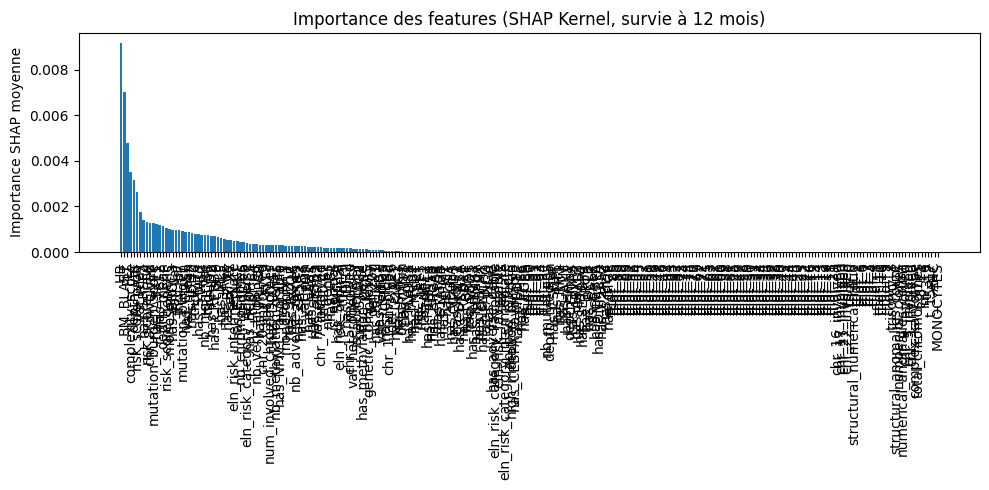

In [131]:
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt

# ⚙️ Paramètres
T_max = 60
n_intervals = 41
t_target = 12

time_grid = np.linspace(0, T_max, n_intervals)
time_idx = np.argmin(np.abs(time_grid - t_target))

print(f"Temps cible {t_target} → intervalle index {time_idx} (≈ {time_grid[time_idx]:.1f})")

background_np = X_features.iloc[:100].values
test_sample_np = X_features.iloc[100:120].values
features = np.array(X_features.columns)

model.eval()

# Fonction prédictive pour SHAP : proba de survie à t_target
def predict_fn(x_numpy):
    x_torch = torch.tensor(x_numpy, dtype=torch.float32)
    with torch.no_grad():
        logits = model(x_torch)  # (batch_size, n_intervals)
        surv = mtlr_survival(logits)  # (batch_size, n_intervals), valeurs entre 0 et 1
        y_target = surv[:, time_idx].numpy()  # proba de survie à t_target
    return y_target

explainer = shap.KernelExplainer(predict_fn, background_np)

# Valeurs SHAP
shap_values = explainer.shap_values(test_sample_np, nsamples=100)

feature_importance = np.mean(np.abs(shap_values), axis=0)
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(features[sorted_idx], feature_importance[sorted_idx])
plt.xticks(rotation=90)
plt.title(f"Importance des features (SHAP Kernel, survie à {t_target} mois)")
plt.ylabel("Importance SHAP moyenne")
plt.tight_layout()
plt.show()